<a href="https://colab.research.google.com/github/Alijgh003/StyleMind-GNN/blob/main/StyleMind_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt

import copy

import pandas as pd

In [ ]:
torch_version = str(torch.__version__)
# scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
# !pip install torch-scatter -f $scatter_src
# !pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
datasets_path = "/content/drive/MyDrive/StyleMind-GNN"

In [4]:
from os import path

In [5]:
import pandas as pd
items = pd.read_csv(path.join(datasets_path, "new_items.csv"))
items.set_index("ID")

,Unnamed: 0.1,Unnamed: 0,index,url_name,category_id,semantic_category,fdescription
ID,,,,,,,
211990161,0,0,0,neck print chiffon plus size,3,tops,neck print chiffon plus size tops
183179503,1,1,1,christian pellizzari floral jacquard trousers,2,bottoms,christian pellizzari floral jacquard trousers ...
152771755,2,2,2,natures jewelry stainless steel not,11,jewellery,natures jewelry stainless steel not jewellery
190445143,3,3,3,balmain women high waist flared,2,bottoms,balmain women high waist flared Decorative gol...
211444470,4,4,4,acler orson high waist belted,2,bottoms,acler orson high waist belted This Acler Orson...
...,...,...,...,...,...,...,...
108411005,251003,251003,251003,arnica embellished hand painted skirt,2,bottoms,arnica embellished hand painted skirt Shop Ste...
212452593,251004,251004,251004,thom browne little boy knitted,4,outerwear,thom browne little boy knitted outerwear
208651882,251005,251005,251005,colorful vortex print shawl scarf,8,scarves,colorful vortex print shawl scarf scarves


In [6]:
index_to_category = torch.tensor(items['category_id'].tolist())
index_to_category.shape

torch.Size([251008])

In [7]:
items.groupby(by="category_id")['category_id'].count()

,category_id
category_id,
1,18478
2,27670
3,32998
4,17065
5,40717
6,44850
7,6973
8,4898
9,6071


#Utils

##Histoagram

In [8]:
def plot_histogram(output_tensor,title):
  output_numpy = output_tensor.detach().numpy()

  plt.hist(output_numpy, bins=30, edgecolor='black', alpha=0.7)
  plt.xlabel('Output Values')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.show()

##Free Cuda_Memory

In [9]:
import gc

def free_cuda_memory(model):
  model = model.cpu()
  gc.collect()
  torch.cuda.empty_cache()

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
# x = torch.load(path.join(datasets_path, "items_img2vec.pth")).to(device)
# x = torch.load(path.join(datasets_path, "clip_embeddings.pth")).to(device)
x = torch.load(path.join(datasets_path, "fine_tuned_clip_embeddings.pth")).to(device)
x, x.shape

(tensor([[ 0.8008,  0.7544, -0.2859,  ..., -0.0613,  0.2081, -0.1008],
         [ 0.7628,  0.3928, -0.0144,  ...,  0.1678,  0.0044,  0.4158],
         [ 0.0486,  0.0045,  0.2929,  ...,  0.0926,  0.1864, -0.2738],
         ...,
         [ 0.4224,  0.2699,  0.0698,  ..., -0.1288,  0.1320, -0.4724],
         [ 0.0233,  0.3910,  0.0047,  ...,  0.0209,  0.3139, -0.2662],
         [ 0.4973,  0.2020,  0.1481,  ...,  0.0934,  0.0943,  0.3633]],
        device='cuda:0'),
 torch.Size([251008, 1024]))

In [12]:
x.dtype ,x.shape, x.device

(torch.float32, torch.Size([251008, 1024]), device(type='cuda', index=0))

In [13]:
edge_indices_path = path.join(datasets_path, "dataset", "polyvore_outfits", "nondisjoint")

In [14]:
train_edge_index = torch.load(path.join(edge_indices_path, "train_edge_index.pth"))
test_edge_index = torch.load(path.join(edge_indices_path, "test_edge_index.pth"))
valid_edge_index = torch.load(path.join(edge_indices_path, "valid_edge_index.pth"))

In [15]:
test_outfits = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_test_outfits.pth'))
test_outfits_indices = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_test_outfit_indices.pth'))
test_choices = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_test_choices.pth'))
test_outfits.shape,test_outfits_indices.shape,test_choices.shape

(torch.Size([43506]), torch.Size([43506]), torch.Size([10000, 4]))

In [16]:
train_outfits = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_train_outfits.pth'))
train_outfits_indices = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_train_outfit_indices.pth'))
train_choices = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_train_choices.pth'))
train_outfits.shape,train_outfits_indices.shape,train_choices.shape

(torch.Size([231461]), torch.Size([231461]), torch.Size([53306, 4]))

In [17]:
valid_outfits = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_valid_outfits.pth'))
valid_outfits_indices = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_valid_outfit_indices.pth'))
valid_choices = torch.load(path.join(edge_indices_path, 'fill_in_the_blank_valid_choices.pth'))
valid_outfits.shape,valid_outfits_indices.shape,valid_choices.shape

(torch.Size([21781]), torch.Size([21781]), torch.Size([5000, 4]))

In [18]:
import torch
import torch.nn.functional as F

to = x[test_outfits[:99].to(device)]
toi = test_outfits_indices[:99].to(device)
num_groups = toi.max().item() + 1
tc = x[test_choices[:num_groups].to(device)]

outfits = torch.zeros(num_groups, to.shape[-1]).to(to.dtype).to(device)
outfits.scatter_reduce_(
    dim=0,
    index=toi.unsqueeze(-1).expand_as(to),
    src=to,
    reduce="sum",
    include_self=False
)

sims = F.cosine_similarity(outfits.unsqueeze(1), tc, dim=-1)
sims

tensor([[ 1.5234e-01,  1.9280e-01,  1.1050e-01,  6.2310e-02],
        [-9.0951e-02, -1.1518e-01, -1.8819e-02,  9.8483e-02],
        [ 7.9629e-02, -1.1072e-02,  2.8942e-02,  9.6661e-02],
        [ 2.1346e-01,  1.3123e-02,  1.8110e-01,  2.2887e-01],
        [ 9.5423e-02, -4.0868e-02, -1.1164e-01, -8.4513e-02],
        [ 9.1324e-02, -1.6423e-01,  1.8056e-01, -1.2621e-01],
        [-4.8703e-03, -8.6167e-02, -9.2625e-02, -7.4548e-02],
        [-8.8243e-02, -8.0772e-02, -6.0887e-02, -1.2875e-01],
        [-7.4127e-02, -1.3008e-01, -3.5646e-02, -1.7848e-01],
        [ 4.7090e-02,  1.3156e-01,  9.3393e-02,  1.4842e-01],
        [-4.9479e-03, -9.2235e-02, -2.5275e-01, -4.6802e-02],
        [-8.0273e-04,  1.6029e-04, -1.2795e-01, -1.2899e-01],
        [ 8.8080e-02,  8.9905e-02,  6.6751e-02,  2.9553e-01],
        [ 2.6632e-01,  5.5053e-02,  2.3732e-01,  9.3582e-02],
        [ 2.7240e-01,  3.2667e-01,  9.6578e-02,  3.0300e-01],
        [ 1.2448e-01,  6.1957e-02,  1.0753e-01, -7.5117e-02],
        

In [19]:
def fill_the_blank(embd, outfits, outfits_indices, choices):
  outfit_embedding = torch.zeros((outfits_indices.max()+1, embd.shape[-1])).to(device)
  outfit_embedding.scatter_reduce_(0, outfits_indices.unsqueeze(1).expand(-1, embd.shape[-1]),embd[outfits],'mean',include_self=False)
  outfit_embedding = outfit_embedding.unsqueeze(1).expand(-1,4,-1)
  result = torch.cosine_similarity(outfit_embedding, embd[choices], dim=-1)
  return result

In [20]:
gcn_embd = torch.load(path.join(datasets_path, "StyleMind-GCN_embedding.pth"))

In [21]:
ll1 = fill_the_blank(gcn_embd.to(device), train_outfits.to(device), train_outfits_indices.to(device), train_choices.to(device))
ll2 = fill_the_blank(gcn_embd.to(device), test_outfits.to(device), test_outfits_indices.to(device), test_choices.to(device))
ll3 = fill_the_blank(gcn_embd.to(device), valid_outfits.to(device), valid_outfits_indices.to(device), valid_choices.to(device))

In [22]:
(ll2.argmax(dim=-1)==0).sum()/test_choices.shape[0]

tensor(0.3734, device='cuda:0')

In [23]:
(ll1.argmax(dim=-1)==0).sum() , (ll2.argmax(dim=-1)==0).sum(), (ll3.argmax(dim=-1)==0).sum()

(tensor(48635, device='cuda:0'),
 tensor(3734, device='cuda:0'),
 tensor(4691, device='cuda:0'))

In [24]:
ll1.mean(dim=0), ll2.mean(dim=0), ll3.mean(dim=0)

(tensor([0.9024, 0.4254, 0.4278, 0.4282], device='cuda:0',
        grad_fn=<MeanBackward1>),
 tensor([0.5619, 0.4887, 0.4881, 0.4895], device='cuda:0',
        grad_fn=<MeanBackward1>),
 tensor([0.9160, 0.3361, 0.3339, 0.3475], device='cuda:0',
        grad_fn=<MeanBackward1>))

In [25]:
def get_node_embedding_with_mask_meaningless_edge_index_elements(x, edge_index, mask_meaningless_with=0):
    mask = torch.where(edge_index==-1, torch.tensor(mask_meaningless_with), torch.tensor(1)).unsqueeze(-1)
    r = x[edge_index] * mask
    return r

In [26]:
train_edge_index.shape, valid_edge_index.shape, test_edge_index.shape

(torch.Size([53306, 2, 171]),
 torch.Size([5000, 2, 91]),
 torch.Size([10000, 2, 136]))

In [27]:
negative_train_edge_index = torch.load(path.join(edge_indices_path,"negative_train_edge_index.pth"))
valid_negative_samples = torch.load(path.join(edge_indices_path, "negative_valid_edge_index.pth"))
test_negative_samples = torch.load(path.join(edge_indices_path, "negative_test_edge_index.pth"))

negative_train_edge_index.shape , valid_negative_samples.shape, test_negative_samples.shape

(torch.Size([53306, 2, 171]),
 torch.Size([5000, 2, 91]),
 torch.Size([10000, 2, 136]))

In [28]:
def build_edge_indices_with_groups(edge_index_tensor_by_groups):
  if(edge_index_tensor_by_groups.shape[0]>0):
    result = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
    result = result[:,torch.where(result[0]>-1)[0]]
    return result
  else:
    return torch.randn((2, 1))

In [29]:
def build_edge_indices_and_indices_with_groups(edge_index_tensor_by_groups):
  if(edge_index_tensor_by_groups.shape[0]>0):
    edge_indices = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
    indices = torch.cat([torch.full((edge_index_tensor_by_groups[i].shape[-1],), i) for i in range(edge_index_tensor_by_groups.shape[0])], dim=-1)
    indices = indices[edge_indices[0]>=0].view(-1,1)
    edge_indices = edge_indices[edge_indices>=0].view(2,-1)
    return edge_indices, indices
  else:
    return torch.randn((2, 1)), torch.randn((2,1))

In [30]:
def calculate_compatiblity_score(x,edge_indices, indices):
  target = torch.zeros((indices.max()+1,1)).to(device)
  y = x[edge_indices]
  y = torch.cosine_similarity(y[0],y[1],dim=-1)
  y = y.view(-1,1)
  # y = (y[0] * y[1]).sum(dim=-1,keepdim=True)
  target.scatter_reduce_(0, index=indices, src=y, reduce="mean",include_self=False)
  return target

In [31]:
edge_indices, indices = build_edge_indices_and_indices_with_groups(train_edge_index[:100])
tar = calculate_compatiblity_score(x.to(device), edge_indices.to(device), indices.to(device))
tar

tensor([[ 0.0059],
        [ 0.0529],
        [ 0.0756],
        [ 0.0906],
        [ 0.0839],
        [ 0.0140],
        [-0.0020],
        [-0.0286],
        [-0.0245],
        [ 0.0601],
        [ 0.0859],
        [ 0.1000],
        [ 0.0327],
        [ 0.0927],
        [ 0.0709],
        [ 0.0896],
        [ 0.0571],
        [ 0.0714],
        [ 0.0005],
        [ 0.1350],
        [ 0.0781],
        [ 0.0625],
        [ 0.0267],
        [ 0.0213],
        [ 0.2169],
        [ 0.0110],
        [ 0.0030],
        [ 0.0411],
        [ 0.0365],
        [ 0.0616],
        [ 0.0690],
        [ 0.0569],
        [ 0.0656],
        [ 0.0366],
        [ 0.0459],
        [-0.0005],
        [ 0.0341],
        [ 0.0494],
        [ 0.0395],
        [ 0.0431],
        [ 0.0260],
        [ 0.0548],
        [ 0.0711],
        [ 0.0565],
        [ 0.0666],
        [ 0.0467],
        [ 0.0926],
        [ 0.0224],
        [ 0.0170],
        [ 0.0521],
        [ 0.0176],
        [ 0.1229],
        [ 0.

In [32]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv,MessagePassing
from torch_geometric.utils import to_undirected
from torch.utils.data import DataLoader, TensorDataset


import torch.optim as optim

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
class MyGCNMLP(MessagePassing):
  def __init__(self,in_channels, out_channels, bias):
    super(MyGCNMLP, self).__init__()

    self.lin = torch.nn.Linear(in_channels, out_channels, bias)


  def forward(self, x, edge_index):
    return self.lin(x)

NameError: name 'MessagePassing' is not defined

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualMLPBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU, dropout=0.0):
        super(ResidualMLPBlock,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lin1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.lin2 = nn.Linear(hidden_dim, input_dim, bias=True)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.act = activation()
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()


    def reset_parameters(self):
      for lin in [self.lin1, self.lin2]:
          lin.reset_parameters()
      self.norm1.reset_parameters()


    def forward(self, x):
        residual = x
        out = self.lin1(x)
        out = self.norm1(out)
        out = self.act(out)
        out = self.dropout(out)
        out = self.lin2(out)
        out = self.act(out + residual)
        return out


In [34]:
class StyleMindMLP(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels,  num_of_res_blocks, dropout=0.5):
    super(StyleMindMLP,self).__init__()
    self.lin1 = nn.Linear(in_channels, hidden_channels)
    self.res = nn.ModuleList([ResidualMLPBlock(hidden_channels, hidden_channels, dropout=dropout) for i in range(num_of_res_blocks)])
    self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_channels) for i in range(num_of_res_blocks)])
    self.lin2 = nn.Linear(hidden_channels, out_channels)
    self.lin3 = nn.Linear(1, 1)

    with torch.no_grad():
      self.lin3.weight.fill_(1.0)
      self.lin3.bias.fill_(0.0)

    self.dropout = nn.Dropout(p=dropout)


  def reset_parameters(self):
    for res in self.res:
        res.reset_parameters()
    for bn in self.bns:
        bn.reset_parameters()
    self.lin1.reset_parameters()
    self.lin2.reset_parameters()
    with torch.no_grad():
      self.lin3.weight.fill_(1.0)
      self.lin3.bias.fill_(0.0)


  def forward(self, x,outfits_edge_indices=None,outfits_indices=None):
    x = self.lin1(x)
    for res,bn in zip(self.res,self.bns):
      x = res(x)
      x = bn(x)
      x = self.dropout(x)

    x = self.lin2(x)
    o = None
    if(outfits_edge_indices is not None and outfits_indices is not None):
        o = calculate_compatiblity_score(x, outfits_edge_indices,outfits_indices)
        o = self.lin3(o)
    return x, o


In [35]:
class StyleMindGCN(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels ,number_of_layers, model_type="GCN" , dropout=0.5, learning_margin=False):
    super(StyleMindGCN,self).__init__()

    self.convs = torch.nn.ModuleList([self.get_model(model_type)(in_channels if i==0 else hidden_channels,hidden_channels if i<number_of_layers-1 else out_channels, bias=False if i<number_of_layers-1 else True) for i in range(number_of_layers)])
    self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_channels) for i in range(number_of_layers-1)])

    self.learning_margin = learning_margin
    if self.learning_margin:
      self.final_prediction_margin = torch.nn.Parameter(torch.tensor(0.0))
    else:
      self.final_prediction_margin = torch.tensor(0.0)

    self.dropout = dropout


  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()
    for bn in self.bns:
        bn.reset_parameters()


  def get_model(self, model_type):
    if(model_type=="GAT"):
      return GATConv
    elif(model_type=="MLP"):
      return MyGCNMLP

    else:
      return GCNConv

  def forward(self, x, edge_index, outfits_edge_indices,outfits_indices):
    # x is the tensor of node_features (i.e. ResNet representation of each image of each garment)
    # edge_index is the (2, |E|) to represent edges between garments
    # outfits_edge_indices is 2 dim tensors with shape of (2,|number_of_pairs|)
    # outfits_indices is 2 dim tensors with shape of (|number_of_pairs|, 1)
    edge_index = to_undirected(edge_index)

    for conv, bn in zip(self.convs[:-1], self.bns):
      x = conv(x, edge_index)
      x = bn(x)
      x = F.relu(x)
      x = F.dropout(x, self.dropout)

    x = self.convs[-1](x,edge_index)

    o = calculate_compatiblity_score(x, outfits_edge_indices,outfits_indices)
    return x, o+self.final_prediction_margin


In [33]:
def train(model, x, edge_index, outfits_edge_indices,outfits_indices, labels, optimizer, loss_fn):
  model.train()
  optimizer.zero_grad()
  embds,o = model(x, edge_index, outfits_edge_indices,outfits_indices)

  loss = loss_fn(o, labels)
  loss.backward()

  optimizer.step()

  return loss.item()

In [34]:
def mlp_train(model, x, outfits_edge_indices,outfits_indices, labels, optimizer, loss_fn):
  model.train()
  optimizer.zero_grad()
  embds,o = model(x, outfits_edge_indices,outfits_indices)
  loss = loss_fn(o.squeeze(), labels)
  loss.backward()

  optimizer.step()

  return loss.item()

In [35]:
@torch.no_grad()
def test(model, x, edge_index, outfits_edge_indices,outfits_indices, labels,fib_outfits, fib_outfits_indices, fib_choices, decision_boundary=0.5):
  model.eval()

  embds,o = model(x, edge_index, outfits_edge_indices,outfits_indices)
  o = torch.sigmoid(o)
  o_pred = torch.where(o>=decision_boundary, torch.tensor(1), torch.tensor(0))
  fib = fill_the_blank(embds, fib_outfits, fib_outfits_indices,  fib_choices)
  fib_acc = (fib.argmax(dim=-1)==0).float().sum()/fib_choices.shape[0]
  acc = (o_pred==labels).float().sum() / o_pred.shape[0]

  return  acc, fib_acc

In [36]:
@torch.no_grad()
def mlp_test(model, x, outfits_edge_indices,outfits_indices, labels,fib_outfits, fib_outfits_indices, fib_choices, decision_boundary=0.5):
  model.eval()

  embds,o = model(x, outfits_edge_indices,outfits_indices)
  o = torch.sigmoid(o.squeeze())
  o_pred = torch.where(o>=decision_boundary, torch.tensor(1), torch.tensor(0))
  fib = fill_the_blank(embds, fib_outfits, fib_outfits_indices,  fib_choices)
  fib_acc = (fib.argmax(dim=-1)==0).float().sum()/fib_choices.shape[0]
  acc = (o_pred==labels).float().sum() / o_pred.shape[0]

  return  acc, fib_acc

In [37]:
in_channels = x.shape[-1]
hidden_channels = 128
out_channels = 128
lr = 0.01
number_of_layers = 3
dropout = 0.5

In [ ]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

NameError: name 'GCNConv' is not defined

In [41]:
NUM_EPOCHS = 500

# TODO:
- [x] splitting train dataset to two part
      - message_passing
      - labels
- [x] negative sampling  
  naive negative sampling: We just have randomly selected
    8 nodes to combine(2,nodes) to create some negative samples

In [33]:
%%time
def split_train_data(train_edge_index, diameter=5):
  edge_nums =  train_edge_index.shape[0]
  random_permutation = torch.randperm(edge_nums)
  eval_outfits = train_edge_index[random_permutation[:edge_nums//diameter]]
  message_passing_edges = build_edge_indices_with_groups(train_edge_index[random_permutation[edge_nums//diameter:]])
  return eval_outfits, message_passing_edges

a = split_train_data(train_edge_index)
[value.shape for  value in a]

CPU times: user 243 ms, sys: 129 ms, total: 371 ms
Wall time: 373 ms


[torch.Size([10661, 2, 171]), torch.Size([2, 550382])]

# Naive negative sampling

In [34]:
%%time
import torch
import itertools

def create_random_negative_samples(num_set, num_samples, num_garment, padding_size):
  combinations = [[list(itertools.combinations(torch.randperm(x.shape[0])[:num_garment].tolist(), 2)) for i in range(num_samples)] for j in range(num_set)]

  tensor = torch.tensor(combinations).transpose(-1,-2)
  tensor = torch.cat((tensor.flip(-2), tensor), dim=-1)
  result = torch.full((num_set, num_samples, 2, padding_size), -1)
  result[:,:,:,:tensor.shape[-1]] = tensor
  return result

# negative_samples = create_random_negative_samples(10, 5000, 8, train_edge_index.shape[-1])
# negative_samples.shape

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.3 µs


In [ ]:
valid_negative_samples = create_random_negative_samples(1, valid_edge_index.shape[0],8, valid_edge_index.shape[-1])[0]
test_negative_samples = create_random_negative_samples(1, test_edge_index.shape[0],8, test_edge_index.shape[-1])[0]
valid_negative_samples.shape, test_negative_samples.shape

KeyboardInterrupt: 

In [35]:
def get_data_splits(train_edges_split_ratio=5):
  train_positives_eval_outfits, train_message_passing_edges = split_train_data(train_edge_index, train_edges_split_ratio)
  train_negatives_eval_outfits = negative_train_edge_index[torch.randperm(negative_train_edge_index.shape[0])[:train_positives_eval_outfits.shape[0]]]
  train_labels = torch.cat((torch.ones(train_positives_eval_outfits.shape[0]),
                            torch.zeros(train_negatives_eval_outfits.shape[0])))
  train_eval_outfits = torch.cat((train_positives_eval_outfits, train_negatives_eval_outfits), dim=0)
  train_outfits_edge_indices,train_outfits_indices= build_edge_indices_and_indices_with_groups(train_eval_outfits)

  valid_message_passing_edges = torch.cat((train_outfits_edge_indices, train_message_passing_edges), dim=-1)
  valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))

  valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
  valid_outfits_edge_indices,valid_outfits_indices= build_edge_indices_and_indices_with_groups(valid_eval_outfits)


  test_message_passing_edges = torch.cat((valid_outfits_edge_indices,valid_message_passing_edges), dim=-1)
  test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                          torch.zeros(test_negative_samples.shape[0])))
  test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
  test_outfits_edge_indices,test_outfits_indices= build_edge_indices_and_indices_with_groups(test_eval_outfits)
  return {
      'test':{
          'outfits_edge_indices': test_outfits_edge_indices,
          'outfits_indices': test_outfits_indices,
          'labels': test_labels,
          'message_passings':test_message_passing_edges,
          'outfits':test_eval_outfits
      },
      'valid':{
          'outfits_edge_indices': valid_outfits_edge_indices,
          'outfits_indices': valid_outfits_indices,
          'labels': valid_labels,
          'message_passings':valid_message_passing_edges,
          'outfits':valid_eval_outfits
      },
      'train':{
          'outfits_edge_indices': train_outfits_edge_indices,
          'outfits_indices': train_outfits_indices,
          'labels': train_labels,
          'message_passings':train_message_passing_edges,
          'outfits':train_eval_outfits
      }
  }

In [36]:
def get_mlp_data_splits():
  train_labels = torch.cat((torch.ones(train_edge_index.shape[0]),
                            torch.zeros(negative_train_edge_index.shape[0])))
  train_eval_outfits = torch.cat((train_edge_index, negative_train_edge_index), dim=0)

  valid_labels = torch.cat((torch.ones(valid_edge_index.shape[0]),
                              torch.zeros(valid_negative_samples.shape[0])))

  valid_eval_outfits = torch.cat((valid_edge_index, valid_negative_samples), dim=0)
  valid_outfits_edge_indices,valid_outfits_indices= build_edge_indices_and_indices_with_groups(valid_eval_outfits)

  test_labels = torch.cat((torch.ones(test_edge_index.shape[0]),
                          torch.zeros(test_negative_samples.shape[0])))
  test_eval_outfits = torch.cat((test_edge_index, test_negative_samples), dim=0)
  test_outfits_edge_indices,test_outfits_indices= build_edge_indices_and_indices_with_groups(test_eval_outfits)
  return {
      'test':{
          'outfits_edge_indices': test_outfits_edge_indices,
          'outfits_indices': test_outfits_indices,
          'labels': test_labels,
          'outfits':test_eval_outfits
      },
      'valid':{
          'outfits_edge_indices': valid_outfits_edge_indices,
          'outfits_indices': valid_outfits_indices,
          'labels': valid_labels,
          'outfits':valid_eval_outfits
      },
      'train':{
          'labels': train_labels,
          'outfits':train_eval_outfits
      }
  }

In [42]:
mlp_data = get_mlp_data_splits()
mlp_data['train']['outfits'].shape, mlp_data['train']['labels'].shape

(torch.Size([106612, 2, 171]), torch.Size([106612]))

# untrained model behaviour

In [ ]:
model2 = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

NameError: name 'StyleMindGCN' is not defined

In [ ]:
test_acc = test(model2, x, data_splits['test']['message_passings'].to(device)
    , data_splits['test']['outfits_edge_indices'].to(device),
      data_splits['test']['outfits_indices'].to(device), data_splits['test']['labels'].to(device))
with torch.no_grad():
  embd, o = model2(x, data_splits['test']['message_passings'].to(device),
      data_splits['test']['outfits_edge_indices'].to(device),
        data_splits['test']['outfits_indices'].to(device))


embd= embd.cpu()
o = o.cpu()

print(test_acc)

NameError: name 'model2' is not defined

In [ ]:
plot_histogram(o[:o.shape[0]//2], "inner product only model positives")
plot_histogram(o[o.shape[0]//2:], "inner product only model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "inner product only model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "inner product only model negatives sigmoid")

NameError: name 'o' is not defined

In [ ]:
positives = o[:o.shape[0]//2]
negatives = o[o.shape[0]//2:]

pacc = (positives >= 0).float().sum() / positives.shape[0]
nacc = (negatives < 0).float().sum() / negatives.shape[0]
pacc * 0.5 + nacc*0.5

NameError: name 'o' is not defined

In [ ]:
free_cuda_memory(model)

NameError: name 'model' is not defined

#Adding bias to sigmoid inputs

In [37]:
import copy

In [ ]:
model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_test_fib_acc = 0
best_model = None

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS):

    data_splits = get_data_splits(5)
    train_loss = train(model, x, data_splits['train']['message_passings'].to(device)
    , data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device), data_splits['train']['labels'].to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc, train_fib_acc = test(model, x, data_splits['train']['message_passings'].to(device)
    , data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device), data_splits['train']['labels'].to(device)
      ,train_outfits.to(device) ,train_outfits_indices.to(device) ,train_choices.to(device))
    valid_acc, valid_fib_acc = test(model, x, data_splits['valid']['message_passings'].to(device)
    , data_splits['valid']['outfits_edge_indices'].to(device),
      data_splits['valid']['outfits_indices'].to(device), data_splits['valid']['labels'].to(device)
      ,valid_outfits.to(device) ,valid_outfits_indices.to(device) ,valid_choices.to(device))
    test_acc, test_fib_acc = test(model, x, data_splits['test']['message_passings'].to(device)
    , data_splits['test']['outfits_edge_indices'].to(device),
      data_splits['test']['outfits_indices'].to(device), data_splits['test']['labels'].to(device)
    ,test_outfits.to(device) ,test_outfits_indices.to(device) ,test_choices.to(device))
    if(test_fib_acc > best_test_fib_acc):
        best_test_fib_acc = test_fib_acc
        best_model = copy.deepcopy(model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%\n',
          f'FIB_Train: {100 * train_fib_acc:.2f}%, '
          f'FIB_Valid: {100 * valid_fib_acc:.2f}% '
          f'FIB_Test: {100 * test_fib_acc:.2f}%\n')


NameError: name 'model' is not defined

In [ ]:
valid_acc, valid_fib_acc = test(model, x, data_splits['valid']['message_passings'].to(device)
    , data_splits['valid']['outfits_edge_indices'].to(device),
      data_splits['valid']['outfits_indices'].to(device), data_splits['valid']['labels'].to(device)
      ,valid_outfits.to(device) ,valid_outfits_indices.to(device) ,valid_choices.to(device))

valid_acc, valid_fib_acc

NameError: name 'model' is not defined

In [ ]:
fibt = fill_the_blank(embd.to(device), valid_outfits.to(device) ,valid_outfits_indices.to(device) ,valid_choices.to(device))

NameError: name 'embd' is not defined

In [ ]:
fibt.mean(dim=0)

tensor([0.8831, 0.2853, 0.2774, 0.2818], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [ ]:
best_test_acc

tensor(0.9106, device='cuda:0')

In [ ]:
save_model(best_model, datasets_path, "StyleMind-GCN_biased_outputs.pth")

In [ ]:
model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GCN", dropout, learning_margin=True).to(device)

model.load_state_dict(torch.load(path.join(datasets_path, "StyleMind-GCN_biased_outputs.pth")))

NameError: name 'StyleMindGCN' is not defined

In [ ]:
# test_acc = test(best_model, x, data_splits['test']['message_passings'].to(device)
#     , data_splits['test']['outfits_edge_indices'].to(device),
#       data_splits['test']['outfits_indices'].to(device), data_splits['test']['labels'].to(device))
embd, o = best_model(x, data_splits['train']['message_passings'].to(device),
    data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device))


embd= embd.cpu()
o = o.cpu()

print(train_acc)

tensor(0.8927, device='cuda:0')


In [ ]:
best_model.final_prediction_margin

Parameter containing:
tensor(-0.3101, device='cuda:0', requires_grad=True)

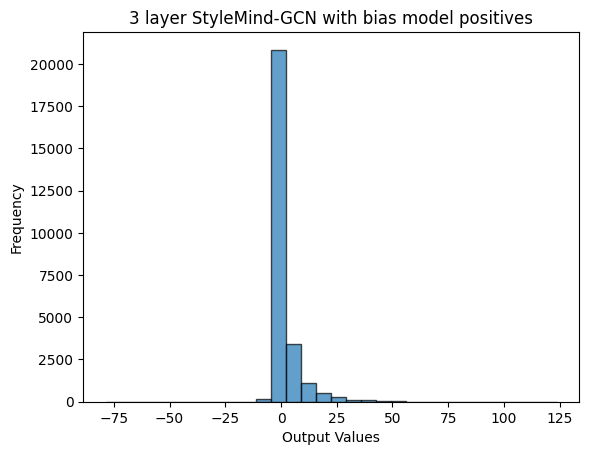

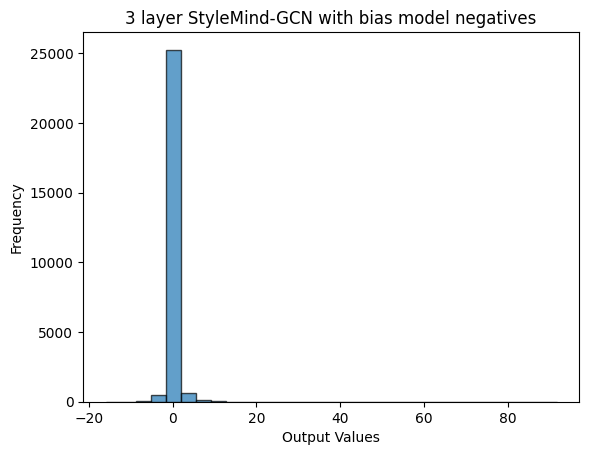

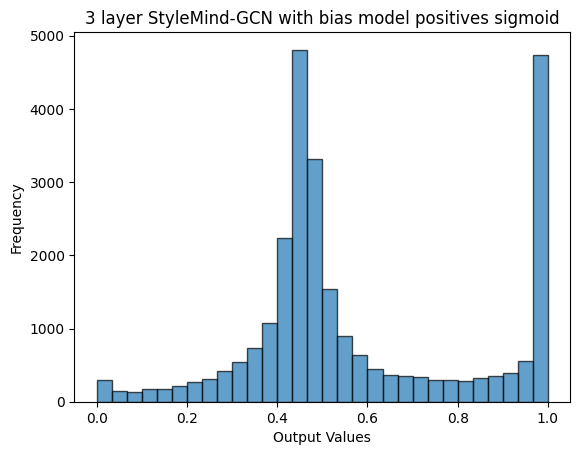

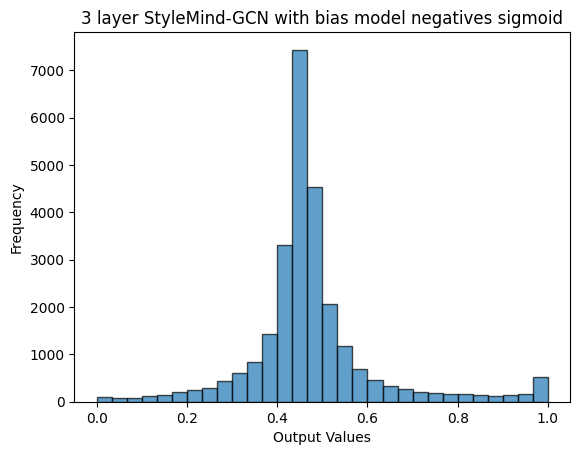

In [ ]:
plot_histogram(o[:o.shape[0]//2], "3 layer StyleMind-GCN with bias model positives")
plot_histogram(o[o.shape[0]//2:], "3 layer StyleMind-GCN with bias model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "3 layer StyleMind-GCN with bias model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "3 layer StyleMind-GCN with bias model negatives sigmoid")

In [ ]:
torch.save(embd, path.join(datasets_path, "StyleMind-GCN_embedding.pth"))

In [ ]:
# the worst false negatives
values, indices = torch.topk(negatives, 10, largest=True)

outfits = train_eval_outfits[(o.shape[0]//2)+indices][torch.where(train_eval_outfits[(o.shape[0]//2)+indices]>-1)]
number_of_garments_per_outfit = (train_eval_outfits[o.shape[0]//2+indices]>-1).float().sum(dim=(-1,-2))

outfits, number_of_garments_per_outfit
i = 0
result = []
for j in number_of_garments_per_outfit.int():
  result.append(set(outfits[i:i+j].tolist()))
  i += j

result = {k: [items.loc[items['index']==i]['ID'].item() for i in o]  for k,o in enumerate(result)}

import json

with open("worstFPs.json", "w") as f:
  json.dump(result, f, indent=4)

In [ ]:
import json

# Read JSON from a file
with open("worstFPs.json", "r") as file:
    data = json.load(file)

print("JSON data:", data)


JSON data: {'0': [45768566, 143354527, 206299484, 183302521, 183236812], '1': [170301920, 132033877, 187498982, 158839785, 187950596, 191998015], '2': [80360383, 74588000, 126859205, 138180455, 205836766], '3': [41730249, 147883331, 147411023, 150737564, 189846447], '4': [161599256, 201458859, 68105585, 165502261, 150091405, 164826821, 101837389, 173597815], '5': [190811204, 145397682, 204542257, 211682911, 203154762], '6': [212764580, 150675438, 151380680, 179988294, 181104358], '7': [210473563, 167057560, 134389933, 65090075, 186155013, 127684739], '8': [197305654, 150495323, 132068063, 138667859, 174348662], '9': [166373789, 178782478, 212809241, 197241787, 157974990, 102523727, 47352111, 181333601]}


In [ ]:
# the worst false positives
values, indices = torch.topk(positives, 10, largest=False)

outfits = train_eval_outfits[indices][torch.where(train_eval_outfits[indices]>-1)]
number_of_garments_per_outfit = (train_eval_outfits[indices]>-1).float().sum(dim=(-1,-2))

outfits, number_of_garments_per_outfit
i = 0
result = []
for j in number_of_garments_per_outfit.int():
  result.append(set(outfits[i:i+j].tolist()))
  i += j

result = {k: [items.loc[items['index']==i]['ID'].item() for i in o]  for k,o in enumerate(result)}

import json

with open("worstFNs.json", "w") as f:
  json.dump(result, f, indent=4)

In [ ]:
ss = torch.randn(10).to(device)


a = set(ss.tolist())
a

{-0.9159104824066162,
 -0.3835882246494293,
 -0.30730435252189636,
 -0.17330965399742126,
 -0.16745677590370178,
 0.44133099913597107,
 0.7212685942649841,
 0.9103254675865173,
 0.9919949173927307,
 1.2212848663330078}

In [44]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
m = x[:100].cpu()
m

tensor([[ 0.8008,  0.7544, -0.2859,  ..., -0.0613,  0.2081, -0.1008],
        [ 0.7628,  0.3928, -0.0144,  ...,  0.1678,  0.0044,  0.4158],
        [ 0.0486,  0.0045,  0.2929,  ...,  0.0926,  0.1864, -0.2738],
        ...,
        [ 0.1957, -0.1518,  0.4670,  ..., -0.3675, -0.2152,  0.3171],
        [ 0.2709,  0.3820,  0.2230,  ...,  0.1621, -0.2803, -0.5909],
        [ 0.1538,  0.6313, -0.1286,  ..., -0.0405,  0.2907, -0.2594]])

In [ ]:
get_node_embedding_with_mask_meaningless_edge_index_elements(x.cpu(), train_eval_outfits[:100])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_test_acc.item()

0.757099986076355

In [38]:
def save_model(model, data_path, name):
  torch.save(model.state_dict(), path.join(data_path,name))

In [ ]:
save_model(best_model, datasets_path, "best_gcn_model_based_with_cosine.pth")
save_model(model, datasets_path, "last_gcn_model_based_with_cosine.pth")

In [ ]:
model.load_state_dict(torch.load(path.join(datasets_path,"last_gcn_model_based_with_cosine.pth")))

<All keys matched successfully>

In [ ]:
negative_train_edge_index.shape

torch.Size([53306, 2, 171])

In [ ]:
train_acc = test(model, x, message_passing_edges.to(device)
, train_eval_outfits.to(device), train_labels.to(device))

In [ ]:
embd, o = model(x, test_message_passing_edges.to(device)
, train_eval_outfits[14000:].to(device))

embd = embd.cpu()
o = o.cpu()



In [ ]:
train_eval_outfits[14000:][18]

tensor([[205458, 205458,  53235,  42435,  42435,  42435,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,     -1,
             -1,     -1,    

In [ ]:
items.loc[items['index'].isin([205458,  53235,  42435,9357])]

,Unnamed: 0,index,ID,url_name,description,catgeories,title,related,category_id,semantic_category,name_len
9357,9357,9357,213438505,fabulous in pink cluster earrings,NaN,NaN,NaN,NaN,11,jewellery,33
42435,42435,42435,35211694,notte marchesa silk-chiffon silk-organza halte...,NaN,NaN,NaN,NaN,1,all-body,51
53235,53235,53235,208070724,espadrilles with lacing 29.99,Yellow. Satin sandals with an adjustable strap...,"[""Women's Fashion"", 'Shoes', 'Sandals']",Sandals $24.99,"['Flats sandals', 'Yellow sandals', 'Rubber so...",6,shoes,29
205458,205458,205458,153558426,dolce gabbana sicily von crystal,NaN,NaN,NaN,NaN,5,bags,32


In [ ]:
torch.argmin(o)

tensor(3439)

In [ ]:
torch.argmax(o)

tensor(7257)

In [ ]:
indices = (o > 0.8).nonzero(as_tuple=True)
indices

(tensor([  18,  132,  159,  259,  439,  513,  711,  796, 1006, 1008, 1347, 1401,
         1462, 1580, 1594, 1630, 1647, 1692, 1772, 1790, 1825, 1841, 1905, 2251,
         2558, 2564, 2727, 2854, 3030, 3210, 3472, 3551, 3873, 4045, 4159, 4199,
         4279, 4412, 4535, 4649, 5113, 5183, 5217, 5224, 5333, 5385, 5436, 5480,
         5538, 5794, 5858, 5886, 5900, 5924, 6022, 6092, 6146, 6390, 6449, 6495,
         6498, 6562, 6634, 6776, 7019, 7092, 7257, 7272, 7309]),)

In [ ]:
o.shape, (o[o<0.5]).shape

(torch.Size([7322]), torch.Size([3653]))

In [ ]:
train_eval_outfits.shape

torch.Size([21322, 2, 171])

In [ ]:
node_embeddigns, o = best_model(x, test_message_passing_edges.to(device), test_eval_outfits.to(device))

o.shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.60 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.51 GiB is free. Process 69290 has 13.23 GiB memory in use. Of the allocated memory 11.11 GiB is allocated by PyTorch, and 1.99 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [39]:
import gc

gc.collect()
torch.cuda.empty_cache()

NameError: name 'losses' is not defined

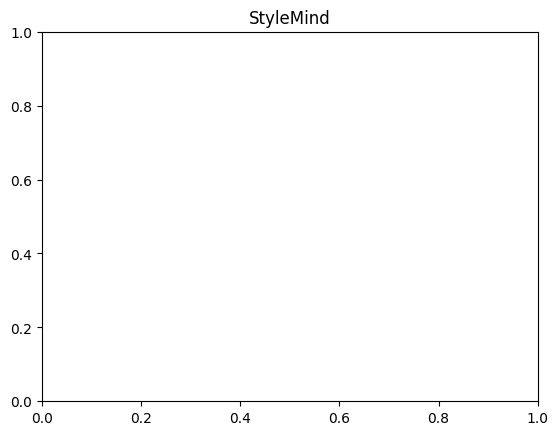

In [50]:

plt.title("StyleMind")
plt.plot(losses[3:], label="training loss" + " - " + "StyleMind-GCN")
plt.plot(test_accs[3:], label="test accuracy" + " - " + "StyleMind-GCN")
plt.legend()
plt.show()


In [ ]:
hidden_channel = 256
in_channels = x.shape[-1]
out_channel = 256
num_of_res_blocks = 2
dropout = 0.5
lr = 0.01
mlp_model = StyleMindMLP(in_channels, hidden_channel, out_channel,num_of_res_blocks,dropout).to(device)

NameError: name 'StyleMindMLP' is not defined

In [40]:
from tqdm import tqdm

In [41]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [42]:
def get_batch_data_xidx_edges(batch_data_edge_indices,fib_outfits,fib_choices):
    catted_indices = torch.cat((batch_data_edge_indices.view(-1,1).squeeze(),fib_outfits,fib_choices.view(-1,1).squeeze()))
    batch_data_x_indices, batch_data_x_inverse_indices = torch.unique(catted_indices, return_inverse=True)
    new_catted_indices = batch_data_x_inverse_indices.view_as(catted_indices)
    x1 = batch_data_edge_indices.view(-1,1).squeeze().shape[0]
    x2 = fib_outfits.shape[0]
    x3 = fib_choices.view(-1,1).squeeze().shape[0]
    new_batch_data_edge_indices = new_catted_indices[:x1].reshape(batch_data_edge_indices.shape)
    new_fib_outfits = new_catted_indices[x1:x1+x2].reshape(fib_outfits.shape)
    new_fib_choices =  new_catted_indices[x1+x2: x1+x2+x3].reshape(fib_choices.shape)
    return batch_data_x_indices, new_batch_data_edge_indices, new_fib_outfits, new_fib_choices


In [43]:
datasplit = get_mlp_data_splits()

In [44]:
valid_data_x_indices, new_valid_data_edge_indices,new_fib_outfits, new_fib_choices = get_batch_data_xidx_edges(datasplit['valid']['outfits_edge_indices'], valid_outfits, valid_choices)

In [ ]:
mlp_model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_test_fib_acc = 0
best_model = None
best_fib_model = None

optimizer = optim.Adam(mlp_model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to("cpu")
datasplit = get_mlp_data_splits()

dataset = TensorDataset(datasplit['train']['outfits'], datasplit['train']['labels'])
dataloader = DataLoader(dataset, batch_size=30000, shuffle=True)
train_acc, train_fib_acc = 0.0, 0.0

for epoch in range(1000):
  for batch_idx, (batch_data, batch_labels) in enumerate(tqdm(dataloader, desc=f'Processing Batches, {100 * train_acc:.2f}, {100 * train_fib_acc:.2f}')):
      batch_data_edge_indices ,batch_data_indices= build_edge_indices_and_indices_with_groups(batch_data)

      batch_data_x_indices, new_batch_data_edge_indices,new_train_fib_outfits, new_train_fib_choices = get_batch_data_xidx_edges(batch_data_edge_indices, train_outfits, train_choices)
      new_batch_data_edge_indices ,batch_data_indices, batch_labels = new_batch_data_edge_indices.to(device) ,batch_data_indices.to(device), batch_labels.to(device)

      train_loss = mlp_train(mlp_model, x[batch_data_x_indices].to(device), new_batch_data_edge_indices.to(device) ,batch_data_indices.to(device), batch_labels.to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
      train_acc, train_fib_acc = mlp_test(mlp_model, x[batch_data_x_indices].to(device), new_batch_data_edge_indices.to(device),
                              batch_data_indices.to(device), batch_labels.to(device),new_train_fib_outfits.to(device) ,
                            train_outfits_indices.to(device) ,new_train_fib_choices.to(device))



  valid_data_x_indices, new_valid_data_edge_indices,new_valid_fib_outfits, new_valid_fib_choices = get_batch_data_xidx_edges(datasplit['valid']['outfits_edge_indices'], valid_outfits, valid_choices)
  valid_acc, valid_fib_acc = mlp_test(mlp_model, x[valid_data_x_indices].to(device), new_valid_data_edge_indices.to(device),
      datasplit['valid']['outfits_indices'].to(device), datasplit['valid']['labels'].to(device),
      new_valid_fib_outfits.to(device) ,valid_outfits_indices.to(device) ,new_valid_fib_choices.to(device))

  test_data_x_indices, new_test_data_edge_indices,new_test_fib_outfits, new_test_fib_choices = get_batch_data_xidx_edges(datasplit['test']['outfits_edge_indices'], test_outfits, test_choices)
  test_acc, test_fib_acc = mlp_test(mlp_model, x[test_data_x_indices].to(device), new_test_data_edge_indices.to(device),
      datasplit['test']['outfits_indices'].to(device), datasplit['test']['labels'].to(device),
      new_test_fib_outfits.to(device) ,test_outfits_indices.to(device) ,new_test_fib_choices.to(device))


  if(test_acc > best_test_acc ):
      best_test_acc = test_acc
      best_model = copy.deepcopy(mlp_model)
      save_model(best_model, datasets_path, "StyleMind-Deep-MLP3_best.pth")

  if(test_fib_acc > best_test_fib_acc):
      best_test_fib_acc = test_fib_acc
      best_fib_model = copy.deepcopy(mlp_model)
      save_model(best_fib_model, datasets_path, "StyleMind-Deep-MLP3_best_fib.pth")


  losses.append(train_loss)
  test_accs.append(test_acc)
  print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%\n',
          f'FIB_Valid: {100 * valid_fib_acc:.2f}% '
          f'FIB_Test: {100 * test_fib_acc:.2f}%\n')



Processing Batches, 0.00, 0.00:  25%|██▌       | 1/4 [00:08<00:24,  8.30s/it]


KeyboardInterrupt: 

In [ ]:
train_outfits.shape, train_outfits_indices.shape, train_choices.shape

In [ ]:
train_choices,

## Best Test Accuracy = 0.809

In [ ]:
hidden_channel = 256
in_channels = x.shape[-1]
out_channel = 256
num_of_res_blocks = 2
dropout = 0.5
lr = 0.01
best_model = StyleMindMLP(in_channels, hidden_channel, out_channel,num_of_res_blocks,dropout).to(device)

best_model.load_state_dict(torch.load(path.join(datasets_path,"StyleMind-Deep-MLP3_best_fib.pth")))

In [ ]:
datasplit = get_mlp_data_splits()

In [ ]:
test_data_x_indices, new_test_data_edge_indices,new_test_fib_outfits, new_test_fib_choices = get_batch_data_xidx_edges(datasplit['test']['outfits_edge_indices'], test_outfits, test_choices)
finet_fib_model.base_model_init.eval()
embd, o = finet_fib_model.base_model_init(x[test_data_x_indices].to(device), new_test_data_edge_indices.to(device),
      datasplit['test']['outfits_indices'].to(device))

embd = embd.cpu()
o = o.cpu()

In [ ]:
test_data_x_indices, new_test_data_edge_indices,new_test_fib_outfits, new_test_fib_choices = get_batch_data_xidx_edges(datasplit['test']['outfits_edge_indices'], test_outfits, test_choices)
test_acc, test_fib_acc = mlp_test(finet_fib_model.base_model, x[test_data_x_indices].to(device), new_test_data_edge_indices.to(device),
          datasplit['test']['outfits_indices'].to(device), datasplit['test']['labels'].to(device),
          new_test_fib_outfits.to(device) ,test_outfits_indices.to(device) ,new_test_fib_choices.to(device))

test_acc, test_fib_acc

(tensor(0.7814, device='cuda:0'), tensor(0.4698, device='cuda:0'))

In [ ]:
torch.save(embd, path.join(datasets_path, "mlp_embedding.pth"))

In [ ]:
best_model.final_prediction_margin

Parameter containing:
tensor(-2.7896, device='cuda:0', requires_grad=True)

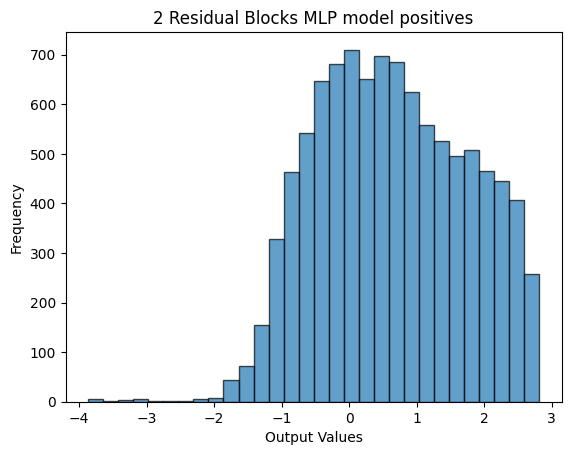

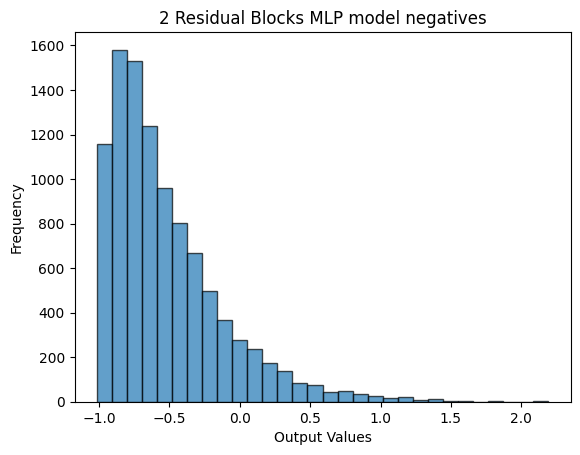

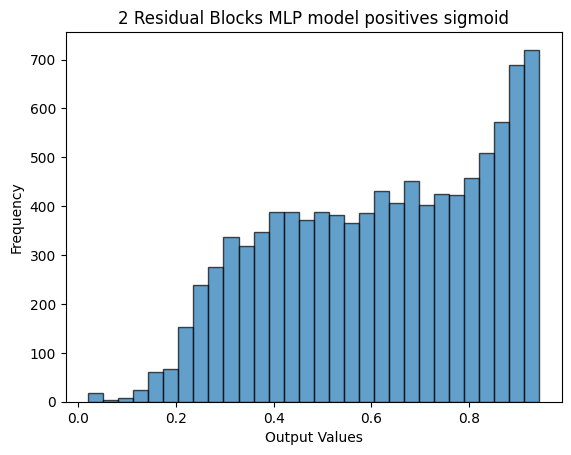

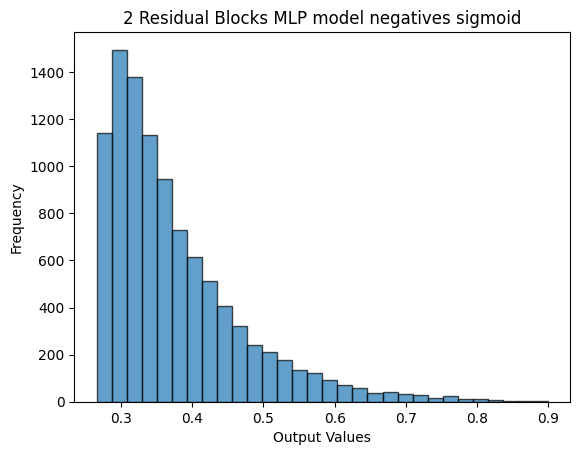

In [ ]:
plot_histogram(o[:o.shape[0]//2], "2 Residual Blocks MLP model positives")
plot_histogram(o[o.shape[0]//2:], "2 Residual Blocks MLP model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "2 Residual Blocks MLP model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "2 Residual Blocks MLP model negatives sigmoid")

In [ ]:
save_model(best_model, datasets_path, "MLP_model.pth")

In [45]:
import copy
import torch.nn as nn

In [53]:
class FIBWithAttentionOutfitRepresentation(nn.Module):
  def __init__(self, d_model,num_heads=1, dropout=0.5):
    super(FIBWithAttentionOutfitRepresentation,self).__init__()
    self.dropout = dropout
    self.ln1 = nn.LayerNorm(d_model)
    self.cross_attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True, dropout=dropout, device=device)

    self.ln2= nn.LayerNorm(d_model)
    self.attn = nn.Parameter(torch.randn(1, 1, d_model))

    self.log_softmax = nn.LogSoftmax(dim=-1)

  def reset_parameters(self):
    self.ln2.reset_parameters()
    self.ln1.reset_parameters()
    self.cross_attention.reset_parameters()

  def forward(self, x, outfit_indices, choices_indices, outfits_x_masks, masked_positions):
    x = self.ln1(x)

    ox = x[outfit_indices]
    cx = x[choices_indices]

    outfits,_ = self.cross_attention(self.attn.expand((ox.shape[0],-1,-1)),
                                   ox, ox, key_padding_mask=outfits_x_masks)
    o = 20 * F.cosine_similarity(outfits, cx, dim=-1)

    o = self.log_softmax(o)

    return o

In [56]:
class FIBWithAttentionOutfitRepresentationWithGateFusion(FIBWithAttentionOutfitRepresentation):
  def __init__(self, d_model,num_heads=1, dropout=0.5):
    super(FIBWithAttentionOutfitRepresentationWithGateFusion,self).__init__(d_model,num_heads, dropout)

    self.d_model = d_model
    self.ln = nn.LayerNorm(2*d_model)
    self.gate_mlp = nn.Linear(2*d_model, d_model)



  def forward(self, x, outfit_indices, choices_indices, outfits_x_masks, masked_positions):

    catted = self.ln(x)

    gate = self.gate_mlp(catted)
    gate = torch.sigmoid(gate)

    images = x[:, :self.d_model]
    text = x[:, self.d_model:]

    fused = gate * images + (1 - gate) * text

    return super().forward(fused, outfit_indices, choices_indices, outfits_x_masks, masked_positions)


In [ ]:
class FIBWithPoolOutfitRepresentation(nn.Module):
  def __init__(self, in_channel, hidden_channel, out_channel, num_of_res_blocks,dropout, load_base_from_file=None):
    super(FIBWithPoolOutfitRepresentation, self).__init__()
    self.base_model = StyleMindMLP(in_channel, hidden_channel, out_channel,num_of_res_blocks,dropout)
    if(load_base_from_file):
      self.base_model.load_state_dict(torch.load(load_base_from_file,map_location=device))
    self.lin = nn.Linear(out_channel, out_channel)
    self.load_base_from_file = load_base_from_file
    self.log_softmax = nn.LogSoftmax(dim=1)

  def reset_parameters(self):
    self.lin.reset_parameters()
    self.base_model.reset_parameters()
    if(self.load_base_from_file):
      self.base_model.load_state_dict(torch.load(self.load_base_from_file,map_location=device))

  def forward(self, outfits_x, outfits_x_masks, choices_x):
    catted_x = torch.cat((outfits_x,choices_x),dim=1)
    num_of_o, num_of_g = catted_x.shape[0], catted_x.shape[1]
    catted_x = catted_x.view(num_of_o*num_of_g, -1)
    x = self.base_model(catted_x)[0].view(num_of_o,num_of_g,-1)
    ox = x[:,:outfits_x.shape[1]]
    ox.masked_fill_(outfits_x_masks.unsqueeze(-1), float(0))
    ox = ox.sum(dim=1, keepdim=True)
    ox = self.lin(ox)
    cx = x[:,outfits_x.shape[1]:]
    o = F.cosine_similarity(ox, cx,dim=-1)
    o = self.log_softmax(o).squeeze(-1)
    return o

In [46]:
def mlp_fib_train(model, x, outfit_indices, choices_indices, outfits_x_masks, masked_positions, loss_fn, optimizer):
  model.train()
  optimizer.zero_grad()
  labels = torch.zeros((outfit_indices.shape[0]),dtype=int).to(device)
  o = model(x, outfit_indices, choices_indices, outfits_x_masks, masked_positions)
  loss = loss_fn(o, labels)
  loss.backward()

  optimizer.step()

  return loss.item()

In [47]:
def mlp_fib_test(model,x, outfit_indices, choices_indices, outfits_x_masks, masked_positions):
  model.eval()

  labels = torch.zeros((outfit_indices.shape[0]),dtype=int).to(device)
  o = model(x, outfit_indices, choices_indices, outfits_x_masks, masked_positions)
  o_pred = o.argmax(dim=-1)
  fib_acc = (o_pred==labels).float().sum()/choices_indices.shape[0]
  return  fib_acc

In [81]:
hidden_channel = 256
in_channels = x.shape[-1]
out_channel = 256
num_of_res_blocks = 2
dropout = 0.5
lr = 0.01
best_base_model = StyleMindMLP(in_channels, hidden_channel, out_channel,num_of_res_blocks,dropout).to(device)

best_base_model.load_state_dict(torch.load(path.join(datasets_path,"StyleMind-Deep-MLP3_best_fib.pth"),map_location=device))

NameError: name 'StyleMindMLP' is not defined

In [ ]:
free_cuda_memory(un_pretrained_base_model)

In [ ]:
hidden_channel = 256
in_channels = x.shape[-1]
out_channel = 256
num_of_res_blocks = 2
dropout = 0.5
lr = 0.01
un_pretrained_base_model = StyleMindMLP(in_channels, hidden_channel, out_channel,num_of_res_blocks,dropout).to(device)

In [57]:
d_model = x.shape[-1]//2
dropout = 0.3
lr = 3e-4
num_heads = 32
# fib_attention = FIBWithAttentionOutfitRepresentation(d_model=d_model, num_heads=num_heads, dropout=dropout).to(device)
fib_attention = FIBWithAttentionOutfitRepresentationWithGateFusion(d_model=d_model, num_heads=num_heads, dropout=dropout).to(device)

In [48]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
hidden_channel = 256
in_channels = x.shape[-1]
out_channel = 256
num_of_res_blocks = 2
dropout = 0.5
lr = 0.01
fib_simple_mean_pool_model = FIBWithPoolOutfitRepresentation(in_channels, hidden_channel, out_channel, num_of_res_blocks,dropout).to(device)

In [ ]:
hidden_channel = 256
in_channels = x.shape[-1]
out_channel = 256
num_of_res_blocks = 2
dropout = 0.5
lr = 0.01
heads_num = 4
fib_attention_model = FIBWithAttentionOutfitRepresentation(in_channels, hidden_channel, out_channel, num_of_res_blocks,dropout, heads_num).to(device)

In [49]:
train_padded_tensor = torch.load(path.join(datasets_path, "fib_train_padded_outfits.pth"))
valid_padded_tensor = torch.load(path.join(datasets_path, "fib_valid_padded_outfits.pth"))
test_padded_tensor = torch.load(path.join(datasets_path, "fib_test_padded_outfits.pth"))

In [60]:
%%time
j = 0
for i in range(40000):
 j += 1

print(j)

40000
CPU times: user 6.55 ms, sys: 0 ns, total: 6.55 ms
Wall time: 7.31 ms


In [50]:
def get_batch_data_xidx_fibs(fib_outfits,fib_choices):
    catted_indices = torch.cat((fib_outfits.view(-1),fib_choices.view(-1)))
    batch_data_x_indices, batch_data_x_inverse_indices = torch.unique(catted_indices, return_inverse=True)
    new_catted_indices = batch_data_x_inverse_indices.view_as(catted_indices)
    x1 = fib_outfits.view(-1).shape[0]
    x2 = fib_choices.view(-1).shape[0]
    new_fib_outfits = new_catted_indices[:x1].reshape(fib_outfits.shape)
    new_fib_choices = new_catted_indices[x1:x1+x2].reshape(fib_choices.shape)
    return batch_data_x_indices, new_fib_outfits, new_fib_choices

In [51]:
a,b,c = get_batch_data_xidx_fibs(train_padded_tensor[1000:2000], train_choices[1000:2000])

In [86]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
fib_simple_mean_pool_model.reset_parameters()

losses = []
test_accs = []

best_fib_model = None
best_test_fib_acc = 0.0

optimizer = optim.Adam(fib_simple_mean_pool_model.parameters(), lr)
loss_fn = nn.NLLLoss()

x = x.to("cpu")

dataset = TensorDataset(train_padded_tensor, train_choices)
dataloader = DataLoader(dataset, batch_size=8000, shuffle=True)
train_fib_acc = 0.0

x_valid_outfits_maskes = valid_padded_tensor==-1
x_valid_outfits = x[valid_padded_tensor]
x_valid_outfits.masked_fill_(x_valid_outfits_maskes.unsqueeze(-1),0)
x_valid_choices = x[valid_choices]

x_test_outfits_maskes = test_padded_tensor==-1
x_test_outfits = x[test_padded_tensor]
x_test_outfits.masked_fill_(x_test_outfits_maskes.unsqueeze(-1),0)
x_test_choices = x[test_choices]

for epoch in range(1000):
  for batch_idx, (batch_outfits_indices, batch_choices_indices) in enumerate(tqdm(dataloader, desc=f'Processing Batches, {100 * train_fib_acc:.2f}')):
      x_choice = x[batch_choices_indices]
      x_outfit_maskes = (batch_outfits_indices==-1)
      x_outfit = x[batch_outfits_indices]
      x_outfit.masked_fill_(x_outfit_maskes.unsqueeze(-1), 0.0)
      train_loss = mlp_fib_train(fib_simple_mean_pool_model, x_outfit.to(device)  ,x_outfit_maskes.to(device)
       , x_choice.to(device), loss_fn=loss_fn, optimizer=optimizer)
      train_fib_acc = mlp_fib_test(fib_simple_mean_pool_model, x_outfit.to(device),x_outfit_maskes.to(device)
       , x_choice.to(device))



  valid_fib_acc = mlp_fib_test(fib_simple_mean_pool_model, x_valid_outfits.to(device),x_valid_outfits_maskes.to(device),x_valid_choices.to(device))



  test_fib_acc = mlp_fib_test(fib_simple_mean_pool_model, x_test_outfits.to(device), x_test_outfits_maskes.to(device),x_test_choices.to(device))




  if(test_fib_acc > best_test_fib_acc):
      best_test_fib_acc = test_fib_acc
      best_fib_model = copy.deepcopy(fib_simple_mean_pool_model)
      save_model(best_fib_model, datasets_path, "best_fib_finet.pth")


  losses.append(train_loss)
  test_accs.append(test_fib_acc)
  print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'FIB_Valid: {100 * valid_fib_acc:.2f}% '
          f'FIB_Test: {100 * test_fib_acc:.2f}%\n')



NameError: name 'fib_simple_mean_pool_model' is not defined

In [ ]:
fib_attention_model.reset_parameters()

losses = []
test_accs = []

best_fib_model = None
best_test_fib_acc = 0.0

optimizer = optim.Adam(fib_attention_model.parameters(), lr)
loss_fn = nn.NLLLoss()

x = x.to("cpu")

dataset = TensorDataset(train_padded_tensor, train_choices)
dataloader = DataLoader(dataset, batch_size=16000, shuffle=True)
train_fib_acc = 0.0

x_valid_outfits_maskes = valid_padded_tensor==-1
valid_x_index,new_valid_outfit_indices, new_valid_choice_indices = get_batch_data_xidx_fibs(valid_padded_tensor, valid_choices)



x_test_outfits_maskes = test_padded_tensor==-1
test_x_index,new_test_outfit_indices, new_test_choice_indices = get_batch_data_xidx_fibs(test_padded_tensor, test_choices)


for epoch in range(1000):
  for batch_idx, (batch_outfits_indices, batch_choices_indices) in enumerate(tqdm(dataloader, desc=f'Processing Batches, {100 * train_fib_acc:.2f}')):
      x_index,new_batch_outfits_indices, new_batch_choices_indices = get_batch_data_xidx_fibs(batch_outfits_indices, batch_choices_indices)
      x_outfit_maskes = (batch_outfits_indices==-1)

      train_loss = mlp_fib_train(fib_attention_model,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device), loss_fn=loss_fn, optimizer=optimizer)
      train_fib_acc = mlp_fib_test(fib_attention_model,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device))



  valid_fib_acc = mlp_fib_test(fib_attention_model, x[valid_x_index].to(device),new_valid_outfit_indices.to(device)
                              ,new_valid_choice_indices.to(device), x_valid_outfits_maskes.to(device))



  test_fib_acc = mlp_fib_test(fib_attention_model, x[test_x_index].to(device),new_test_outfit_indices.to(device)
                              ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device))




  if(test_fib_acc > best_test_fib_acc):
      best_test_fib_acc = test_fib_acc
      best_fib_model = copy.deepcopy(fib_attention_model)
      save_model(best_fib_model, datasets_path, "best_fib_attention_model.pth")


  losses.append(train_loss)
  test_accs.append(test_fib_acc)
  print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'FIB_Valid: {100 * valid_fib_acc:.2f}% '
          f'FIB_Test: {100 * test_fib_acc:.2f}%\n')



Processing Batches, 0.00: 100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Epoch: 00, Loss: 1.3890, FIB_Valid: 25.16% FIB_Test: 25.19%



Processing Batches, 25.46: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


Epoch: 01, Loss: 1.3884, FIB_Valid: 25.38% FIB_Test: 24.55%



Processing Batches, 26.44: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch: 02, Loss: 1.3873, FIB_Valid: 25.24% FIB_Test: 25.97%



Processing Batches, 26.01: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 03, Loss: 1.3847, FIB_Valid: 26.24% FIB_Test: 25.82%



Processing Batches, 26.93: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch: 04, Loss: 1.3842, FIB_Valid: 27.62% FIB_Test: 27.56%



Processing Batches, 28.19: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 05, Loss: 1.3799, FIB_Valid: 29.16% FIB_Test: 29.98%



Processing Batches, 30.15: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch: 06, Loss: 1.3624, FIB_Valid: 31.82% FIB_Test: 31.74%



Processing Batches, 33.21: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 07, Loss: 1.3316, FIB_Valid: 29.52% FIB_Test: 29.14%



Processing Batches, 28.48: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 08, Loss: 1.3186, FIB_Valid: 33.78% FIB_Test: 32.42%



Processing Batches, 32.25: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 09, Loss: 1.3079, FIB_Valid: 36.82% FIB_Test: 36.95%



Processing Batches, 36.71: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 10, Loss: 1.2841, FIB_Valid: 38.38% FIB_Test: 38.44%



Processing Batches, 38.03: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 11, Loss: 1.2857, FIB_Valid: 39.68% FIB_Test: 38.57%



Processing Batches, 37.47: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch: 12, Loss: 1.2627, FIB_Valid: 41.30% FIB_Test: 40.39%



Processing Batches, 40.07: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 13, Loss: 1.2577, FIB_Valid: 41.52% FIB_Test: 40.48%



Processing Batches, 41.07: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 14, Loss: 1.2578, FIB_Valid: 43.52% FIB_Test: 42.27%



Processing Batches, 43.25: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch: 15, Loss: 1.2546, FIB_Valid: 43.12% FIB_Test: 42.34%



Processing Batches, 42.40: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 16, Loss: 1.2550, FIB_Valid: 43.66% FIB_Test: 42.96%



Processing Batches, 42.91: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch: 17, Loss: 1.2548, FIB_Valid: 44.20% FIB_Test: 43.25%



Processing Batches, 42.54: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 18, Loss: 1.2475, FIB_Valid: 44.00% FIB_Test: 42.86%



Processing Batches, 42.84: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 19, Loss: 1.2450, FIB_Valid: 44.02% FIB_Test: 43.11%



Processing Batches, 43.93: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 20, Loss: 1.2357, FIB_Valid: 44.06% FIB_Test: 43.28%



Processing Batches, 44.91: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 21, Loss: 1.2404, FIB_Valid: 45.14% FIB_Test: 44.00%



Processing Batches, 44.31: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 22, Loss: 1.2408, FIB_Valid: 44.80% FIB_Test: 44.15%



Processing Batches, 44.18: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch: 23, Loss: 1.2325, FIB_Valid: 44.90% FIB_Test: 43.99%



Processing Batches, 45.46: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 24, Loss: 1.2384, FIB_Valid: 45.04% FIB_Test: 44.28%



Processing Batches, 44.31: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 25, Loss: 1.2358, FIB_Valid: 45.06% FIB_Test: 44.58%



Processing Batches, 45.06: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch: 26, Loss: 1.2219, FIB_Valid: 44.94% FIB_Test: 44.93%



Processing Batches, 46.68: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch: 27, Loss: 1.2307, FIB_Valid: 45.58% FIB_Test: 45.09%



Processing Batches, 45.83: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 28, Loss: 1.2244, FIB_Valid: 44.72% FIB_Test: 44.90%



Processing Batches, 45.89: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch: 29, Loss: 1.2225, FIB_Valid: 45.98% FIB_Test: 45.21%



Processing Batches, 46.53: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 30, Loss: 1.2196, FIB_Valid: 45.36% FIB_Test: 45.56%



Processing Batches, 46.95: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 31, Loss: 1.2154, FIB_Valid: 46.36% FIB_Test: 45.47%



Processing Batches, 48.12: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


Epoch: 32, Loss: 1.2101, FIB_Valid: 45.66% FIB_Test: 45.62%



Processing Batches, 48.53: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch: 33, Loss: 1.2184, FIB_Valid: 45.42% FIB_Test: 44.88%



Processing Batches, 46.97: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch: 34, Loss: 1.2144, FIB_Valid: 46.34% FIB_Test: 45.47%



Processing Batches, 47.87: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 35, Loss: 1.2131, FIB_Valid: 46.06% FIB_Test: 46.02%



Processing Batches, 48.51: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 36, Loss: 1.2175, FIB_Valid: 46.46% FIB_Test: 45.79%



Processing Batches, 48.66: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch: 37, Loss: 1.2117, FIB_Valid: 44.52% FIB_Test: 44.61%



Processing Batches, 47.72: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 38, Loss: 1.2013, FIB_Valid: 45.74% FIB_Test: 45.40%



Processing Batches, 48.02: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 39, Loss: 1.2146, FIB_Valid: 45.12% FIB_Test: 45.32%



Processing Batches, 48.15: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 40, Loss: 1.2055, FIB_Valid: 45.96% FIB_Test: 45.77%



Processing Batches, 49.13: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch: 41, Loss: 1.2003, FIB_Valid: 46.56% FIB_Test: 46.36%



Processing Batches, 49.49: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 42, Loss: 1.2021, FIB_Valid: 46.14% FIB_Test: 45.90%



Processing Batches, 48.77: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 43, Loss: 1.2005, FIB_Valid: 46.62% FIB_Test: 46.43%



Processing Batches, 49.11: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch: 44, Loss: 1.2048, FIB_Valid: 46.78% FIB_Test: 45.78%



Processing Batches, 49.51: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 45, Loss: 1.2000, FIB_Valid: 46.84% FIB_Test: 46.12%



Processing Batches, 49.53: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


Epoch: 46, Loss: 1.1981, FIB_Valid: 46.96% FIB_Test: 46.75%



Processing Batches, 51.07: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 47, Loss: 1.1890, FIB_Valid: 46.96% FIB_Test: 46.50%



Processing Batches, 51.45: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 48, Loss: 1.1919, FIB_Valid: 46.30% FIB_Test: 46.28%



Processing Batches, 50.72: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 49, Loss: 1.1991, FIB_Valid: 46.94% FIB_Test: 46.65%



Processing Batches, 51.07: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 50, Loss: 1.1974, FIB_Valid: 46.76% FIB_Test: 45.98%



Processing Batches, 50.28: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 51, Loss: 1.1915, FIB_Valid: 45.96% FIB_Test: 45.38%



Processing Batches, 49.17: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 52, Loss: 1.1863, FIB_Valid: 46.68% FIB_Test: 45.84%



Processing Batches, 50.51: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 53, Loss: 1.1898, FIB_Valid: 45.88% FIB_Test: 45.69%



Processing Batches, 51.38: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 54, Loss: 1.1972, FIB_Valid: 46.24% FIB_Test: 45.84%



Processing Batches, 49.83: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch: 55, Loss: 1.1833, FIB_Valid: 46.50% FIB_Test: 46.25%



Processing Batches, 52.05: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 56, Loss: 1.1935, FIB_Valid: 46.56% FIB_Test: 46.68%



Processing Batches, 50.36: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch: 57, Loss: 1.1866, FIB_Valid: 46.88% FIB_Test: 46.46%



Processing Batches, 51.75: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch: 58, Loss: 1.1902, FIB_Valid: 45.90% FIB_Test: 45.71%



Processing Batches, 50.23: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 59, Loss: 1.1854, FIB_Valid: 44.72% FIB_Test: 44.15%



Processing Batches, 49.68: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch: 60, Loss: 1.1828, FIB_Valid: 46.70% FIB_Test: 45.80%



Processing Batches, 50.53: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 61, Loss: 1.1825, FIB_Valid: 46.36% FIB_Test: 45.84%



Processing Batches, 50.40: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch: 62, Loss: 1.1888, FIB_Valid: 47.24% FIB_Test: 46.09%



Processing Batches, 50.75: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 63, Loss: 1.1740, FIB_Valid: 46.64% FIB_Test: 46.20%



Processing Batches, 52.30: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 64, Loss: 1.1769, FIB_Valid: 46.38% FIB_Test: 45.84%



Processing Batches, 51.34: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 65, Loss: 1.1746, FIB_Valid: 45.50% FIB_Test: 45.20%



Processing Batches, 51.32: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 66, Loss: 1.1759, FIB_Valid: 44.92% FIB_Test: 45.30%



Processing Batches, 49.81: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 67, Loss: 1.1694, FIB_Valid: 46.90% FIB_Test: 46.00%



Processing Batches, 52.41: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 68, Loss: 1.1736, FIB_Valid: 45.00% FIB_Test: 45.10%



Processing Batches, 49.94: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch: 69, Loss: 1.1678, FIB_Valid: 46.58% FIB_Test: 45.59%



Processing Batches, 51.36: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch: 70, Loss: 1.1763, FIB_Valid: 45.86% FIB_Test: 45.56%



Processing Batches, 51.34: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 71, Loss: 1.1760, FIB_Valid: 46.82% FIB_Test: 45.99%



Processing Batches, 51.87: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 72, Loss: 1.1762, FIB_Valid: 46.56% FIB_Test: 45.52%



Processing Batches, 51.75: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 73, Loss: 1.1716, FIB_Valid: 45.28% FIB_Test: 45.67%



Processing Batches, 51.94: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch: 74, Loss: 1.1701, FIB_Valid: 45.76% FIB_Test: 45.84%



Processing Batches, 51.47: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch: 75, Loss: 1.1663, FIB_Valid: 45.72% FIB_Test: 45.98%



Processing Batches, 52.81: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch: 76, Loss: 1.1662, FIB_Valid: 45.40% FIB_Test: 45.00%



Processing Batches, 51.07: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 77, Loss: 1.1639, FIB_Valid: 45.86% FIB_Test: 44.75%



Processing Batches, 52.70: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 78, Loss: 1.1618, FIB_Valid: 44.90% FIB_Test: 45.26%



Processing Batches, 51.56: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 79, Loss: 1.1738, FIB_Valid: 44.32% FIB_Test: 44.68%



Processing Batches, 50.58: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 80, Loss: 1.1607, FIB_Valid: 46.14% FIB_Test: 46.18%



Processing Batches, 53.83: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 81, Loss: 1.1619, FIB_Valid: 44.82% FIB_Test: 45.36%



Processing Batches, 51.68: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 82, Loss: 1.1671, FIB_Valid: 45.82% FIB_Test: 45.14%



Processing Batches, 52.64: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 83, Loss: 1.1564, FIB_Valid: 46.38% FIB_Test: 45.43%



Processing Batches, 53.90: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 84, Loss: 1.1551, FIB_Valid: 44.62% FIB_Test: 44.98%



Processing Batches, 52.58: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch: 85, Loss: 1.1619, FIB_Valid: 44.58% FIB_Test: 44.99%



Processing Batches, 51.68: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 86, Loss: 1.1571, FIB_Valid: 44.42% FIB_Test: 44.11%



Processing Batches, 50.62: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 87, Loss: 1.1654, FIB_Valid: 44.86% FIB_Test: 45.42%



Processing Batches, 53.20: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch: 88, Loss: 1.1634, FIB_Valid: 45.14% FIB_Test: 44.78%



Processing Batches, 52.02: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Epoch: 89, Loss: 1.1548, FIB_Valid: 45.94% FIB_Test: 44.33%



Processing Batches, 53.02: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 90, Loss: 1.1526, FIB_Valid: 45.72% FIB_Test: 46.06%



Processing Batches, 54.71: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 91, Loss: 1.1516, FIB_Valid: 46.62% FIB_Test: 45.58%



Processing Batches, 55.62: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 92, Loss: 1.1533, FIB_Valid: 46.80% FIB_Test: 45.75%



Processing Batches, 54.86: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 93, Loss: 1.1554, FIB_Valid: 46.84% FIB_Test: 45.80%



Processing Batches, 54.30: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 94, Loss: 1.1469, FIB_Valid: 45.92% FIB_Test: 44.95%



Processing Batches, 54.69: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 95, Loss: 1.1537, FIB_Valid: 45.00% FIB_Test: 45.27%



Processing Batches, 52.94: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 96, Loss: 1.1569, FIB_Valid: 46.18% FIB_Test: 45.46%



Processing Batches, 54.20: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 97, Loss: 1.1465, FIB_Valid: 44.82% FIB_Test: 45.13%



Processing Batches, 55.07: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 98, Loss: 1.1448, FIB_Valid: 45.70% FIB_Test: 44.95%



Processing Batches, 54.86: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 99, Loss: 1.1581, FIB_Valid: 45.30% FIB_Test: 45.46%



Processing Batches, 53.83: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch: 100, Loss: 1.1420, FIB_Valid: 45.52% FIB_Test: 45.16%



Processing Batches, 55.79: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch: 101, Loss: 1.1433, FIB_Valid: 45.54% FIB_Test: 45.35%



Processing Batches, 55.30: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch: 102, Loss: 1.1505, FIB_Valid: 45.04% FIB_Test: 44.91%



Processing Batches, 54.15: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 103, Loss: 1.1434, FIB_Valid: 45.82% FIB_Test: 44.95%



Processing Batches, 54.58: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 104, Loss: 1.1444, FIB_Valid: 45.42% FIB_Test: 45.19%



Processing Batches, 55.28: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 105, Loss: 1.1499, FIB_Valid: 45.68% FIB_Test: 45.23%



Processing Batches, 56.45: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 106, Loss: 1.1406, FIB_Valid: 44.20% FIB_Test: 44.22%



Processing Batches, 52.43: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 107, Loss: 1.1453, FIB_Valid: 45.56% FIB_Test: 45.21%



Processing Batches, 54.33: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 108, Loss: 1.1401, FIB_Valid: 44.46% FIB_Test: 44.29%



Processing Batches, 53.68: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch: 109, Loss: 1.1402, FIB_Valid: 45.66% FIB_Test: 44.77%



Processing Batches, 54.18: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 110, Loss: 1.1417, FIB_Valid: 45.16% FIB_Test: 44.98%



Processing Batches, 54.56: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch: 111, Loss: 1.1399, FIB_Valid: 44.52% FIB_Test: 44.38%



Processing Batches, 52.51: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Epoch: 112, Loss: 1.1493, FIB_Valid: 45.08% FIB_Test: 44.58%



Processing Batches, 54.24: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch: 113, Loss: 1.1408, FIB_Valid: 44.98% FIB_Test: 44.20%



Processing Batches, 54.66: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 114, Loss: 1.1392, FIB_Valid: 44.18% FIB_Test: 43.57%



Processing Batches, 52.04: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch: 115, Loss: 1.1409, FIB_Valid: 44.68% FIB_Test: 44.36%



Processing Batches, 54.03: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 116, Loss: 1.1351, FIB_Valid: 44.52% FIB_Test: 44.47%



Processing Batches, 53.79: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 117, Loss: 1.1286, FIB_Valid: 44.78% FIB_Test: 44.93%



Processing Batches, 55.94: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 118, Loss: 1.1282, FIB_Valid: 45.00% FIB_Test: 44.72%



Processing Batches, 54.96: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 119, Loss: 1.1344, FIB_Valid: 45.36% FIB_Test: 45.06%



Processing Batches, 55.28: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 120, Loss: 1.1382, FIB_Valid: 45.40% FIB_Test: 44.44%



Processing Batches, 55.67: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 121, Loss: 1.1291, FIB_Valid: 44.88% FIB_Test: 44.54%



Processing Batches, 56.13: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 122, Loss: 1.1260, FIB_Valid: 44.42% FIB_Test: 44.37%



Processing Batches, 57.80: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 123, Loss: 1.1289, FIB_Valid: 44.42% FIB_Test: 44.77%



Processing Batches, 55.09: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 124, Loss: 1.1270, FIB_Valid: 44.68% FIB_Test: 43.86%



Processing Batches, 56.37: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 125, Loss: 1.1271, FIB_Valid: 44.36% FIB_Test: 43.09%



Processing Batches, 53.07: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 126, Loss: 1.1327, FIB_Valid: 45.32% FIB_Test: 43.87%



Processing Batches, 56.28: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 127, Loss: 1.1251, FIB_Valid: 45.62% FIB_Test: 44.17%



Processing Batches, 55.90: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 128, Loss: 1.1275, FIB_Valid: 45.16% FIB_Test: 44.70%



Processing Batches, 58.03: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch: 129, Loss: 1.1233, FIB_Valid: 44.78% FIB_Test: 45.04%



Processing Batches, 57.52: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 130, Loss: 1.1267, FIB_Valid: 44.38% FIB_Test: 44.28%



Processing Batches, 58.65: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 131, Loss: 1.1206, FIB_Valid: 44.24% FIB_Test: 43.93%



Processing Batches, 55.92: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 132, Loss: 1.1305, FIB_Valid: 45.96% FIB_Test: 44.49%



Processing Batches, 57.78: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 133, Loss: 1.1240, FIB_Valid: 44.60% FIB_Test: 44.72%



Processing Batches, 56.13: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch: 134, Loss: 1.1291, FIB_Valid: 44.62% FIB_Test: 44.62%



Processing Batches, 57.33: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch: 135, Loss: 1.1188, FIB_Valid: 44.44% FIB_Test: 44.45%



Processing Batches, 58.54: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 136, Loss: 1.1219, FIB_Valid: 44.82% FIB_Test: 45.13%



Processing Batches, 58.24: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 137, Loss: 1.1237, FIB_Valid: 44.56% FIB_Test: 45.25%



Processing Batches, 58.50: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 138, Loss: 1.1239, FIB_Valid: 44.52% FIB_Test: 44.48%



Processing Batches, 56.97: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch: 139, Loss: 1.1160, FIB_Valid: 44.30% FIB_Test: 44.27%



Processing Batches, 57.05: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch: 140, Loss: 1.1111, FIB_Valid: 44.88% FIB_Test: 44.95%



Processing Batches, 59.08: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 141, Loss: 1.1225, FIB_Valid: 44.16% FIB_Test: 44.18%



Processing Batches, 57.01: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 142, Loss: 1.1168, FIB_Valid: 44.74% FIB_Test: 44.66%



Processing Batches, 56.95: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 143, Loss: 1.1159, FIB_Valid: 45.14% FIB_Test: 45.07%



Processing Batches, 57.31: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 144, Loss: 1.1182, FIB_Valid: 45.24% FIB_Test: 43.98%



Processing Batches, 56.94: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 145, Loss: 1.1185, FIB_Valid: 44.38% FIB_Test: 43.80%



Processing Batches, 57.63: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch: 146, Loss: 1.1084, FIB_Valid: 45.48% FIB_Test: 44.78%



Processing Batches, 57.90: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch: 147, Loss: 1.1207, FIB_Valid: 45.24% FIB_Test: 44.38%



Processing Batches, 58.50: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 148, Loss: 1.1158, FIB_Valid: 45.44% FIB_Test: 43.94%



Processing Batches, 59.33: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 149, Loss: 1.1159, FIB_Valid: 44.00% FIB_Test: 43.62%



Processing Batches, 55.82: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 150, Loss: 1.1146, FIB_Valid: 45.04% FIB_Test: 44.35%



Processing Batches, 60.12: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 151, Loss: 1.1116, FIB_Valid: 44.62% FIB_Test: 43.80%



Processing Batches, 58.01: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 152, Loss: 1.1084, FIB_Valid: 45.04% FIB_Test: 44.36%



Processing Batches, 59.61: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch: 153, Loss: 1.1135, FIB_Valid: 44.36% FIB_Test: 43.68%



Processing Batches, 57.29: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 154, Loss: 1.1119, FIB_Valid: 45.40% FIB_Test: 43.93%



Processing Batches, 59.35: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Epoch: 155, Loss: 1.1163, FIB_Valid: 44.76% FIB_Test: 44.11%



Processing Batches, 58.44: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 156, Loss: 1.1052, FIB_Valid: 43.94% FIB_Test: 43.74%



Processing Batches, 58.74: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 157, Loss: 1.1083, FIB_Valid: 44.86% FIB_Test: 44.15%



Processing Batches, 58.29: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 158, Loss: 1.1110, FIB_Valid: 44.28% FIB_Test: 43.81%



Processing Batches, 60.14: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 159, Loss: 1.1054, FIB_Valid: 43.44% FIB_Test: 43.18%



Processing Batches, 57.73: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 160, Loss: 1.1116, FIB_Valid: 44.64% FIB_Test: 43.62%



Processing Batches, 58.90: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 161, Loss: 1.1026, FIB_Valid: 44.30% FIB_Test: 44.22%



Processing Batches, 58.90: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 162, Loss: 1.1087, FIB_Valid: 44.88% FIB_Test: 44.28%



Processing Batches, 60.10: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch: 163, Loss: 1.1166, FIB_Valid: 46.20% FIB_Test: 44.89%



Processing Batches, 59.27: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 164, Loss: 1.1026, FIB_Valid: 44.52% FIB_Test: 44.51%



Processing Batches, 60.21: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 165, Loss: 1.1032, FIB_Valid: 44.66% FIB_Test: 44.22%



Processing Batches, 58.90: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 166, Loss: 1.1057, FIB_Valid: 44.32% FIB_Test: 43.60%



Processing Batches, 59.20: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch: 167, Loss: 1.0989, FIB_Valid: 44.22% FIB_Test: 44.06%



Processing Batches, 59.82: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 168, Loss: 1.0952, FIB_Valid: 44.22% FIB_Test: 44.44%



Processing Batches, 60.93: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 169, Loss: 1.1100, FIB_Valid: 44.60% FIB_Test: 43.78%



Processing Batches, 59.12: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 170, Loss: 1.1001, FIB_Valid: 44.40% FIB_Test: 43.99%



Processing Batches, 60.48: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 171, Loss: 1.1066, FIB_Valid: 43.94% FIB_Test: 43.99%



Processing Batches, 59.25: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 172, Loss: 1.0995, FIB_Valid: 45.42% FIB_Test: 44.15%



Processing Batches, 60.50: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch: 173, Loss: 1.1055, FIB_Valid: 44.10% FIB_Test: 42.66%



Processing Batches, 61.18: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 174, Loss: 1.1017, FIB_Valid: 45.48% FIB_Test: 43.74%



Processing Batches, 61.55: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 175, Loss: 1.1012, FIB_Valid: 43.24% FIB_Test: 42.64%



Processing Batches, 57.76: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 176, Loss: 1.0975, FIB_Valid: 44.38% FIB_Test: 43.59%



Processing Batches, 60.48: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Epoch: 177, Loss: 1.0951, FIB_Valid: 44.10% FIB_Test: 43.91%



Processing Batches, 61.27: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 178, Loss: 1.1019, FIB_Valid: 44.62% FIB_Test: 43.27%



Processing Batches, 59.14: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 179, Loss: 1.0937, FIB_Valid: 44.88% FIB_Test: 44.45%



Processing Batches, 61.36: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch: 180, Loss: 1.0951, FIB_Valid: 45.18% FIB_Test: 43.48%



Processing Batches, 59.42: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 181, Loss: 1.0916, FIB_Valid: 43.26% FIB_Test: 42.38%



Processing Batches, 58.86: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 182, Loss: 1.0998, FIB_Valid: 43.86% FIB_Test: 43.25%



Processing Batches, 56.45: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


Epoch: 183, Loss: 1.0917, FIB_Valid: 43.16% FIB_Test: 41.92%



Processing Batches, 59.20: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch: 184, Loss: 1.1003, FIB_Valid: 44.40% FIB_Test: 43.81%



Processing Batches, 60.03: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch: 185, Loss: 1.0957, FIB_Valid: 43.78% FIB_Test: 42.22%



Processing Batches, 58.48: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 186, Loss: 1.0860, FIB_Valid: 43.92% FIB_Test: 43.41%



Processing Batches, 60.29: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch: 187, Loss: 1.0932, FIB_Valid: 43.28% FIB_Test: 43.28%



Processing Batches, 58.05: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Epoch: 188, Loss: 1.0935, FIB_Valid: 43.34% FIB_Test: 42.79%



Processing Batches, 56.29: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch: 189, Loss: 1.0958, FIB_Valid: 44.04% FIB_Test: 43.34%



Processing Batches, 60.59: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch: 190, Loss: 1.0932, FIB_Valid: 44.76% FIB_Test: 43.90%



Processing Batches, 61.99: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch: 191, Loss: 1.0946, FIB_Valid: 44.74% FIB_Test: 43.91%



Processing Batches, 62.16: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch: 192, Loss: 1.0887, FIB_Valid: 44.16% FIB_Test: 43.16%



Processing Batches, 59.23:  50%|█████     | 2/4 [00:05<00:05,  2.96s/it]


KeyboardInterrupt: 

In [87]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [52]:
def get_masked_input_indices(padded_tensor, masked_sign = -1):
    valids = (~(padded_tensor==masked_sign))

    valids = valids.sum(dim=-1)

    masked_inputs = padded_tensor==masked_sign

    mask_positions = []

    for i in range(valids.shape[0]):
          # Choose random positions for this sample (without replacement)
          rand_index = torch.randperm(valids[i])[:1]
          mask_positions.append(rand_index)

    mask_positions = torch.stack(mask_positions).squeeze()

    return masked_inputs, padded_tensor[torch.arange(masked_inputs.shape[0]), mask_positions], mask_positions

In [53]:
masking_train_padded_tensor = torch.cat((train_choices[:,0].unsqueeze(-1),train_padded_tensor),dim=-1)
masking_train_choices = train_choices[:,1:]

In [66]:
# fib_attention.reset_parameters()

losses = []
test_accs = []

best_fib_model = None
best_test_fib_acc = 0.0

optimizer = optim.Adam(fib_attention.parameters(), lr)
loss_fn = nn.NLLLoss()

x = x.to("cpu")

dataset = TensorDataset(masking_train_padded_tensor, masking_train_choices)
dataloader = DataLoader(dataset, batch_size=16000, shuffle=True)
train_fib_acc = 0.0


x_valid_outfits_maskes = valid_padded_tensor==-1
valid_x_index,new_valid_outfit_indices, new_valid_choice_indices = get_batch_data_xidx_fibs(valid_padded_tensor, valid_choices)

x_test_outfits_maskes = test_padded_tensor==-1
test_x_index,new_test_outfit_indices, new_test_choice_indices = get_batch_data_xidx_fibs(test_padded_tensor, test_choices)



for epoch in range(1000):
  for batch_idx, (batch_outfits_indices, batch_choices_indices) in enumerate(tqdm(dataloader, desc=f'Processing Batches, {100 * train_fib_acc:.2f}')):
      x_index,new_batch_outfits_indices, new_batch_choices_indices = get_batch_data_xidx_fibs(batch_outfits_indices, batch_choices_indices)
      x_outfit_maskes, masked_choices, masked_positions = get_masked_input_indices(new_batch_outfits_indices, 0)
      x_outfit_maskes[torch.arange(new_batch_outfits_indices.shape[0]), masked_positions] = 1

      new_batch_choices_indices = new_batch_choices_indices.view(-1)[torch.randperm(new_batch_choices_indices.view(-1).shape[0])].view(new_batch_choices_indices.shape[0], new_batch_choices_indices.shape[1])
      new_batch_choices_indices = torch.cat((masked_choices.unsqueeze(-1),new_batch_choices_indices), dim=-1)


      train_loss = mlp_fib_train(fib_attention,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device), masked_positions.to(device), loss_fn=loss_fn, optimizer=optimizer)
      train_fib_acc = mlp_fib_test(fib_attention,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device), masked_positions.to(device))


  with torch.no_grad():
      valid_fib_acc = mlp_fib_test(fib_attention, x[valid_x_index].to(device),new_valid_outfit_indices.to(device)
                                  ,new_valid_choice_indices.to(device), x_valid_outfits_maskes.to(device)
                                  ,torch.zeros(new_valid_outfit_indices.shape[0], dtype=torch.int).to(device))



      test_fib_acc = mlp_fib_test(fib_attention, x[test_x_index].to(device),new_test_outfit_indices.to(device)
                                  ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device)
                                  ,torch.zeros(new_test_outfit_indices.shape[0], dtype=torch.int).to(device))




  if(test_fib_acc > best_test_fib_acc):
      best_test_fib_acc = test_fib_acc
      best_fib_model = copy.deepcopy(fib_attention)
      save_model(best_fib_model, datasets_path, "best_fib_attention.pth")


  losses.append(train_loss)
  test_accs.append(test_fib_acc)
  print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'FIB_Valid: {100 * valid_fib_acc:.2f}% '
          f'FIB_Test: {100 * test_fib_acc:.2f}%\n')



Processing Batches, 0.00: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


NameError: name 'save_model' is not defined

# Training the TransformerFIB

In [90]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [54]:
import torch.nn as nn

In [ ]:
class OutfitFIBTransformer(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, ff_dim=1024, num_layers=6, dropout=0.1, number_of_categories= 12, proj_dim=None):
      super(OutfitFIBTransformer, self).__init__()


      self.proj = proj_dim
      if(proj_dim):
        self.proj_fc = nn.Linear(embed_dim, proj_dim)
        self.proj_ln = nn.LayerNorm(proj_dim)
        d_model = proj_dim
      else:
        d_model = embed_dim

      # maybe later we just add a positional embedding here.
      # self.pos = nn.Parameter(torch.randn(number_of_categories, embed_dim))
      # nn.init.normal_(self.pos, mean=0.0, std=0.02)


      self.dropout = dropout
      encoder_layer = nn.TransformerEncoderLayer(
              d_model=d_model,
              nhead=num_heads,
              dim_feedforward=ff_dim,
              dropout=dropout,
              activation='gelu',
              batch_first=True
      )

      self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
      self.ln = nn.LayerNorm(d_model)

      self.blank_token = nn.Parameter(torch.randn(1, 1, d_model))
      nn.init.normal_(self.blank_token, mean=0.0, std=0.02)


      self.cosine_aligner = nn.Linear(1,1, bias=True)
      with torch.no_grad():
        self.cosine_aligner.weight.fill_(10.0)  # weight is of shape [1, 1]
        self.cosine_aligner.bias.fill_(0.0)    # bias is of shape [1]

      self.log_softmax = nn.LogSoftmax(dim=-1)


    def cosine_similarity(self, blank_embedding, candidate_embeddings):
        blank_norm = F.normalize(blank_embedding, dim=-1).unsqueeze(1)
        candidates_norm = F.normalize(candidate_embeddings, dim=-1)
        return torch.bmm(blank_norm, candidates_norm.transpose(1, 2)).squeeze(1)

    # def forward(self, input_features, outfit_indices, choices_indices
    #             , masking_keys, masked_positions, pos_ids):

    def forward(self, input_features, outfit_indices, choices_indices
                , masking_keys, masked_positions):
        """
        input_features: Tensor of shape (B, T, D), excluding [BLANK]
        Returns: contextualized [BLANK] embedding of shape (B, D)
        """

        if(self.proj):
          input_features = self.proj_fc(input_features)
          input_features = self.proj_ln(input_features)
          input_features = F.relu(input_features)
          input_features = F.dropout(input_features, p=self.dropout)

        input_features = self.ln(input_features)

        # ox (B, T, D)
        ox = input_features[outfit_indices]
        B, T, D = ox.shape


        # Add [BLANK] token in the middle or at a fixed position
        # blank_token = self.blank_token.expand(B, -1, -1)  # (B, 1, D)
        # input_seq = torch.cat((blank_token, ox), dim=1)  # insert at pos 1
        input_seq = ox
        input_seq[torch.arange(input_seq.shape[0]), masked_positions] = self.blank_token
        seq_len = input_seq.size(1)

        # blank_mask = torch.zeros(B, 1, device=input_features.device)
        # key_padding_mask = torch.cat((blank_mask, masking_keys), dim=1)  # (B, T+1)
        key_padding_mask = masking_keys  # (B, T)


        # Positional encoding
        # pos_ids: (B, T)
        # x = input_seq + self.pos_emb[pos_ids]

        # Transformer encoding
        x = self.encoder(input_seq, src_key_padding_mask=key_padding_mask)  # (B, T, D)

        # Extract the contextualized [BLANK] token at position 1
        blank_output = x[torch.arange(x.shape[0]), masked_positions]  # (B, D)

        candidate_feats = input_features[choices_indices]

        scores = self.cosine_similarity(blank_output, candidate_feats)  # (B, K)

        scores = self.cosine_aligner(scores.unsqueeze(-1)).squeeze(-1)

        out = self.log_softmax(scores)

        return out

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OutfitFIBTransformerInContext(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, ff_dim=1024, num_layers=6, dropout=0.1):
        super(OutfitFIBTransformerInContext, self).__init__()

        self.dropout = dropout
        self.blank_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        nn.init.normal_(self.blank_token, mean=0.0, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True  # (B, T, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def cosine_similarity(self, blank_embedding, candidate_embeddings):
        # blank_embedding: (B, 1, D), candidates: (B, C, D)
        blank_norm = F.normalize(blank_embedding, dim=-1)
        candidates_norm = F.normalize(candidate_embeddings, dim=-1)
        return torch.bmm(blank_norm, candidates_norm.transpose(1, 2)).squeeze(1)  # (B, C)

    def forward(self, input_features, outfit_indices, choices_indices, masking_keys, masked_positions):
        """
        input_features: (N, D) -- whole pool of embeddings
        outfit_indices: (B, T) -- index into input_features to select outfits
        choices_indices: (B, C) -- index into input_features to select choices
        masking_keys: (B, T) -- 1 for pad, 0 for real token
        masked_positions: (B,) -- index of token to be masked in each outfit
        """

        input_features = self.ln(input_features)

        # Get actual input sequences and candidate choices
        ox = input_features[outfit_indices]             # (B, T, D)
        candidate_feats = input_features[choices_indices]  # (B, C, D)

        B, T, D = ox.shape
        C = candidate_feats.shape[1]

        # Create (B, C+1, T, D)
        input_seq = ox.unsqueeze(1).expand(-1, C + 1, -1, -1).clone()

        # Prepare the blank + candidate vectors to insert
        broadcasted_blank = self.blank_token.expand(B, 1, D)       # (B, 1, D)
        choice_vectors = torch.cat([broadcasted_blank, candidate_feats], dim=1)  # (B, C+1, D)

        # Index preparation
        batch_idx = torch.arange(B, device=input_features.device).unsqueeze(1).repeat(1, C + 1)
        choice_idx = torch.arange(C + 1, device=input_features.device).unsqueeze(0).repeat(B, 1)
        masked_pos = masked_positions.unsqueeze(1).repeat(1, C + 1)

        # Replace the masked token at masked_pos with each choice (or blank)
        input_seq[batch_idx, choice_idx, masked_pos] = choice_vectors[batch_idx, choice_idx]

        # Flatten batch and choice for Transformer: (B*(C+1), T, D)
        input_seq = input_seq.reshape(B * (C + 1), T, D)

        # Prepare key padding mask
        key_padding_mask = masking_keys.unsqueeze(1).expand(-1, C + 1, -1).reshape(B * (C + 1), T)

        # Apply Transformer encoder
        encoded = self.encoder(input_seq, src_key_padding_mask=key_padding_mask)  # (B*(C+1), T, D)
        encoded = encoded.reshape(B, C + 1, T, D)

        # Extract the contextualized token at masked_pos
        blank_outputs = encoded[batch_idx, choice_idx, masked_pos]  # (B, C+1, D)

        # Separate blank (at position 0) and candidate outputs
        blank_output = blank_outputs[:, :1]      # (B, 1, D)
        candidate_output = blank_outputs[:, 1:]  # (B, C, D)

        # Compute cosine similarity between blank and each candidate
        scores = 20 * self.cosine_similarity(blank_output, candidate_output)  # (B, C)

        return self.log_softmax(scores)  # Log-probabilities over candidates

In [88]:
embed_dim = x.shape[-1]
num_layers = 1
dropout = 0.2
lr = 3e-4
num_heads = 16
ff_dim = 1024

# fib_transformer = OutfitFIBTransformer(embed_dim, num_heads, ff_dim, num_layers, dropout, proj_dim).to(device)
fib_transformer = OutfitFIBTransformerInContext(embed_dim, num_heads, ff_dim, num_layers, dropout).to(device)

In [92]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
fib_transformer.load_state_dict(torch.load(path.join(datasets_path, "best_fib_transformer.pth")))

<All keys matched successfully>

In [93]:
# fib_transformer.reset_parameters()

losses = []
test_accs = []

best_fib_model = None
best_test_fib_acc = 0.0

optimizer = optim.Adam(fib_transformer.parameters(), lr)
loss_fn = nn.NLLLoss()

x = x.to("cpu")

dataset = TensorDataset(masking_train_padded_tensor, masking_train_choices)
dataloader = DataLoader(dataset, batch_size=1600, shuffle=True)
train_fib_acc = 0.0


#it will be replaced the blank token with the zeros_dumbs.
zeros_dumbs = torch.zeros(valid_padded_tensor.shape[0], dtype=torch.int)
valid_padded_tensor = torch.cat((zeros_dumbs.unsqueeze(-1), valid_padded_tensor), dim=-1)

x_valid_outfits_maskes = valid_padded_tensor==-1
valid_x_index,new_valid_outfit_indices, new_valid_choice_indices = get_batch_data_xidx_fibs(valid_padded_tensor, valid_choices)


valid_post_ids = index_to_category[valid_x_index] #(number_of_unique_garments)
valid_post_ids = valid_post_ids[new_valid_outfit_indices] #(B, T, 1)
valid_post_ids[torch.arange(valid_post_ids.shape[0]), torch.zeros(valid_post_ids.shape[0], dtype=torch.int)] = 0 # set post_id of the masked index to 0(the unknown category)



#it will be replaced the blank token with the zeros_dumbs.
zeros_dumbs = torch.zeros(test_padded_tensor.shape[0], dtype=torch.int)
test_padded_tensor = torch.cat((zeros_dumbs.unsqueeze(-1), test_padded_tensor) , dim=-1)

x_test_outfits_maskes = test_padded_tensor==-1
test_x_index,new_test_outfit_indices, new_test_choice_indices = get_batch_data_xidx_fibs(test_padded_tensor, test_choices)


test_post_ids = index_to_category[test_x_index] #(number_of_unique_garments)
test_post_ids = test_post_ids[new_test_outfit_indices] #(B, T, 1)
test_post_ids[torch.arange(test_post_ids.shape[0]), torch.zeros(test_post_ids.shape[0], dtype=torch.int)] = 0 # set post_id of the masked index to 0(the unknown category)



for epoch in range(1000):
  for batch_idx, (batch_outfits_indices, batch_choices_indices) in enumerate(tqdm(dataloader, desc=f'Processing Batches, {100 * train_fib_acc:.2f}')):
      x_index,new_batch_outfits_indices, new_batch_choices_indices = get_batch_data_xidx_fibs(batch_outfits_indices, batch_choices_indices)
      x_outfit_maskes, masked_choices, masked_positions = get_masked_input_indices(new_batch_outfits_indices, 0)
      new_batch_choices_indices = new_batch_choices_indices.view(-1)[torch.randperm(new_batch_choices_indices.view(-1).shape[0])].view(new_batch_choices_indices.shape[0], new_batch_choices_indices.shape[1])
      new_batch_choices_indices = torch.cat((masked_choices.unsqueeze(-1),new_batch_choices_indices), dim=-1)


      post_ids = index_to_category[x_index] #(number_of_unique_garments)
      post_ids = post_ids[new_batch_outfits_indices] #(B, T, 1)
      post_ids[torch.arange(post_ids.shape[0]), masked_positions] = 0 # set post_id of the masked index to 0(the unknown category)


      # train_loss = mlp_fib_train(fib_transformer,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
      #                     ,x_outfit_maskes.to(device), masked_positions.to(device), post_ids.to(device), loss_fn=loss_fn, optimizer=optimizer)
      # train_fib_acc = mlp_fib_test(fib_transformer,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
      #                     ,x_outfit_maskes.to(device), masked_positions.to(device), post_ids.to(device))

      train_loss = mlp_fib_train(fib_transformer,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device), masked_positions.to(device), loss_fn=loss_fn, optimizer=optimizer)
      train_fib_acc = mlp_fib_test(fib_transformer,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device), masked_positions.to(device))


  with torch.no_grad():
      # valid_fib_acc = mlp_fib_test(fib_transformer, x[valid_x_index].to(device),new_valid_outfit_indices.to(device)
      #                             ,new_valid_choice_indices.to(device), x_valid_outfits_maskes.to(device)
      #                             ,torch.zeros(new_valid_outfit_indices.shape[0], dtype=torch.int).to(device),
      #valid_post_ids.to(device))



      # test_fib_acc = mlp_fib_test(fib_transformer, x[test_x_index].to(device),new_test_outfit_indices.to(device)
      #                             ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device)
      #                             ,torch.zeros(new_test_outfit_indices.shape[0], dtype=torch.int).to(device),
      # test_post_ids.to(device))

      valid_fib_acc = mlp_fib_test(fib_transformer, x[valid_x_index].to(device),new_valid_outfit_indices.to(device)
                                  ,new_valid_choice_indices.to(device), x_valid_outfits_maskes.to(device)
                                  ,torch.zeros(new_valid_outfit_indices.shape[0], dtype=torch.int).to(device))



      # test_fib_acc = mlp_fib_test(fib_transformer, x[test_x_index].to(device),new_test_outfit_indices.to(device)
      #                             ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device)
      #                             ,torch.zeros(new_test_outfit_indices.shape[0], dtype=torch.int).to(device))





  test_fib_acc = 0

  if(test_fib_acc > best_test_fib_acc):
      best_test_fib_acc = test_fib_acc
      best_fib_model = copy.deepcopy(fib_transformer)
      save_model(best_fib_model, datasets_path, "best_fib_transformer.pth")


  losses.append(train_loss)
  test_accs.append(test_fib_acc)
  print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'FIB_Valid: {100 * valid_fib_acc:.2f}% '
          f'FIB_Test: {100 * test_fib_acc:.2f}%\n')



Processing Batches, 0.00: 100%|██████████| 34/34 [01:25<00:00,  2.50s/it]


Epoch: 00, Loss: 0.5257, FIB_Valid: 27.94% FIB_Test: 0.00%



Processing Batches, 82.61: 100%|██████████| 34/34 [01:20<00:00,  2.36s/it]


Epoch: 01, Loss: 0.4757, FIB_Valid: 29.04% FIB_Test: 0.00%



Processing Batches, 85.57: 100%|██████████| 34/34 [01:20<00:00,  2.35s/it]


Epoch: 02, Loss: 0.4460, FIB_Valid: 30.04% FIB_Test: 0.00%



Processing Batches, 86.36: 100%|██████████| 34/34 [01:20<00:00,  2.36s/it]


Epoch: 03, Loss: 0.4596, FIB_Valid: 29.76% FIB_Test: 0.00%



Processing Batches, 84.98: 100%|██████████| 34/34 [01:19<00:00,  2.35s/it]


Epoch: 04, Loss: 0.5129, FIB_Valid: 29.00% FIB_Test: 0.00%



Processing Batches, 84.98:  15%|█▍        | 5/34 [00:13<01:20,  2.77s/it]


KeyboardInterrupt: 

In [80]:
valid_fib_acc

tensor(0.3062, device='cuda:0')

In [ ]:
dataset = TensorDataset(masking_train_padded_tensor, masking_train_choices)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)
for batch_idx, (batch_outfits_indices, batch_choices_indices) in enumerate(dataloader):
      x_index,new_batch_outfits_indices, new_batch_choices_indices = get_batch_data_xidx_fibs(batch_outfits_indices, batch_choices_indices)
      x_outfit_maskes, masked_choices = get_masked_input_indices(new_batch_outfits_indices, 0)
      new_batch_choices_indices = torch.cat((masked_choices.unsqueeze(-1),new_batch_choices_indices), dim=-1)
      break

ValueError: too many values to unpack (expected 2)

In [ ]:
x_test_outfits_maskes = test_padded_tensor==-1
test_x_index,new_test_outfit_indices, new_test_choice_indices = get_batch_data_xidx_fibs(test_padded_tensor, test_choices)

In [ ]:
test_fib_acc = mlp_fib_test(fib_transformer, x[test_x_index].to(device),new_test_outfit_indices.to(device)
                              ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [ ]:
train_fib_acc = mlp_fib_test(fib_transformer,x[x_index].to(device), new_batch_outfits_indices.to(device), new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device))
train_fib_acc

tensor([[ 8.5656e-01, -5.4549e+00,  3.3011e+00,  ..., -2.5735e-02,
          9.2160e-02, -1.7145e-01],
        [-1.0572e+01, -4.0052e+00, -7.7704e-01,  ..., -2.8543e-01,
          2.8028e-01, -6.7204e-01],
        [ 1.1855e+00,  1.1830e+01,  3.2069e+00,  ..., -5.1345e-02,
          1.3559e-01, -1.6384e-01],
        ...,
        [ 3.0653e+00,  2.3232e-01,  2.8173e-01,  ...,  1.9916e-02,
         -2.7130e-01, -2.1182e-01],
        [ 4.8987e+00,  1.2759e+00, -6.5197e+00,  ..., -6.2814e-03,
         -1.4077e-01, -9.7262e-02],
        [-9.3421e+00,  1.1749e+01, -2.1255e-01,  ..., -5.9461e-02,
         -6.3533e-02,  1.2520e-01]], device='cuda:0')
tensor([[[-1.1902e+01,  4.0033e+00, -6.5614e+00,  ..., -6.7815e-02,
           8.8764e-02,  8.5120e-03],
         [-1.2727e+01,  6.7681e+00, -3.2948e+00,  ..., -5.0608e-01,
          -2.2954e-02,  7.7714e-01],
         [-4.8813e+00,  3.5733e+00,  3.7075e+00,  ..., -5.2097e-01,
           4.3725e-01,  5.1306e-01],
         ...,
         [-7.6501e+00,

tensor(0.2210, device='cuda:0')

In [ ]:
test_fib_acc

tensor(0.4970, device='cuda:0')

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
fib_transformer = fib_transformer.to("cuda")

In [ ]:
fib_transformer.eval()
with torch.no_grad():

  labels = torch.zeros((new_batch_outfits_indices.shape[0]),dtype=int).to(device)
  o = fib_transformer(x[x_index].to(device), new_batch_outfits_indices.to(device),
                      new_batch_choices_indices.to(device)
                            ,x_outfit_maskes.to(device))

  aa = o.exp() * 10


aa
# o_pred = o.argmax(dim=-1)
# fib_acc = (o_pred==labels).float().sum()/choices_indices.shape[0]

tensor([[ 8.5656e-01, -5.4549e+00,  3.3011e+00,  ..., -2.5735e-02,
          9.2160e-02, -1.7145e-01],
        [-1.0572e+01, -4.0052e+00, -7.7704e-01,  ..., -2.8543e-01,
          2.8028e-01, -6.7204e-01],
        [ 1.1855e+00,  1.1830e+01,  3.2069e+00,  ..., -5.1345e-02,
          1.3559e-01, -1.6384e-01],
        ...,
        [ 3.0653e+00,  2.3232e-01,  2.8173e-01,  ...,  1.9916e-02,
         -2.7130e-01, -2.1182e-01],
        [ 4.8987e+00,  1.2759e+00, -6.5197e+00,  ..., -6.2814e-03,
         -1.4077e-01, -9.7262e-02],
        [-9.3421e+00,  1.1749e+01, -2.1255e-01,  ..., -5.9461e-02,
         -6.3533e-02,  1.2520e-01]], device='cuda:0')
tensor([[[ 1.9236e-02,  1.4401e-03,  1.0437e-02,  ..., -3.8265e-02,
           4.9180e-03, -1.8357e-02],
         [-1.0516e+01,  8.4837e+00,  9.5074e-01,  ..., -4.8913e-01,
          -4.7077e-01,  2.8409e-01],
         [ 3.2991e+00,  6.0470e-01,  1.0252e+01,  ...,  1.4428e-01,
           3.3557e-02,  3.9041e-01],
         ...,
         [ 8.5656e-01,

tensor([[0.3425, 0.6577, 1.9775, 7.0223],
        [0.1867, 4.4178, 2.8180, 2.5775],
        [0.0265, 8.2700, 1.5723, 0.1312],
        ...,
        [7.2710, 0.7956, 1.3975, 0.5358],
        [0.4511, 3.9434, 1.5319, 4.0736],
        [3.9025, 1.5158, 3.6868, 0.8950]], device='cuda:0')

In [ ]:
fib_transformer.eval()

labels = torch.zeros((new_batch_outfits_indices.shape[0]),dtype=int).to(device)
o = fib_transformer(x[x_index].to(device), new_batch_outfits_indices.to(device),
                    new_batch_choices_indices.to(device)
                          ,x_outfit_maskes.to(device))

aa = o.exp() * 10
aa

tensor([[ 8.5656e-01, -5.4549e+00,  3.3011e+00,  ..., -2.5735e-02,
          9.2160e-02, -1.7145e-01],
        [-1.0572e+01, -4.0052e+00, -7.7704e-01,  ..., -2.8543e-01,
          2.8028e-01, -6.7204e-01],
        [ 1.1855e+00,  1.1830e+01,  3.2069e+00,  ..., -5.1345e-02,
          1.3559e-01, -1.6384e-01],
        ...,
        [ 3.0653e+00,  2.3232e-01,  2.8173e-01,  ...,  1.9916e-02,
         -2.7130e-01, -2.1182e-01],
        [ 4.8987e+00,  1.2759e+00, -6.5197e+00,  ..., -6.2814e-03,
         -1.4077e-01, -9.7262e-02],
        [-9.3421e+00,  1.1749e+01, -2.1255e-01,  ..., -5.9461e-02,
         -6.3533e-02,  1.2520e-01]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
tensor([[[ 1.9236e-02,  1.4401e-03,  1.0437e-02,  ..., -3.8265e-02,
           4.9180e-03, -1.8357e-02],
         [-1.0516e+01,  8.4837e+00,  9.5074e-01,  ..., -4.8913e-01,
          -4.7077e-01,  2.8409e-01],
         [ 3.2991e+00,  6.0470e-01,  1.0252e+01,  ...,  1.4428e-01,
           3.3557e-02,  3.9041

tensor([[9.9453e+00, 2.2321e-02, 1.2989e-02, 1.9425e-02],
        [9.5173e+00, 2.8201e-01, 1.2860e-01, 7.2069e-02],
        [9.9703e+00, 7.5341e-03, 1.5905e-02, 6.2120e-03],
        ...,
        [9.5131e+00, 1.2241e-01, 2.9803e-01, 6.6482e-02],
        [9.6721e+00, 1.7744e-01, 4.3001e-02, 1.0747e-01],
        [9.5658e+00, 1.0018e-01, 2.5717e-01, 7.6830e-02]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [ ]:
aa

tensor([[0.3425, 0.6577, 1.9775, 7.0223],
        [0.1867, 4.4178, 2.8180, 2.5775],
        [0.0265, 8.2700, 1.5723, 0.1312],
        ...,
        [7.2710, 0.7956, 1.3975, 0.5358],
        [0.4511, 3.9434, 1.5319, 4.0736],
        [3.9025, 1.5158, 3.6868, 0.8950]], device='cuda:0')

In [ ]:
with torch.no_grad():

  fib_transformer.eval()

  labels = torch.zeros((new_test_outfit_indices.shape[0]),dtype=int).to(device)
  o = fib_transformer(x[test_x_index].to(device),new_test_outfit_indices.to(device)
                                ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device))

  aa=o.exp() * 10
aa

tensor([[ 8.5656e-01, -5.4549e+00,  3.3011e+00,  ..., -2.5735e-02,
          9.2160e-02, -1.7145e-01],
        [-7.9187e-01, -7.6714e+00,  1.3764e-01,  ...,  1.4673e-01,
          2.7205e-01,  2.9724e-01],
        [ 1.0909e+01,  5.4972e-01, -6.9500e+00,  ...,  6.6794e-01,
         -3.6420e-01,  8.7967e-02],
        ...,
        [-3.6523e+00, -6.3578e+00,  8.4557e-01,  ...,  6.9634e-02,
         -2.4498e-01,  8.8635e-03],
        [-8.2531e+00,  1.0864e+01, -1.8374e+00,  ..., -1.8770e-03,
          5.5621e-02, -5.7291e-02],
        [-4.4807e+00, -6.3742e+00,  2.0815e+00,  ...,  3.5786e-01,
         -2.1824e-01,  1.5976e-01]], device='cuda:0')
tensor([[[ 1.9236e-02,  1.4401e-03,  1.0437e-02,  ..., -3.8265e-02,
           4.9180e-03, -1.8357e-02],
         [ 8.2773e+00,  1.3429e+00,  1.0756e+01,  ..., -1.1137e-01,
           2.0410e-02, -4.9811e-01],
         [-1.1852e+00,  1.0772e+01,  2.3956e+00,  ..., -3.3662e-01,
          -9.9655e-02, -1.3249e-01],
         ...,
         [ 8.5656e-01,

tensor([[3.0533, 2.9264, 1.5318, 2.4885],
        [2.8340, 2.4549, 0.5820, 4.1291],
        [2.9724, 2.2915, 2.4986, 2.2375],
        ...,
        [3.6282, 2.4903, 0.2139, 3.6675],
        [5.5523, 0.3229, 3.2784, 0.8464],
        [4.3640, 0.3729, 1.1179, 4.1452]], device='cuda:0')

In [ ]:
with torch.no_grad():
  fib_transformer.eval()

  labels = torch.zeros((new_test_outfit_indices.shape[0]),dtype=int).to(device)
  o = fib_transformer(x[test_x_index].to(device),new_test_outfit_indices.to(device)
                                ,new_test_choice_indices.to(device), x_test_outfits_maskes.to(device))

  a = o.exp() * 10
a

tensor([[3.0533, 2.9264, 1.5318, 2.4885],
        [2.8340, 2.4549, 0.5820, 4.1291],
        [2.9724, 2.2915, 2.4986, 2.2375],
        ...,
        [3.6282, 2.4903, 0.2139, 3.6675],
        [5.5523, 0.3229, 3.2784, 0.8464],
        [4.3640, 0.3729, 1.1179, 4.1452]], device='cuda:0')

In [ ]:
labels = torch.zeros(o.shape[0]).to(device)

In [ ]:
o.shape

torch.Size([10000, 4])

In [ ]:
labels

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [ ]:
(o.argmax(dim=-1) == labels).sum()

tensor(4885, device='cuda:0')

In [ ]:
a  =o.argmax(dim=-1)

In [ ]:
o.shape

torch.Size([5306, 4])

In [ ]:
a.shape

torch.Size([5306])

In [ ]:
a.to(torch.float16).mean()

tensor(0., device='cuda:0', dtype=torch.float16)

In [ ]:
new_batch_choices_indices

tensor([[38178, 35390, 25222],
        [28643,  7244,   104],
        [14370, 22137, 28271],
        ...,
        [ 7062, 25602,   987],
        [32899, 14043, 19369],
        [22106,  3299,  1245]])

In [ ]:
x_outfit_maskes, masked_choices

(tensor([[ True, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False,  True, False,  ...,  True,  True,  True],
         ...,
         [False, False,  True,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]]),
 tensor([14010,  4692, 12166,  ..., 24753,  4446,  8107]))

In [ ]:
aa = torch.normal(mean=0 ,std=0.02)
aa

TypeError: normal() received an invalid combination of arguments - got (std=float, mean=int, ), but expected one of:
 * (Tensor mean, Tensor std, *, torch.Generator generator = None, Tensor out = None)
 * (Tensor mean, float std = 1, *, torch.Generator generator = None, Tensor out = None)
 * (float mean, Tensor std, *, torch.Generator generator = None, Tensor out = None)
 * (float mean, float std, tuple of ints size, *, torch.Generator generator = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [ ]:
new_batch_outfits_indices.shape, x_outfit_maskes.shape

(torch.Size([8000, 19]), torch.Size([8000, 19]))

In [ ]:
torch.cat((masked_choices.unsqueeze(-1),new_batch_choices_indices), dim=-1)

tensor([[16434, 17982, 47847, 52894],
        [ 2837, 36129,  7349, 14840],
        [28704,  6754, 54324, 23086],
        ...,
        [21213,  4544, 17757, 19313],
        [53324, 31337, 35641,  9102],
        [ 9132, 35461,  7048, 17862]])

In [ ]:
new_batch_choices_indices.shape,

torch.Size([8000, 3])

In [ ]:
oo =finet_fib_model(x_outfit.to(device),x_outfit_maskes.to(device), x_choice.to(device))
oo.exp()

tensor([[0.2497, 0.2515, 0.2487, 0.2501],
        [0.2488, 0.2497, 0.2501, 0.2514],
        [0.2499, 0.2501, 0.2500, 0.2500],
        ...,
        [0.2507, 0.2496, 0.2497, 0.2500],
        [0.2492, 0.2513, 0.2493, 0.2502],
        [0.2493, 0.2494, 0.2497, 0.2516]], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

#StyleMind-GAT

In [ ]:
hidden_channels = 128
in_channels = x.shape[-1]
out_channels = 128
number_of_layers = 3
dropout = 0.5
lr = 0.01
gat_model = StyleMindGCN(in_channels, hidden_channels
                     ,out_channels, number_of_layers,"GAT", dropout, learning_margin=True).to(device)

In [ ]:
gat_model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_gat_model = None

optimizer = optim.Adam(gat_model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
for epoch in range(NUM_EPOCHS,2*NUM_EPOCHS):

    data_splits = get_data_splits(5)
    train_loss = train(gat_model, x, data_splits['train']['message_passings'].to(device)
    , data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device), data_splits['train']['labels'].to(device),
                       loss_fn=loss_fn, optimizer=optimizer)
    train_acc = test(gat_model, x, data_splits['train']['message_passings'].to(device)
    , data_splits['train']['outfits_edge_indices'].to(device),
      data_splits['train']['outfits_indices'].to(device), data_splits['train']['labels'].to(device))
    valid_acc = test(gat_model, x, data_splits['valid']['message_passings'].to(device)
    , data_splits['valid']['outfits_edge_indices'].to(device),
      data_splits['valid']['outfits_indices'].to(device), data_splits['valid']['labels'].to(device))
    test_acc = test(gat_model, x, data_splits['test']['message_passings'].to(device)
    , data_splits['test']['outfits_edge_indices'].to(device),
      data_splits['test']['outfits_indices'].to(device), data_splits['test']['labels'].to(device))

    if(test_acc > best_test_acc):
        best_test_acc = test_acc
        best_gat_model = copy.deepcopy(gat_model)

    losses.append(train_loss)
    test_accs.append(test_acc)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {train_loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')


Epoch: 500, Loss: 0.3310, Train: 86.12%, Valid: 83.59% Test: 83.10%
Epoch: 501, Loss: 0.3409, Train: 85.74%, Valid: 83.13% Test: 83.03%
Epoch: 502, Loss: 0.3371, Train: 85.98%, Valid: 83.77% Test: 81.98%
Epoch: 503, Loss: 0.3350, Train: 85.45%, Valid: 83.38% Test: 82.29%
Epoch: 504, Loss: 0.3392, Train: 86.01%, Valid: 84.01% Test: 83.50%
Epoch: 505, Loss: 0.3361, Train: 86.83%, Valid: 83.89% Test: 83.83%
Epoch: 506, Loss: 0.3391, Train: 85.89%, Valid: 83.77% Test: 83.09%
Epoch: 507, Loss: 0.3336, Train: 86.18%, Valid: 83.79% Test: 83.22%
Epoch: 508, Loss: 0.3342, Train: 86.38%, Valid: 83.71% Test: 82.69%
Epoch: 509, Loss: 0.3404, Train: 85.86%, Valid: 83.89% Test: 84.28%
Epoch: 510, Loss: 0.3367, Train: 86.19%, Valid: 83.78% Test: 83.59%
Epoch: 511, Loss: 0.3362, Train: 86.12%, Valid: 83.96% Test: 83.44%
Epoch: 512, Loss: 0.3418, Train: 85.87%, Valid: 83.56% Test: 82.96%
Epoch: 513, Loss: 0.3368, Train: 86.37%, Valid: 83.40% Test: 83.16%
Epoch: 514, Loss: 0.3343, Train: 86.23%, Valid: 

KeyboardInterrupt: 

In [ ]:
best_test_acc

tensor(0.8561, device='cuda:0')

In [ ]:
embd, o = best_gat_model(x, data_splits['test']['message_passings'].to(device)
    , data_splits['test']['outfits_edge_indices'].to(device),
      data_splits['test']['outfits_indices'].to(device))

embd = embd.cpu()
o = o.cpu()

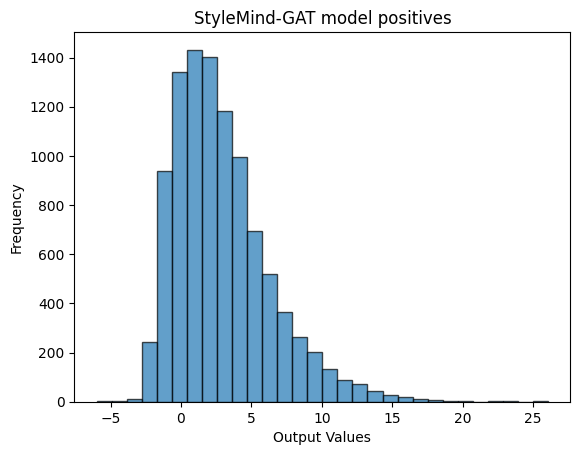

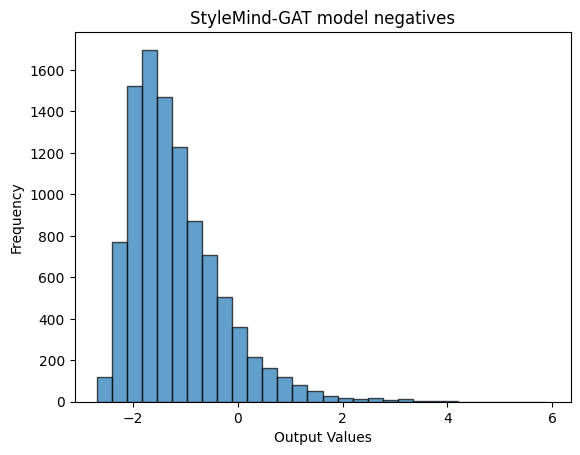

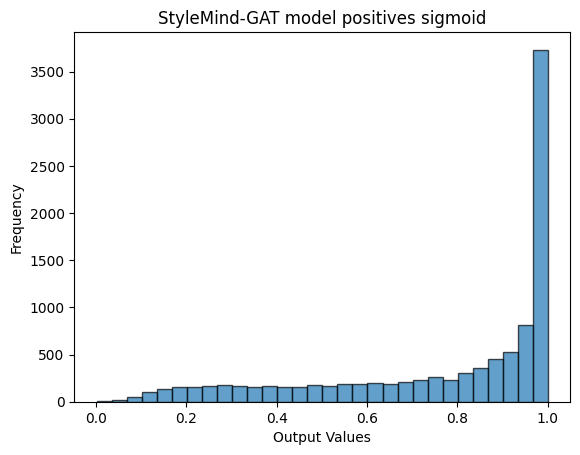

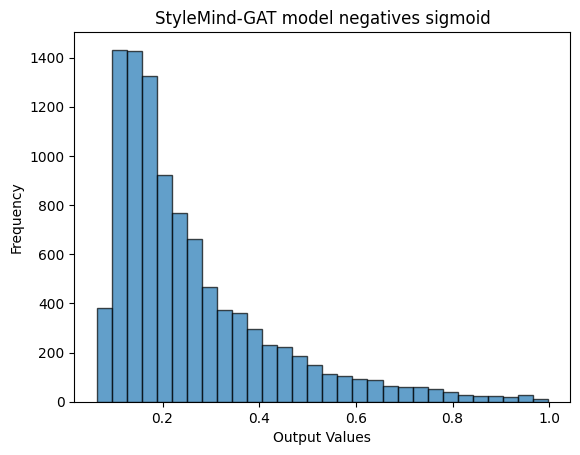

In [ ]:
plot_histogram(o[:o.shape[0]//2], "StyleMind-GAT model positives")
plot_histogram(o[o.shape[0]//2:], "StyleMind-GAT model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "StyleMind-GAT model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "StyleMind-GAT model negatives sigmoid")

In [ ]:
save_model(best_gat_model, datasets_path, "StyleMind-GAT.pth")

In [ ]:
torch.save(embd, path.join(datasets_path, "StyleMind-GAT_embeddings.pth"))

In [ ]:
free_cuda_memory(gat_model)
gc.collect()
torch.cuda.empty_cache()

In [ ]:
logistic_model = StyleMindGCN(2048, 128, 128, 1 , "MLP", 0 ,True).to(device)

In [ ]:
logistic_model.reset_parameters()

losses = []
test_accs = []

best_test_acc = 0
best_model = None

optimizer = optim.Adam(logistic_model.parameters(), 0.001)
loss_fn = nn.BCEWithLogitsLoss()

x = x.to(device)
datasplit = get_data_splits(1)

dataset = TensorDataset(datasplit['train']['outfits'], datasplit['train']['labels'])
dataloader = DataLoader(dataset, batch_size=16000, shuffle=True)

for epoch in range(1000):
  for batch_idx, (batch_data, batch_labels) in enumerate(tqdm(dataloader, desc='Processing Batches')):
      batch_data_edge_indices ,batch_data_indices= build_edge_indices_and_indices_with_groups(batch_data)
      batch_data_edge_indices ,batch_data_indices, batch_labels = batch_data_edge_indices.to(device) ,batch_data_indices.to(device), batch_labels.to(device)
      train_loss = train(logistic_model, x, datasplit['train']['message_passings'].to(device)
      , batch_data_edge_indices ,batch_data_indices, batch_labels,
                       loss_fn=loss_fn, optimizer=optimizer)

  train_acc = test(logistic_model, x, datasplit['train']['message_passings'].to(device)
  , batch_data_edge_indices ,batch_data_indices, batch_labels)

  valid_acc = test(logistic_model, x, datasplit['valid']['message_passings'].to(device)
  , datasplit['valid']['outfits_edge_indices'].to(device),
      datasplit['valid']['outfits_indices'].to(device), datasplit['valid']['labels'].to(device))
  test_acc = test(logistic_model, x, datasplit['test']['message_passings'].to(device)
  , datasplit['test']['outfits_edge_indices'].to(device),
      datasplit['test']['outfits_indices'].to(device), datasplit['test']['labels'].to(device))

  if(test_acc > best_test_acc):
      best_test_acc = test_acc
      best_model = copy.deepcopy(logistic_model)

  losses.append(train_loss)
  test_accs.append(test_acc)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {train_loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% '
        f'Test: {100 * test_acc:.2f}%')


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch: 00, Loss: 7.5367, Train: 49.50%, Valid: 35.38% Test: 34.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 01, Loss: 4.2134, Train: 49.53%, Valid: 36.51% Test: 35.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 02, Loss: 3.3747, Train: 50.48%, Valid: 33.16% Test: 32.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 03, Loss: 2.5437, Train: 50.75%, Valid: 31.96% Test: 31.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 04, Loss: 1.7757, Train: 51.09%, Valid: 31.11% Test: 30.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 05, Loss: 1.3225, Train: 52.15%, Valid: 30.65% Test: 30.23%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 06, Loss: 1.0018, Train: 52.99%, Valid: 31.65% Test: 31.33%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 07, Loss: 0.8354, Train: 55.16%, Valid: 33.24% Test: 32.13%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 08, Loss: 0.7485, Train: 57.28%, Valid: 35.26% Test: 34.40%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 09, Loss: 0.7160, Train: 58.54%, Valid: 37.79% Test: 37.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 10, Loss: 0.6748, Train: 61.33%, Valid: 40.43% Test: 40.32%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 11, Loss: 0.6608, Train: 62.34%, Valid: 43.25% Test: 43.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 12, Loss: 0.6500, Train: 63.64%, Valid: 46.55% Test: 46.70%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 13, Loss: 0.6403, Train: 65.74%, Valid: 49.55% Test: 50.15%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch: 14, Loss: 0.6297, Train: 65.95%, Valid: 52.10% Test: 52.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 15, Loss: 0.6250, Train: 67.18%, Valid: 55.36% Test: 56.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 16, Loss: 0.6200, Train: 67.92%, Valid: 57.59% Test: 58.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 17, Loss: 0.6072, Train: 68.66%, Valid: 60.43% Test: 61.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 18, Loss: 0.6112, Train: 68.70%, Valid: 61.52% Test: 62.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 19, Loss: 0.6025, Train: 69.23%, Valid: 62.04% Test: 62.52%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 20, Loss: 0.5939, Train: 70.39%, Valid: 63.87% Test: 64.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 21, Loss: 0.5916, Train: 70.17%, Valid: 65.08% Test: 65.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 22, Loss: 0.5855, Train: 70.23%, Valid: 67.41% Test: 67.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 23, Loss: 0.5798, Train: 70.56%, Valid: 68.49% Test: 69.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 24, Loss: 0.5764, Train: 71.52%, Valid: 69.05% Test: 69.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 25, Loss: 0.5799, Train: 70.83%, Valid: 69.54% Test: 70.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 26, Loss: 0.5782, Train: 71.46%, Valid: 70.02% Test: 70.67%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 27, Loss: 0.5720, Train: 71.60%, Valid: 71.34% Test: 71.92%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 28, Loss: 0.5630, Train: 72.57%, Valid: 71.46% Test: 72.07%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 29, Loss: 0.5638, Train: 72.14%, Valid: 72.42% Test: 72.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 30, Loss: 0.5613, Train: 72.45%, Valid: 71.81% Test: 72.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 31, Loss: 0.5549, Train: 73.25%, Valid: 73.09% Test: 73.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 32, Loss: 0.5566, Train: 72.84%, Valid: 72.93% Test: 73.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 33, Loss: 0.5533, Train: 73.08%, Valid: 73.63% Test: 74.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 34, Loss: 0.5530, Train: 73.26%, Valid: 73.94% Test: 74.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 35, Loss: 0.5480, Train: 73.44%, Valid: 74.47% Test: 75.01%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 36, Loss: 0.5497, Train: 73.18%, Valid: 74.85% Test: 75.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 37, Loss: 0.5521, Train: 73.61%, Valid: 75.00% Test: 75.80%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 38, Loss: 0.5412, Train: 74.05%, Valid: 75.21% Test: 75.86%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 39, Loss: 0.5406, Train: 73.77%, Valid: 75.46% Test: 76.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 40, Loss: 0.5427, Train: 74.17%, Valid: 75.36% Test: 76.15%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 41, Loss: 0.5454, Train: 74.03%, Valid: 75.97% Test: 76.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 42, Loss: 0.5335, Train: 74.51%, Valid: 76.20% Test: 76.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 43, Loss: 0.5371, Train: 73.89%, Valid: 76.11% Test: 76.78%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 44, Loss: 0.5342, Train: 74.89%, Valid: 76.43% Test: 76.90%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 45, Loss: 0.5336, Train: 74.31%, Valid: 76.71% Test: 77.17%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 46, Loss: 0.5360, Train: 74.51%, Valid: 76.64% Test: 77.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 47, Loss: 0.5358, Train: 73.94%, Valid: 76.73% Test: 77.28%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 48, Loss: 0.5332, Train: 74.64%, Valid: 76.83% Test: 77.36%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 49, Loss: 0.5245, Train: 75.31%, Valid: 77.14% Test: 77.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 50, Loss: 0.5329, Train: 74.77%, Valid: 77.16% Test: 77.72%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 51, Loss: 0.5280, Train: 74.66%, Valid: 77.49% Test: 77.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 52, Loss: 0.5202, Train: 75.43%, Valid: 77.13% Test: 77.29%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 53, Loss: 0.5242, Train: 75.43%, Valid: 77.57% Test: 77.93%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 54, Loss: 0.5206, Train: 75.53%, Valid: 77.32% Test: 78.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 55, Loss: 0.5131, Train: 76.20%, Valid: 77.77% Test: 78.13%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 56, Loss: 0.5195, Train: 74.99%, Valid: 77.52% Test: 77.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 57, Loss: 0.5158, Train: 75.57%, Valid: 77.82% Test: 78.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 58, Loss: 0.5181, Train: 76.01%, Valid: 78.00% Test: 78.37%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 59, Loss: 0.5110, Train: 76.41%, Valid: 77.77% Test: 78.08%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 60, Loss: 0.5100, Train: 76.06%, Valid: 77.89% Test: 78.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 61, Loss: 0.5145, Train: 76.26%, Valid: 78.23% Test: 78.48%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 62, Loss: 0.5110, Train: 76.16%, Valid: 77.60% Test: 78.27%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 63, Loss: 0.5149, Train: 76.04%, Valid: 78.13% Test: 78.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 64, Loss: 0.5165, Train: 75.53%, Valid: 78.11% Test: 78.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 65, Loss: 0.5126, Train: 76.18%, Valid: 77.59% Test: 78.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 66, Loss: 0.5131, Train: 76.07%, Valid: 78.45% Test: 78.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 67, Loss: 0.5155, Train: 76.29%, Valid: 78.27% Test: 78.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 68, Loss: 0.5017, Train: 76.61%, Valid: 78.49% Test: 78.71%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 69, Loss: 0.5037, Train: 76.23%, Valid: 77.83% Test: 78.09%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 70, Loss: 0.5055, Train: 76.36%, Valid: 78.37% Test: 78.85%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 71, Loss: 0.5059, Train: 76.71%, Valid: 78.38% Test: 78.54%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 72, Loss: 0.5010, Train: 76.88%, Valid: 78.50% Test: 78.83%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 73, Loss: 0.4967, Train: 77.11%, Valid: 78.52% Test: 78.92%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 74, Loss: 0.4990, Train: 76.61%, Valid: 78.26% Test: 78.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 75, Loss: 0.5035, Train: 76.66%, Valid: 78.25% Test: 78.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 76, Loss: 0.5078, Train: 76.42%, Valid: 78.50% Test: 78.94%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 77, Loss: 0.5064, Train: 76.64%, Valid: 78.15% Test: 78.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 78, Loss: 0.4963, Train: 76.71%, Valid: 78.69% Test: 79.14%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 79, Loss: 0.5002, Train: 76.96%, Valid: 78.65% Test: 78.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 80, Loss: 0.5013, Train: 76.59%, Valid: 78.89% Test: 79.17%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 81, Loss: 0.5045, Train: 76.46%, Valid: 78.74% Test: 79.03%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 82, Loss: 0.4932, Train: 77.62%, Valid: 77.99% Test: 78.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 83, Loss: 0.5003, Train: 76.62%, Valid: 78.62% Test: 79.03%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 84, Loss: 0.4995, Train: 76.84%, Valid: 78.26% Test: 78.99%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 85, Loss: 0.4953, Train: 77.07%, Valid: 78.62% Test: 79.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 86, Loss: 0.4837, Train: 78.27%, Valid: 78.64% Test: 79.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 87, Loss: 0.4859, Train: 77.75%, Valid: 78.88% Test: 79.16%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 88, Loss: 0.4978, Train: 77.13%, Valid: 78.33% Test: 78.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 89, Loss: 0.4893, Train: 77.59%, Valid: 78.45% Test: 79.14%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 90, Loss: 0.4943, Train: 77.35%, Valid: 78.44% Test: 79.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 91, Loss: 0.4913, Train: 77.77%, Valid: 78.95% Test: 78.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 92, Loss: 0.4978, Train: 76.83%, Valid: 77.92% Test: 78.88%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 93, Loss: 0.4849, Train: 78.18%, Valid: 79.18% Test: 79.37%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 94, Loss: 0.4878, Train: 77.68%, Valid: 78.98% Test: 79.16%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 95, Loss: 0.4846, Train: 77.98%, Valid: 78.65% Test: 79.19%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 96, Loss: 0.4880, Train: 77.32%, Valid: 78.20% Test: 78.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 97, Loss: 0.4899, Train: 77.64%, Valid: 79.12% Test: 79.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 98, Loss: 0.4723, Train: 78.63%, Valid: 79.23% Test: 79.58%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 99, Loss: 0.4834, Train: 78.14%, Valid: 78.74% Test: 79.13%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 100, Loss: 0.4773, Train: 78.35%, Valid: 78.37% Test: 79.09%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 101, Loss: 0.4740, Train: 79.03%, Valid: 78.78% Test: 79.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 102, Loss: 0.4795, Train: 78.49%, Valid: 78.93% Test: 79.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 103, Loss: 0.4804, Train: 78.46%, Valid: 79.03% Test: 79.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 104, Loss: 0.4819, Train: 78.01%, Valid: 78.97% Test: 79.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 105, Loss: 0.4834, Train: 78.15%, Valid: 79.11% Test: 79.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 106, Loss: 0.4765, Train: 78.81%, Valid: 79.11% Test: 79.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 107, Loss: 0.4758, Train: 78.85%, Valid: 78.62% Test: 79.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 108, Loss: 0.4748, Train: 78.45%, Valid: 79.44% Test: 79.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 109, Loss: 0.4833, Train: 78.01%, Valid: 78.75% Test: 79.24%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 110, Loss: 0.4776, Train: 79.01%, Valid: 78.99% Test: 79.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 111, Loss: 0.4816, Train: 78.18%, Valid: 79.28% Test: 79.78%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 112, Loss: 0.4708, Train: 78.66%, Valid: 78.96% Test: 79.59%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 113, Loss: 0.4746, Train: 78.46%, Valid: 79.19% Test: 79.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 114, Loss: 0.4696, Train: 78.86%, Valid: 79.26% Test: 79.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 115, Loss: 0.4706, Train: 78.90%, Valid: 79.13% Test: 79.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 116, Loss: 0.4793, Train: 78.17%, Valid: 79.23% Test: 79.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 117, Loss: 0.4668, Train: 79.42%, Valid: 78.87% Test: 79.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 118, Loss: 0.4795, Train: 78.65%, Valid: 79.39% Test: 79.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 119, Loss: 0.4712, Train: 78.66%, Valid: 79.40% Test: 79.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 120, Loss: 0.4679, Train: 79.04%, Valid: 78.93% Test: 79.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 121, Loss: 0.4616, Train: 79.33%, Valid: 78.90% Test: 79.45%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 122, Loss: 0.4729, Train: 78.77%, Valid: 79.06% Test: 79.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 123, Loss: 0.4704, Train: 78.51%, Valid: 79.35% Test: 79.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 124, Loss: 0.4563, Train: 79.51%, Valid: 79.29% Test: 79.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 125, Loss: 0.4582, Train: 79.96%, Valid: 79.38% Test: 79.87%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 126, Loss: 0.4611, Train: 79.41%, Valid: 78.85% Test: 79.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 127, Loss: 0.4626, Train: 79.88%, Valid: 79.54% Test: 80.09%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 128, Loss: 0.4626, Train: 79.16%, Valid: 79.18% Test: 79.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 129, Loss: 0.4688, Train: 79.05%, Valid: 78.90% Test: 79.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 130, Loss: 0.4601, Train: 79.35%, Valid: 79.15% Test: 79.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 131, Loss: 0.4577, Train: 79.66%, Valid: 79.61% Test: 80.13%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 132, Loss: 0.4565, Train: 80.01%, Valid: 79.61% Test: 79.91%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 133, Loss: 0.4609, Train: 79.40%, Valid: 79.69% Test: 80.22%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 134, Loss: 0.4612, Train: 79.27%, Valid: 79.52% Test: 79.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 135, Loss: 0.4582, Train: 79.08%, Valid: 79.65% Test: 80.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 136, Loss: 0.4575, Train: 79.89%, Valid: 79.66% Test: 80.23%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 137, Loss: 0.4574, Train: 79.09%, Valid: 78.78% Test: 79.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 138, Loss: 0.4597, Train: 79.84%, Valid: 79.34% Test: 79.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 139, Loss: 0.4589, Train: 79.74%, Valid: 79.90% Test: 80.03%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 140, Loss: 0.4661, Train: 78.74%, Valid: 79.38% Test: 80.20%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 141, Loss: 0.4579, Train: 79.29%, Valid: 79.42% Test: 80.06%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 142, Loss: 0.4562, Train: 79.80%, Valid: 79.19% Test: 80.02%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 143, Loss: 0.4562, Train: 79.91%, Valid: 79.04% Test: 79.57%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 144, Loss: 0.4607, Train: 79.17%, Valid: 79.12% Test: 79.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 145, Loss: 0.4515, Train: 79.76%, Valid: 79.33% Test: 80.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 146, Loss: 0.4489, Train: 79.79%, Valid: 79.87% Test: 80.45%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 147, Loss: 0.4510, Train: 80.00%, Valid: 79.59% Test: 80.10%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 148, Loss: 0.4435, Train: 80.55%, Valid: 79.69% Test: 80.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 149, Loss: 0.4509, Train: 80.25%, Valid: 79.52% Test: 80.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 150, Loss: 0.4533, Train: 79.33%, Valid: 79.36% Test: 79.88%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 151, Loss: 0.4481, Train: 80.14%, Valid: 79.67% Test: 79.95%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 152, Loss: 0.4560, Train: 79.80%, Valid: 79.61% Test: 80.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 153, Loss: 0.4440, Train: 80.31%, Valid: 79.29% Test: 79.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 154, Loss: 0.4480, Train: 79.84%, Valid: 79.15% Test: 79.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 155, Loss: 0.4456, Train: 80.11%, Valid: 79.27% Test: 79.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 156, Loss: 0.4518, Train: 80.19%, Valid: 79.16% Test: 79.81%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 157, Loss: 0.4464, Train: 80.24%, Valid: 79.44% Test: 80.13%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 158, Loss: 0.4431, Train: 80.15%, Valid: 79.89% Test: 80.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 159, Loss: 0.4535, Train: 79.47%, Valid: 79.75% Test: 80.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 160, Loss: 0.4412, Train: 80.31%, Valid: 79.87% Test: 80.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 161, Loss: 0.4468, Train: 79.96%, Valid: 79.47% Test: 80.24%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 162, Loss: 0.4375, Train: 80.54%, Valid: 79.67% Test: 80.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 163, Loss: 0.4432, Train: 80.54%, Valid: 79.79% Test: 80.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 164, Loss: 0.4489, Train: 79.80%, Valid: 79.13% Test: 79.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 165, Loss: 0.4351, Train: 80.97%, Valid: 78.96% Test: 79.52%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 166, Loss: 0.4462, Train: 80.21%, Valid: 79.67% Test: 80.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 167, Loss: 0.4449, Train: 80.34%, Valid: 79.76% Test: 80.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 168, Loss: 0.4324, Train: 80.61%, Valid: 79.41% Test: 80.36%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 169, Loss: 0.4445, Train: 80.31%, Valid: 79.87% Test: 80.60%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 170, Loss: 0.4376, Train: 81.00%, Valid: 79.63% Test: 80.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 171, Loss: 0.4427, Train: 80.66%, Valid: 79.55% Test: 80.42%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 172, Loss: 0.4381, Train: 80.41%, Valid: 79.97% Test: 80.56%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 173, Loss: 0.4317, Train: 80.97%, Valid: 79.80% Test: 80.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 174, Loss: 0.4446, Train: 80.45%, Valid: 79.48% Test: 80.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 175, Loss: 0.4431, Train: 80.75%, Valid: 79.43% Test: 80.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 176, Loss: 0.4305, Train: 81.34%, Valid: 79.92% Test: 80.12%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 177, Loss: 0.4349, Train: 80.96%, Valid: 79.21% Test: 80.06%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 178, Loss: 0.4324, Train: 81.28%, Valid: 79.44% Test: 80.09%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 179, Loss: 0.4391, Train: 80.92%, Valid: 79.27% Test: 79.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 180, Loss: 0.4339, Train: 80.68%, Valid: 79.72% Test: 80.68%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 181, Loss: 0.4462, Train: 80.55%, Valid: 79.99% Test: 80.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 182, Loss: 0.4350, Train: 81.13%, Valid: 79.68% Test: 80.59%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 183, Loss: 0.4295, Train: 81.63%, Valid: 79.67% Test: 80.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 184, Loss: 0.4340, Train: 80.38%, Valid: 80.06% Test: 80.61%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch: 185, Loss: 0.4194, Train: 81.45%, Valid: 79.93% Test: 80.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 186, Loss: 0.4254, Train: 81.24%, Valid: 79.74% Test: 80.70%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 187, Loss: 0.4238, Train: 81.29%, Valid: 80.11% Test: 80.79%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 188, Loss: 0.4208, Train: 81.88%, Valid: 80.17% Test: 80.83%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 189, Loss: 0.4241, Train: 81.15%, Valid: 79.76% Test: 80.65%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 190, Loss: 0.4223, Train: 80.71%, Valid: 79.38% Test: 79.92%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 191, Loss: 0.4251, Train: 80.70%, Valid: 79.64% Test: 80.34%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 192, Loss: 0.4283, Train: 81.14%, Valid: 80.04% Test: 80.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 193, Loss: 0.4238, Train: 81.83%, Valid: 79.47% Test: 80.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 194, Loss: 0.4236, Train: 81.71%, Valid: 79.97% Test: 80.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 195, Loss: 0.4279, Train: 81.23%, Valid: 80.03% Test: 80.33%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 196, Loss: 0.4192, Train: 81.50%, Valid: 79.93% Test: 80.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 197, Loss: 0.4295, Train: 81.43%, Valid: 79.90% Test: 80.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 198, Loss: 0.4286, Train: 81.10%, Valid: 79.23% Test: 80.13%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 199, Loss: 0.4288, Train: 81.06%, Valid: 79.54% Test: 80.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 200, Loss: 0.4216, Train: 81.29%, Valid: 79.40% Test: 80.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 201, Loss: 0.4215, Train: 80.46%, Valid: 79.11% Test: 79.89%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 202, Loss: 0.4280, Train: 81.36%, Valid: 79.98% Test: 80.92%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 203, Loss: 0.4238, Train: 81.67%, Valid: 79.80% Test: 80.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 204, Loss: 0.4265, Train: 81.33%, Valid: 79.77% Test: 80.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 205, Loss: 0.4193, Train: 81.51%, Valid: 79.96% Test: 80.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 206, Loss: 0.4210, Train: 82.08%, Valid: 80.07% Test: 81.22%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 207, Loss: 0.4177, Train: 81.81%, Valid: 79.81% Test: 80.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 208, Loss: 0.4199, Train: 81.56%, Valid: 79.64% Test: 79.96%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 209, Loss: 0.4153, Train: 82.20%, Valid: 80.08% Test: 80.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 210, Loss: 0.4215, Train: 82.03%, Valid: 79.61% Test: 80.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 211, Loss: 0.4168, Train: 81.62%, Valid: 80.04% Test: 80.76%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 212, Loss: 0.4226, Train: 81.90%, Valid: 79.76% Test: 80.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 213, Loss: 0.4136, Train: 81.87%, Valid: 80.14% Test: 81.06%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 214, Loss: 0.4205, Train: 81.65%, Valid: 80.07% Test: 81.03%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 215, Loss: 0.4119, Train: 82.15%, Valid: 79.95% Test: 80.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 216, Loss: 0.4218, Train: 81.57%, Valid: 78.86% Test: 79.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 217, Loss: 0.4188, Train: 81.70%, Valid: 79.63% Test: 80.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 218, Loss: 0.4169, Train: 81.70%, Valid: 79.92% Test: 80.43%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 219, Loss: 0.4156, Train: 82.18%, Valid: 79.85% Test: 80.68%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 220, Loss: 0.4142, Train: 82.39%, Valid: 79.44% Test: 80.12%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 221, Loss: 0.4190, Train: 81.62%, Valid: 80.47% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 222, Loss: 0.4213, Train: 81.17%, Valid: 79.97% Test: 80.82%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 223, Loss: 0.4132, Train: 81.88%, Valid: 79.66% Test: 80.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 224, Loss: 0.4133, Train: 81.66%, Valid: 80.05% Test: 80.87%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 225, Loss: 0.4108, Train: 82.08%, Valid: 80.41% Test: 81.33%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 226, Loss: 0.4104, Train: 81.84%, Valid: 80.29% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 227, Loss: 0.4069, Train: 82.43%, Valid: 80.33% Test: 80.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 228, Loss: 0.4059, Train: 82.28%, Valid: 79.66% Test: 80.21%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 229, Loss: 0.4136, Train: 81.69%, Valid: 79.47% Test: 80.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 230, Loss: 0.4143, Train: 81.93%, Valid: 79.57% Test: 80.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 231, Loss: 0.4127, Train: 82.21%, Valid: 79.51% Test: 80.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 232, Loss: 0.4065, Train: 81.94%, Valid: 79.34% Test: 80.23%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 233, Loss: 0.4150, Train: 82.09%, Valid: 79.98% Test: 81.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 234, Loss: 0.4033, Train: 82.72%, Valid: 80.24% Test: 81.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 235, Loss: 0.4084, Train: 81.66%, Valid: 79.68% Test: 80.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 236, Loss: 0.4100, Train: 82.38%, Valid: 79.31% Test: 80.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 237, Loss: 0.4074, Train: 81.96%, Valid: 79.22% Test: 79.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 238, Loss: 0.4015, Train: 82.50%, Valid: 79.90% Test: 80.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 239, Loss: 0.4068, Train: 82.87%, Valid: 80.08% Test: 80.88%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 240, Loss: 0.4030, Train: 82.11%, Valid: 79.74% Test: 80.33%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 241, Loss: 0.4047, Train: 82.32%, Valid: 79.55% Test: 80.50%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


Epoch: 242, Loss: 0.4022, Train: 82.46%, Valid: 79.41% Test: 79.96%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 243, Loss: 0.4033, Train: 82.92%, Valid: 80.23% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 244, Loss: 0.4079, Train: 82.10%, Valid: 80.74% Test: 81.33%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 245, Loss: 0.3977, Train: 82.83%, Valid: 80.17% Test: 80.76%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 246, Loss: 0.3972, Train: 82.81%, Valid: 79.49% Test: 80.00%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 247, Loss: 0.3973, Train: 83.13%, Valid: 80.13% Test: 80.80%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 248, Loss: 0.4011, Train: 82.98%, Valid: 79.90% Test: 80.81%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 249, Loss: 0.3946, Train: 82.89%, Valid: 79.93% Test: 81.07%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 250, Loss: 0.3990, Train: 83.04%, Valid: 80.47% Test: 81.11%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch: 251, Loss: 0.4033, Train: 82.36%, Valid: 80.35% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 252, Loss: 0.4011, Train: 82.52%, Valid: 80.30% Test: 81.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 253, Loss: 0.3994, Train: 83.01%, Valid: 79.20% Test: 80.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 254, Loss: 0.4040, Train: 82.75%, Valid: 80.02% Test: 80.86%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 255, Loss: 0.3972, Train: 82.92%, Valid: 80.04% Test: 80.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 256, Loss: 0.3984, Train: 82.81%, Valid: 80.28% Test: 80.85%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 257, Loss: 0.4013, Train: 82.37%, Valid: 80.31% Test: 80.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 258, Loss: 0.3957, Train: 83.04%, Valid: 80.42% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 259, Loss: 0.4024, Train: 82.29%, Valid: 80.04% Test: 80.96%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 260, Loss: 0.4040, Train: 81.93%, Valid: 79.21% Test: 80.46%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 261, Loss: 0.3908, Train: 82.70%, Valid: 79.02% Test: 80.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 262, Loss: 0.3900, Train: 82.68%, Valid: 79.74% Test: 80.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 263, Loss: 0.3963, Train: 82.67%, Valid: 80.31% Test: 81.03%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 264, Loss: 0.3910, Train: 83.32%, Valid: 80.17% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 265, Loss: 0.3920, Train: 83.08%, Valid: 80.06% Test: 80.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 266, Loss: 0.3832, Train: 83.79%, Valid: 80.33% Test: 80.94%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 267, Loss: 0.3947, Train: 83.15%, Valid: 80.39% Test: 81.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 268, Loss: 0.3988, Train: 82.60%, Valid: 80.36% Test: 81.37%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 269, Loss: 0.3905, Train: 83.34%, Valid: 80.03% Test: 81.08%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 270, Loss: 0.3913, Train: 83.02%, Valid: 80.11% Test: 80.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 271, Loss: 0.3887, Train: 82.81%, Valid: 79.60% Test: 80.12%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 272, Loss: 0.3892, Train: 82.44%, Valid: 78.50% Test: 79.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 273, Loss: 0.4010, Train: 83.05%, Valid: 80.47% Test: 81.02%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 274, Loss: 0.3938, Train: 82.92%, Valid: 79.70% Test: 80.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 275, Loss: 0.4016, Train: 82.64%, Valid: 80.09% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 276, Loss: 0.3831, Train: 83.35%, Valid: 79.56% Test: 80.30%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 277, Loss: 0.3978, Train: 82.73%, Valid: 78.99% Test: 80.05%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 278, Loss: 0.3963, Train: 83.47%, Valid: 79.77% Test: 80.55%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 279, Loss: 0.3963, Train: 81.81%, Valid: 76.65% Test: 77.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 280, Loss: 0.4065, Train: 81.77%, Valid: 76.62% Test: 77.27%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 281, Loss: 0.4126, Train: 81.50%, Valid: 78.13% Test: 78.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 282, Loss: 0.4430, Train: 81.31%, Valid: 77.73% Test: 78.02%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 283, Loss: 14.2976, Train: 49.43%, Valid: 50.00% Test: 50.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 284, Loss: 5.8039, Train: 50.02%, Valid: 49.91% Test: 49.91%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 285, Loss: 1.4393, Train: 54.22%, Valid: 46.81% Test: 46.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 286, Loss: 8.0789, Train: 51.82%, Valid: 47.58% Test: 47.56%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 287, Loss: 2.1240, Train: 50.14%, Valid: 49.92% Test: 49.91%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 288, Loss: 3.5134, Train: 53.28%, Valid: 43.26% Test: 42.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 289, Loss: 2.8219, Train: 57.55%, Valid: 36.36% Test: 35.97%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 290, Loss: 1.8834, Train: 62.57%, Valid: 34.94% Test: 35.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 291, Loss: 1.0429, Train: 68.57%, Valid: 41.50% Test: 42.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 292, Loss: 0.6934, Train: 74.33%, Valid: 51.05% Test: 51.55%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 293, Loss: 0.5482, Train: 77.20%, Valid: 57.35% Test: 58.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 294, Loss: 0.4875, Train: 79.30%, Valid: 64.53% Test: 65.83%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 295, Loss: 0.4512, Train: 80.38%, Valid: 68.08% Test: 69.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 296, Loss: 0.4310, Train: 80.54%, Valid: 70.43% Test: 71.46%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Epoch: 297, Loss: 0.4163, Train: 81.70%, Valid: 72.25% Test: 72.90%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 298, Loss: 0.4021, Train: 82.76%, Valid: 73.12% Test: 73.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 299, Loss: 0.4110, Train: 81.83%, Valid: 73.63% Test: 74.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 300, Loss: 0.3858, Train: 83.31%, Valid: 74.22% Test: 75.24%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 301, Loss: 0.3991, Train: 82.51%, Valid: 74.85% Test: 75.96%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 302, Loss: 0.3869, Train: 83.10%, Valid: 75.35% Test: 76.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 303, Loss: 0.3931, Train: 82.93%, Valid: 75.81% Test: 76.87%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 304, Loss: 0.3850, Train: 83.58%, Valid: 76.20% Test: 77.19%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 305, Loss: 0.3906, Train: 82.96%, Valid: 76.46% Test: 77.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 306, Loss: 0.3799, Train: 83.28%, Valid: 76.75% Test: 77.62%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 307, Loss: 0.3906, Train: 82.92%, Valid: 76.86% Test: 77.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 308, Loss: 0.3851, Train: 83.41%, Valid: 77.20% Test: 78.03%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 309, Loss: 0.3916, Train: 82.83%, Valid: 77.45% Test: 78.36%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 310, Loss: 0.3809, Train: 83.53%, Valid: 77.66% Test: 78.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 311, Loss: 0.3743, Train: 83.71%, Valid: 77.76% Test: 78.63%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 312, Loss: 0.3731, Train: 83.84%, Valid: 78.07% Test: 78.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 313, Loss: 0.3879, Train: 83.07%, Valid: 78.09% Test: 79.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 314, Loss: 0.3745, Train: 83.34%, Valid: 78.54% Test: 79.17%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 315, Loss: 0.3728, Train: 83.94%, Valid: 78.27% Test: 79.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 316, Loss: 0.3774, Train: 83.55%, Valid: 78.53% Test: 79.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 317, Loss: 0.3794, Train: 83.56%, Valid: 78.67% Test: 79.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 318, Loss: 0.3727, Train: 83.67%, Valid: 78.66% Test: 79.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 319, Loss: 0.3797, Train: 83.65%, Valid: 78.78% Test: 79.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 320, Loss: 0.3729, Train: 83.85%, Valid: 79.13% Test: 79.69%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 321, Loss: 0.3838, Train: 83.36%, Valid: 78.95% Test: 79.88%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 322, Loss: 0.3763, Train: 83.35%, Valid: 79.12% Test: 79.98%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 323, Loss: 0.3708, Train: 84.10%, Valid: 79.28% Test: 79.91%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 324, Loss: 0.3785, Train: 83.42%, Valid: 79.17% Test: 79.95%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 325, Loss: 0.3694, Train: 84.18%, Valid: 79.15% Test: 79.78%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 326, Loss: 0.3747, Train: 83.81%, Valid: 79.33% Test: 80.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 327, Loss: 0.3819, Train: 83.35%, Valid: 79.50% Test: 80.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 328, Loss: 0.3783, Train: 83.09%, Valid: 79.45% Test: 80.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 329, Loss: 0.3763, Train: 83.88%, Valid: 79.57% Test: 80.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 330, Loss: 0.3822, Train: 82.96%, Valid: 79.64% Test: 80.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 331, Loss: 0.3710, Train: 83.98%, Valid: 79.78% Test: 80.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 332, Loss: 0.3715, Train: 83.74%, Valid: 79.36% Test: 80.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 333, Loss: 0.3776, Train: 83.90%, Valid: 79.56% Test: 80.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 334, Loss: 0.3711, Train: 83.83%, Valid: 79.48% Test: 80.32%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 335, Loss: 0.3849, Train: 83.14%, Valid: 79.58% Test: 80.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 336, Loss: 0.3698, Train: 84.23%, Valid: 79.89% Test: 80.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 337, Loss: 0.3740, Train: 83.78%, Valid: 79.83% Test: 80.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 338, Loss: 0.3726, Train: 83.91%, Valid: 79.95% Test: 80.76%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 339, Loss: 0.3666, Train: 84.11%, Valid: 80.03% Test: 80.76%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 340, Loss: 0.3781, Train: 83.61%, Valid: 80.08% Test: 80.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 341, Loss: 0.3719, Train: 84.13%, Valid: 79.94% Test: 80.52%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 342, Loss: 0.3719, Train: 84.09%, Valid: 80.16% Test: 80.89%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 343, Loss: 0.3753, Train: 84.13%, Valid: 80.09% Test: 80.88%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 344, Loss: 0.3765, Train: 83.60%, Valid: 80.11% Test: 80.94%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 345, Loss: 0.3639, Train: 84.45%, Valid: 80.10% Test: 80.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 346, Loss: 0.3701, Train: 83.86%, Valid: 80.19% Test: 80.94%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 347, Loss: 0.3721, Train: 83.37%, Valid: 80.23% Test: 80.69%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 348, Loss: 0.3745, Train: 83.96%, Valid: 80.45% Test: 80.85%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 349, Loss: 0.3790, Train: 83.71%, Valid: 80.07% Test: 81.11%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 350, Loss: 0.3684, Train: 84.34%, Valid: 80.42% Test: 80.98%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 351, Loss: 0.3703, Train: 84.30%, Valid: 80.38% Test: 80.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 352, Loss: 0.3699, Train: 84.10%, Valid: 80.33% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 353, Loss: 0.3740, Train: 83.88%, Valid: 80.28% Test: 80.89%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 354, Loss: 0.3716, Train: 83.42%, Valid: 80.38% Test: 81.16%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 355, Loss: 0.3657, Train: 84.49%, Valid: 80.32% Test: 80.92%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 356, Loss: 0.3747, Train: 83.89%, Valid: 80.42% Test: 81.13%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 357, Loss: 0.3670, Train: 84.35%, Valid: 80.41% Test: 81.00%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 358, Loss: 0.3694, Train: 84.12%, Valid: 80.37% Test: 81.03%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 359, Loss: 0.3724, Train: 83.89%, Valid: 80.44% Test: 81.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 360, Loss: 0.3725, Train: 83.69%, Valid: 80.45% Test: 81.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 361, Loss: 0.3755, Train: 83.78%, Valid: 80.48% Test: 81.10%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 362, Loss: 0.3710, Train: 84.03%, Valid: 80.51% Test: 81.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 363, Loss: 0.3679, Train: 84.28%, Valid: 80.35% Test: 80.86%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 364, Loss: 0.3731, Train: 83.98%, Valid: 80.36% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 365, Loss: 0.3629, Train: 84.41%, Valid: 80.13% Test: 80.86%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 366, Loss: 0.3737, Train: 84.15%, Valid: 80.62% Test: 81.14%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 367, Loss: 0.3709, Train: 84.38%, Valid: 80.45% Test: 81.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 368, Loss: 0.3728, Train: 83.92%, Valid: 80.45% Test: 81.04%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 369, Loss: 0.3697, Train: 84.02%, Valid: 80.40% Test: 81.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 370, Loss: 0.3675, Train: 84.24%, Valid: 80.64% Test: 81.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 371, Loss: 0.3664, Train: 84.72%, Valid: 80.76% Test: 81.33%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 372, Loss: 0.3758, Train: 83.43%, Valid: 80.71% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 373, Loss: 0.3715, Train: 83.91%, Valid: 80.74% Test: 81.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 374, Loss: 0.3675, Train: 84.24%, Valid: 80.79% Test: 81.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 375, Loss: 0.3681, Train: 84.35%, Valid: 80.69% Test: 81.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 376, Loss: 0.3710, Train: 84.29%, Valid: 80.58% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 377, Loss: 0.3726, Train: 83.90%, Valid: 80.79% Test: 81.30%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 378, Loss: 0.3718, Train: 84.27%, Valid: 80.76% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 379, Loss: 0.3646, Train: 84.68%, Valid: 80.66% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 380, Loss: 0.3632, Train: 84.56%, Valid: 80.85% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 381, Loss: 0.3715, Train: 83.67%, Valid: 80.85% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 382, Loss: 0.3695, Train: 84.01%, Valid: 80.80% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 383, Loss: 0.3722, Train: 84.00%, Valid: 80.79% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 384, Loss: 0.3715, Train: 84.11%, Valid: 80.97% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 385, Loss: 0.3688, Train: 84.15%, Valid: 80.66% Test: 81.22%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 386, Loss: 0.3747, Train: 83.68%, Valid: 80.56% Test: 81.17%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 387, Loss: 0.3648, Train: 84.48%, Valid: 80.73% Test: 81.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 388, Loss: 0.3662, Train: 84.65%, Valid: 80.77% Test: 81.30%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 389, Loss: 0.3590, Train: 84.98%, Valid: 80.75% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 390, Loss: 0.3676, Train: 84.21%, Valid: 80.98% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 391, Loss: 0.3685, Train: 84.00%, Valid: 80.74% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 392, Loss: 0.3592, Train: 84.99%, Valid: 80.93% Test: 81.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 393, Loss: 0.3679, Train: 84.24%, Valid: 80.79% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 394, Loss: 0.3668, Train: 84.38%, Valid: 80.91% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 395, Loss: 0.3629, Train: 84.12%, Valid: 80.89% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 396, Loss: 0.3666, Train: 84.57%, Valid: 80.94% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


Epoch: 397, Loss: 0.3732, Train: 83.79%, Valid: 80.84% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 398, Loss: 0.3636, Train: 84.43%, Valid: 81.11% Test: 81.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 399, Loss: 0.3632, Train: 84.76%, Valid: 80.69% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 400, Loss: 0.3686, Train: 84.32%, Valid: 81.22% Test: 81.69%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 401, Loss: 0.3666, Train: 84.12%, Valid: 80.89% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 402, Loss: 0.3635, Train: 84.40%, Valid: 80.62% Test: 81.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 403, Loss: 0.3697, Train: 84.04%, Valid: 80.72% Test: 81.33%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 404, Loss: 0.3697, Train: 83.99%, Valid: 80.76% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 405, Loss: 0.3650, Train: 84.76%, Valid: 80.86% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 406, Loss: 0.3611, Train: 85.01%, Valid: 80.48% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 407, Loss: 0.3693, Train: 84.11%, Valid: 80.63% Test: 81.21%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 408, Loss: 0.3625, Train: 84.80%, Valid: 80.62% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 409, Loss: 0.3594, Train: 84.82%, Valid: 80.73% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 410, Loss: 0.3702, Train: 84.17%, Valid: 80.95% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 411, Loss: 0.3656, Train: 84.07%, Valid: 81.20% Test: 81.66%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 412, Loss: 0.3635, Train: 84.76%, Valid: 80.85% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 413, Loss: 0.3614, Train: 84.89%, Valid: 81.05% Test: 81.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 414, Loss: 0.3642, Train: 84.78%, Valid: 80.89% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 415, Loss: 0.3564, Train: 84.65%, Valid: 80.63% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 416, Loss: 0.3602, Train: 84.72%, Valid: 81.00% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 417, Loss: 0.3672, Train: 84.11%, Valid: 80.84% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 418, Loss: 0.3621, Train: 84.44%, Valid: 80.80% Test: 81.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 419, Loss: 0.3577, Train: 84.90%, Valid: 80.96% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 420, Loss: 0.3661, Train: 84.07%, Valid: 80.87% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 421, Loss: 0.3669, Train: 84.06%, Valid: 81.14% Test: 81.76%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 422, Loss: 0.3673, Train: 84.02%, Valid: 81.19% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 423, Loss: 0.3575, Train: 84.59%, Valid: 81.08% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 424, Loss: 0.3581, Train: 84.79%, Valid: 81.08% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 425, Loss: 0.3631, Train: 84.51%, Valid: 80.78% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 426, Loss: 0.3615, Train: 84.58%, Valid: 80.78% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 427, Loss: 0.3609, Train: 84.89%, Valid: 80.98% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 428, Loss: 0.3592, Train: 84.85%, Valid: 80.91% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 429, Loss: 0.3652, Train: 84.08%, Valid: 81.23% Test: 81.80%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 430, Loss: 0.3570, Train: 84.81%, Valid: 80.59% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 431, Loss: 0.3578, Train: 84.43%, Valid: 80.79% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 432, Loss: 0.3646, Train: 84.41%, Valid: 80.92% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 433, Loss: 0.3679, Train: 84.15%, Valid: 80.85% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 434, Loss: 0.3629, Train: 84.23%, Valid: 81.12% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 435, Loss: 0.3591, Train: 84.97%, Valid: 80.95% Test: 81.69%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 436, Loss: 0.3735, Train: 83.76%, Valid: 81.15% Test: 81.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 437, Loss: 0.3523, Train: 85.57%, Valid: 80.95% Test: 81.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 438, Loss: 0.3583, Train: 84.96%, Valid: 80.99% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 439, Loss: 0.3556, Train: 85.04%, Valid: 80.75% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 440, Loss: 0.3598, Train: 84.65%, Valid: 80.87% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Epoch: 441, Loss: 0.3606, Train: 84.81%, Valid: 81.16% Test: 81.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 442, Loss: 0.3631, Train: 84.29%, Valid: 80.95% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 443, Loss: 0.3606, Train: 84.67%, Valid: 80.85% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 444, Loss: 0.3673, Train: 84.56%, Valid: 80.86% Test: 81.55%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 445, Loss: 0.3584, Train: 84.94%, Valid: 80.77% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 446, Loss: 0.3556, Train: 85.00%, Valid: 81.08% Test: 81.62%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 447, Loss: 0.3646, Train: 84.41%, Valid: 81.10% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 448, Loss: 0.3567, Train: 84.68%, Valid: 80.88% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 449, Loss: 0.3648, Train: 84.60%, Valid: 80.80% Test: 81.32%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 450, Loss: 0.3505, Train: 85.47%, Valid: 81.04% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 451, Loss: 0.3591, Train: 84.81%, Valid: 81.06% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 452, Loss: 0.3605, Train: 85.08%, Valid: 81.12% Test: 81.59%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 453, Loss: 0.3640, Train: 84.72%, Valid: 80.84% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 454, Loss: 0.3635, Train: 84.28%, Valid: 81.26% Test: 81.68%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 455, Loss: 0.3539, Train: 84.92%, Valid: 81.04% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 456, Loss: 0.3602, Train: 84.73%, Valid: 80.86% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 457, Loss: 0.3563, Train: 85.02%, Valid: 81.00% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 458, Loss: 0.3531, Train: 85.31%, Valid: 81.09% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


Epoch: 459, Loss: 0.3663, Train: 84.87%, Valid: 81.22% Test: 81.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 460, Loss: 0.3552, Train: 84.89%, Valid: 81.02% Test: 81.62%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 461, Loss: 0.3543, Train: 85.14%, Valid: 81.13% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 462, Loss: 0.3605, Train: 84.86%, Valid: 81.31% Test: 81.74%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 463, Loss: 0.3584, Train: 84.93%, Valid: 81.20% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 464, Loss: 0.3495, Train: 85.42%, Valid: 80.74% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Epoch: 465, Loss: 0.3568, Train: 85.06%, Valid: 81.05% Test: 81.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 466, Loss: 0.3576, Train: 84.27%, Valid: 81.11% Test: 81.73%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 467, Loss: 0.3494, Train: 84.98%, Valid: 81.26% Test: 81.66%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 468, Loss: 0.3592, Train: 84.63%, Valid: 80.76% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 469, Loss: 0.3603, Train: 84.89%, Valid: 81.11% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 470, Loss: 0.3554, Train: 84.87%, Valid: 80.78% Test: 81.30%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 471, Loss: 0.3510, Train: 85.29%, Valid: 81.32% Test: 81.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 472, Loss: 0.3485, Train: 85.52%, Valid: 80.79% Test: 81.34%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 473, Loss: 0.3552, Train: 84.54%, Valid: 80.60% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 474, Loss: 0.3534, Train: 85.24%, Valid: 81.16% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 475, Loss: 0.3536, Train: 85.05%, Valid: 80.84% Test: 81.62%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 476, Loss: 0.3576, Train: 84.88%, Valid: 81.18% Test: 81.68%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 477, Loss: 0.3565, Train: 85.03%, Valid: 81.13% Test: 81.59%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 478, Loss: 0.3524, Train: 84.93%, Valid: 81.10% Test: 81.71%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 479, Loss: 0.3531, Train: 85.09%, Valid: 81.34% Test: 81.72%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 480, Loss: 0.3536, Train: 85.21%, Valid: 80.96% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 481, Loss: 0.3493, Train: 85.49%, Valid: 80.98% Test: 81.62%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 482, Loss: 0.3507, Train: 85.16%, Valid: 80.73% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 483, Loss: 0.3602, Train: 84.58%, Valid: 81.02% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 484, Loss: 0.3496, Train: 85.18%, Valid: 81.12% Test: 81.67%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 485, Loss: 0.3565, Train: 85.00%, Valid: 80.94% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 486, Loss: 0.3561, Train: 84.95%, Valid: 80.98% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 487, Loss: 0.3532, Train: 84.86%, Valid: 81.27% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 488, Loss: 0.3581, Train: 84.72%, Valid: 81.02% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 489, Loss: 0.3563, Train: 85.08%, Valid: 80.89% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 490, Loss: 0.3592, Train: 85.08%, Valid: 81.13% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 491, Loss: 0.3537, Train: 84.95%, Valid: 81.27% Test: 81.85%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch: 492, Loss: 0.3498, Train: 85.70%, Valid: 81.22% Test: 81.69%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 493, Loss: 0.3521, Train: 85.30%, Valid: 81.06% Test: 81.52%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 494, Loss: 0.3527, Train: 84.82%, Valid: 81.29% Test: 81.72%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 495, Loss: 0.3581, Train: 84.86%, Valid: 80.70% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 496, Loss: 0.3502, Train: 85.05%, Valid: 80.95% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 497, Loss: 0.3533, Train: 84.77%, Valid: 81.29% Test: 81.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 498, Loss: 0.3609, Train: 84.85%, Valid: 80.98% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 499, Loss: 0.3486, Train: 85.63%, Valid: 80.80% Test: 81.30%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


Epoch: 500, Loss: 0.3534, Train: 85.05%, Valid: 81.47% Test: 81.95%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 501, Loss: 0.3545, Train: 84.94%, Valid: 80.71% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 502, Loss: 0.3506, Train: 85.50%, Valid: 81.05% Test: 81.70%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 503, Loss: 0.3524, Train: 84.98%, Valid: 81.31% Test: 81.85%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 504, Loss: 0.3497, Train: 85.15%, Valid: 81.03% Test: 81.59%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 505, Loss: 0.3627, Train: 84.59%, Valid: 80.55% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 506, Loss: 0.3436, Train: 85.85%, Valid: 81.11% Test: 81.61%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 507, Loss: 0.3526, Train: 85.21%, Valid: 81.19% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 508, Loss: 0.3476, Train: 85.28%, Valid: 81.02% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 509, Loss: 0.3514, Train: 85.05%, Valid: 81.27% Test: 81.70%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 510, Loss: 0.3541, Train: 85.02%, Valid: 80.82% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 511, Loss: 0.3532, Train: 85.19%, Valid: 81.18% Test: 81.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 512, Loss: 0.3391, Train: 86.19%, Valid: 80.87% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 513, Loss: 0.3439, Train: 85.54%, Valid: 81.16% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 514, Loss: 0.3513, Train: 85.08%, Valid: 81.02% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 515, Loss: 0.3497, Train: 85.12%, Valid: 81.36% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 516, Loss: 0.3466, Train: 85.52%, Valid: 81.00% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 517, Loss: 0.3546, Train: 84.86%, Valid: 81.06% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 518, Loss: 0.3535, Train: 84.80%, Valid: 81.00% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 519, Loss: 0.3513, Train: 85.47%, Valid: 81.13% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 520, Loss: 0.3513, Train: 85.19%, Valid: 81.04% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 521, Loss: 0.3488, Train: 85.26%, Valid: 81.14% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 522, Loss: 0.3464, Train: 85.80%, Valid: 81.03% Test: 81.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 523, Loss: 0.3483, Train: 85.49%, Valid: 81.14% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 524, Loss: 0.3462, Train: 85.26%, Valid: 81.17% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 525, Loss: 0.3459, Train: 85.38%, Valid: 80.72% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 526, Loss: 0.3472, Train: 85.82%, Valid: 81.32% Test: 81.72%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 527, Loss: 0.3459, Train: 85.70%, Valid: 80.92% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 528, Loss: 0.3501, Train: 85.62%, Valid: 81.12% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 529, Loss: 0.3478, Train: 85.12%, Valid: 81.36% Test: 81.85%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 530, Loss: 0.3555, Train: 84.92%, Valid: 81.07% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 531, Loss: 0.3447, Train: 85.48%, Valid: 81.17% Test: 81.61%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 532, Loss: 0.3439, Train: 85.34%, Valid: 81.37% Test: 81.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 533, Loss: 0.3500, Train: 85.48%, Valid: 81.15% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 534, Loss: 0.3478, Train: 85.66%, Valid: 81.31% Test: 81.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 535, Loss: 0.3466, Train: 85.05%, Valid: 81.15% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 536, Loss: 0.3492, Train: 85.48%, Valid: 81.29% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 537, Loss: 0.3392, Train: 85.77%, Valid: 81.40% Test: 81.79%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 538, Loss: 0.3436, Train: 85.59%, Valid: 80.79% Test: 81.47%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 539, Loss: 0.3521, Train: 85.11%, Valid: 81.08% Test: 81.55%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 540, Loss: 0.3402, Train: 85.79%, Valid: 81.08% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 541, Loss: 0.3496, Train: 85.19%, Valid: 80.87% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 542, Loss: 0.3475, Train: 85.98%, Valid: 81.07% Test: 81.67%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 543, Loss: 0.3389, Train: 85.90%, Valid: 81.38% Test: 81.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 544, Loss: 0.3436, Train: 85.70%, Valid: 80.68% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 545, Loss: 0.3440, Train: 85.28%, Valid: 81.32% Test: 81.66%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 546, Loss: 0.3472, Train: 85.29%, Valid: 81.02% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 547, Loss: 0.3441, Train: 85.94%, Valid: 81.12% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 548, Loss: 0.3425, Train: 85.56%, Valid: 80.50% Test: 81.41%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 549, Loss: 0.3446, Train: 85.47%, Valid: 81.06% Test: 81.33%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 550, Loss: 0.3460, Train: 85.49%, Valid: 80.92% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 551, Loss: 0.3429, Train: 85.70%, Valid: 81.17% Test: 81.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 552, Loss: 0.3453, Train: 85.25%, Valid: 81.29% Test: 81.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 553, Loss: 0.3438, Train: 85.36%, Valid: 80.90% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 554, Loss: 0.3435, Train: 85.65%, Valid: 81.29% Test: 81.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 555, Loss: 0.3450, Train: 85.45%, Valid: 80.89% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 556, Loss: 0.3383, Train: 85.60%, Valid: 81.32% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 557, Loss: 0.3435, Train: 85.65%, Valid: 80.99% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 558, Loss: 0.3400, Train: 85.71%, Valid: 81.06% Test: 81.71%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


Epoch: 559, Loss: 0.3462, Train: 85.86%, Valid: 80.96% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 560, Loss: 0.3438, Train: 85.76%, Valid: 81.01% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 561, Loss: 0.3394, Train: 85.52%, Valid: 81.31% Test: 81.98%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 562, Loss: 0.3436, Train: 85.56%, Valid: 81.01% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 563, Loss: 0.3419, Train: 85.52%, Valid: 80.80% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 564, Loss: 0.3408, Train: 85.70%, Valid: 81.14% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 565, Loss: 0.3432, Train: 85.66%, Valid: 80.68% Test: 81.40%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 566, Loss: 0.3463, Train: 85.43%, Valid: 80.94% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 567, Loss: 0.3418, Train: 85.73%, Valid: 80.85% Test: 81.52%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 568, Loss: 0.3412, Train: 85.79%, Valid: 81.09% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 569, Loss: 0.3336, Train: 85.87%, Valid: 80.43% Test: 81.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 570, Loss: 0.3375, Train: 86.03%, Valid: 81.23% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 571, Loss: 0.3398, Train: 86.12%, Valid: 80.75% Test: 81.23%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch: 572, Loss: 0.3470, Train: 85.55%, Valid: 81.21% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 573, Loss: 0.3486, Train: 85.43%, Valid: 81.04% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 574, Loss: 0.3431, Train: 85.56%, Valid: 81.05% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 575, Loss: 0.3410, Train: 85.78%, Valid: 81.24% Test: 81.76%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 576, Loss: 0.3364, Train: 85.97%, Valid: 80.98% Test: 81.37%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 577, Loss: 0.3423, Train: 85.76%, Valid: 81.31% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 578, Loss: 0.3387, Train: 85.94%, Valid: 80.83% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 579, Loss: 0.3348, Train: 85.90%, Valid: 81.00% Test: 81.71%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 580, Loss: 0.3455, Train: 85.27%, Valid: 81.47% Test: 81.75%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 581, Loss: 0.3423, Train: 85.88%, Valid: 80.97% Test: 81.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 582, Loss: 0.3492, Train: 85.05%, Valid: 80.99% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 583, Loss: 0.3324, Train: 86.20%, Valid: 81.10% Test: 81.71%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 584, Loss: 0.3398, Train: 85.97%, Valid: 81.07% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 585, Loss: 0.3413, Train: 85.70%, Valid: 81.08% Test: 81.52%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 586, Loss: 0.3423, Train: 85.03%, Valid: 80.69% Test: 81.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 587, Loss: 0.3414, Train: 85.73%, Valid: 81.41% Test: 81.70%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 588, Loss: 0.3385, Train: 85.67%, Valid: 81.24% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 589, Loss: 0.3294, Train: 86.20%, Valid: 81.06% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 590, Loss: 0.3428, Train: 85.59%, Valid: 80.58% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 591, Loss: 0.3398, Train: 85.68%, Valid: 81.11% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 592, Loss: 0.3349, Train: 86.00%, Valid: 80.65% Test: 81.41%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 593, Loss: 0.3439, Train: 85.61%, Valid: 81.27% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 594, Loss: 0.3416, Train: 85.70%, Valid: 80.95% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 595, Loss: 0.3391, Train: 85.89%, Valid: 80.70% Test: 81.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 596, Loss: 0.3371, Train: 85.87%, Valid: 81.13% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 597, Loss: 0.3298, Train: 86.09%, Valid: 81.03% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 598, Loss: 0.3392, Train: 85.85%, Valid: 81.15% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 599, Loss: 0.3418, Train: 85.38%, Valid: 80.94% Test: 81.06%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 600, Loss: 0.3360, Train: 86.27%, Valid: 80.96% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 601, Loss: 0.3303, Train: 85.87%, Valid: 81.23% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 602, Loss: 0.3422, Train: 85.74%, Valid: 81.07% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 603, Loss: 0.3390, Train: 85.88%, Valid: 81.13% Test: 81.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 604, Loss: 0.3245, Train: 86.66%, Valid: 80.75% Test: 81.47%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 605, Loss: 0.3315, Train: 86.22%, Valid: 81.33% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 606, Loss: 0.3381, Train: 85.45%, Valid: 81.21% Test: 81.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 607, Loss: 0.3430, Train: 85.37%, Valid: 81.03% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 608, Loss: 0.3364, Train: 85.90%, Valid: 80.54% Test: 80.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 609, Loss: 0.3341, Train: 86.04%, Valid: 80.84% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 610, Loss: 0.3313, Train: 86.21%, Valid: 80.52% Test: 81.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 611, Loss: 0.3325, Train: 86.32%, Valid: 81.18% Test: 81.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 612, Loss: 0.3372, Train: 85.68%, Valid: 81.28% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 613, Loss: 0.3338, Train: 85.89%, Valid: 80.79% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 614, Loss: 0.3336, Train: 86.35%, Valid: 80.84% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 615, Loss: 0.3238, Train: 86.58%, Valid: 80.46% Test: 81.14%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 616, Loss: 0.3328, Train: 85.75%, Valid: 81.03% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 617, Loss: 0.3330, Train: 86.38%, Valid: 81.07% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 618, Loss: 0.3260, Train: 86.55%, Valid: 80.87% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 619, Loss: 0.3352, Train: 85.98%, Valid: 80.82% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 620, Loss: 0.3236, Train: 86.48%, Valid: 81.07% Test: 81.83%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 621, Loss: 0.3290, Train: 86.71%, Valid: 80.82% Test: 81.24%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 622, Loss: 0.3256, Train: 86.44%, Valid: 80.67% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 623, Loss: 0.3369, Train: 85.87%, Valid: 81.32% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 624, Loss: 0.3321, Train: 86.20%, Valid: 81.16% Test: 81.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 625, Loss: 0.3333, Train: 86.17%, Valid: 80.97% Test: 81.65%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 626, Loss: 0.3323, Train: 86.27%, Valid: 81.04% Test: 81.38%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch: 627, Loss: 0.3357, Train: 85.99%, Valid: 81.31% Test: 81.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 628, Loss: 0.3308, Train: 86.31%, Valid: 80.06% Test: 80.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 629, Loss: 0.3327, Train: 86.04%, Valid: 81.04% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 630, Loss: 0.3314, Train: 86.19%, Valid: 81.03% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 631, Loss: 0.3322, Train: 86.38%, Valid: 80.92% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 632, Loss: 0.3275, Train: 86.61%, Valid: 80.80% Test: 81.33%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 633, Loss: 0.3238, Train: 86.58%, Valid: 81.07% Test: 81.55%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 634, Loss: 0.3261, Train: 86.70%, Valid: 81.04% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 635, Loss: 0.3309, Train: 86.12%, Valid: 80.61% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 636, Loss: 0.3246, Train: 86.66%, Valid: 80.77% Test: 81.54%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 637, Loss: 0.3282, Train: 86.20%, Valid: 81.11% Test: 81.71%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 638, Loss: 0.3319, Train: 86.35%, Valid: 81.05% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 639, Loss: 0.3287, Train: 86.47%, Valid: 80.86% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 640, Loss: 0.3238, Train: 86.48%, Valid: 81.01% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 641, Loss: 0.3234, Train: 86.83%, Valid: 80.95% Test: 81.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 642, Loss: 0.3273, Train: 86.27%, Valid: 80.52% Test: 81.14%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 643, Loss: 0.3339, Train: 86.19%, Valid: 81.15% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 644, Loss: 0.3293, Train: 86.12%, Valid: 81.00% Test: 81.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 645, Loss: 0.3289, Train: 86.10%, Valid: 80.90% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 646, Loss: 0.3257, Train: 86.80%, Valid: 80.91% Test: 81.37%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 647, Loss: 0.3214, Train: 86.74%, Valid: 81.11% Test: 81.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 648, Loss: 0.3236, Train: 86.83%, Valid: 81.13% Test: 81.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 649, Loss: 0.3285, Train: 86.04%, Valid: 81.17% Test: 81.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 650, Loss: 0.3217, Train: 86.59%, Valid: 80.51% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 651, Loss: 0.3251, Train: 86.37%, Valid: 81.30% Test: 81.32%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 652, Loss: 0.3313, Train: 86.50%, Valid: 81.16% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 653, Loss: 0.3352, Train: 86.23%, Valid: 80.96% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 654, Loss: 0.3218, Train: 86.77%, Valid: 81.27% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 655, Loss: 0.3254, Train: 86.63%, Valid: 81.08% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 656, Loss: 0.3150, Train: 86.90%, Valid: 80.53% Test: 81.41%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


Epoch: 657, Loss: 0.3265, Train: 86.39%, Valid: 80.84% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 658, Loss: 0.3210, Train: 86.93%, Valid: 81.04% Test: 81.60%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 659, Loss: 0.3225, Train: 86.71%, Valid: 80.71% Test: 81.26%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 660, Loss: 0.3188, Train: 86.92%, Valid: 80.64% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 661, Loss: 0.3182, Train: 86.68%, Valid: 80.10% Test: 80.97%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 662, Loss: 0.3172, Train: 87.26%, Valid: 80.68% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


Epoch: 663, Loss: 0.3157, Train: 86.43%, Valid: 80.98% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


Epoch: 664, Loss: 0.3272, Train: 86.86%, Valid: 81.06% Test: 81.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 665, Loss: 0.3237, Train: 86.74%, Valid: 80.83% Test: 81.22%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 666, Loss: 0.3283, Train: 86.12%, Valid: 80.79% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 667, Loss: 0.3267, Train: 86.36%, Valid: 80.79% Test: 81.57%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 668, Loss: 0.3217, Train: 87.02%, Valid: 80.49% Test: 81.34%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 669, Loss: 0.3288, Train: 86.23%, Valid: 80.71% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 670, Loss: 0.3216, Train: 87.06%, Valid: 80.71% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 671, Loss: 0.3240, Train: 86.65%, Valid: 80.98% Test: 81.43%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 672, Loss: 0.3226, Train: 86.57%, Valid: 80.89% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 673, Loss: 0.3230, Train: 86.82%, Valid: 80.85% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 674, Loss: 0.3230, Train: 86.75%, Valid: 80.77% Test: 81.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 675, Loss: 0.3206, Train: 86.52%, Valid: 81.32% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 676, Loss: 0.3235, Train: 86.69%, Valid: 80.54% Test: 81.34%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 677, Loss: 0.3195, Train: 87.27%, Valid: 80.38% Test: 81.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 678, Loss: 0.3148, Train: 86.84%, Valid: 80.87% Test: 81.34%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 679, Loss: 0.3238, Train: 86.58%, Valid: 80.85% Test: 81.22%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 680, Loss: 0.3175, Train: 86.81%, Valid: 80.95% Test: 81.36%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 681, Loss: 0.3178, Train: 86.86%, Valid: 80.89% Test: 81.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 682, Loss: 0.3149, Train: 86.92%, Valid: 80.76% Test: 81.44%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 683, Loss: 0.3214, Train: 86.60%, Valid: 80.97% Test: 81.28%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 684, Loss: 0.3219, Train: 86.61%, Valid: 81.09% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 685, Loss: 0.3122, Train: 87.32%, Valid: 80.57% Test: 81.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 686, Loss: 0.3242, Train: 86.47%, Valid: 80.42% Test: 81.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 687, Loss: 0.3227, Train: 86.63%, Valid: 80.80% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 688, Loss: 0.3188, Train: 86.85%, Valid: 80.99% Test: 81.17%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 689, Loss: 0.3203, Train: 86.38%, Valid: 80.95% Test: 81.23%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch: 690, Loss: 0.3198, Train: 86.61%, Valid: 80.82% Test: 81.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 691, Loss: 0.3150, Train: 87.40%, Valid: 80.41% Test: 80.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 692, Loss: 0.3219, Train: 86.42%, Valid: 80.49% Test: 81.15%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 693, Loss: 0.3119, Train: 87.17%, Valid: 80.56% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 694, Loss: 0.3168, Train: 86.45%, Valid: 80.78% Test: 81.27%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 695, Loss: 0.3121, Train: 87.16%, Valid: 80.43% Test: 81.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 696, Loss: 0.3182, Train: 87.03%, Valid: 80.49% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 697, Loss: 0.3140, Train: 87.20%, Valid: 80.19% Test: 81.03%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 698, Loss: 0.3100, Train: 87.65%, Valid: 80.76% Test: 81.08%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 699, Loss: 0.3186, Train: 86.84%, Valid: 80.72% Test: 81.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 700, Loss: 0.3177, Train: 86.87%, Valid: 80.86% Test: 81.36%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 701, Loss: 0.3146, Train: 87.19%, Valid: 80.87% Test: 81.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 702, Loss: 0.3118, Train: 86.97%, Valid: 80.75% Test: 81.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 703, Loss: 0.3157, Train: 86.84%, Valid: 80.83% Test: 81.47%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch: 704, Loss: 0.3151, Train: 87.31%, Valid: 80.52% Test: 81.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 705, Loss: 0.3229, Train: 86.85%, Valid: 80.68% Test: 81.36%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 706, Loss: 0.3141, Train: 87.05%, Valid: 80.74% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 707, Loss: 0.3203, Train: 86.81%, Valid: 80.84% Test: 81.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 708, Loss: 0.3088, Train: 87.48%, Valid: 80.63% Test: 81.17%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


Epoch: 709, Loss: 0.3108, Train: 87.48%, Valid: 80.26% Test: 81.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 710, Loss: 0.3113, Train: 87.20%, Valid: 79.82% Test: 80.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


Epoch: 711, Loss: 0.3097, Train: 87.64%, Valid: 80.05% Test: 80.78%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 712, Loss: 0.3179, Train: 86.96%, Valid: 80.39% Test: 80.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 713, Loss: 0.3159, Train: 86.68%, Valid: 80.42% Test: 80.86%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


Epoch: 714, Loss: 0.3146, Train: 86.95%, Valid: 80.79% Test: 81.10%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 715, Loss: 0.3171, Train: 87.01%, Valid: 81.03% Test: 81.58%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 716, Loss: 0.3152, Train: 86.85%, Valid: 80.92% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 717, Loss: 0.3092, Train: 86.85%, Valid: 80.60% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 718, Loss: 0.3082, Train: 86.85%, Valid: 80.63% Test: 81.06%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 719, Loss: 0.3093, Train: 87.06%, Valid: 80.61% Test: 81.15%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 720, Loss: 0.3122, Train: 87.02%, Valid: 80.77% Test: 81.06%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch: 721, Loss: 0.3053, Train: 87.94%, Valid: 80.40% Test: 81.09%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 722, Loss: 0.3115, Train: 87.23%, Valid: 80.89% Test: 81.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 723, Loss: 0.3083, Train: 87.46%, Valid: 81.01% Test: 81.45%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


Epoch: 724, Loss: 0.3023, Train: 87.64%, Valid: 81.01% Test: 81.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 725, Loss: 0.3128, Train: 86.86%, Valid: 80.86% Test: 81.42%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 726, Loss: 0.3002, Train: 87.65%, Valid: 80.54% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 727, Loss: 0.3069, Train: 87.70%, Valid: 81.26% Test: 81.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 728, Loss: 0.3053, Train: 87.34%, Valid: 80.72% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


Epoch: 729, Loss: 0.3041, Train: 87.58%, Valid: 80.30% Test: 80.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 730, Loss: 0.3068, Train: 87.77%, Valid: 80.62% Test: 81.07%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 731, Loss: 0.3031, Train: 87.54%, Valid: 80.64% Test: 80.96%


Processing Batches: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


Epoch: 732, Loss: 0.3121, Train: 87.00%, Valid: 80.45% Test: 81.17%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 733, Loss: 0.3031, Train: 87.90%, Valid: 80.67% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 734, Loss: 0.3073, Train: 87.26%, Valid: 80.50% Test: 81.36%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 735, Loss: 0.3107, Train: 87.16%, Valid: 80.82% Test: 81.26%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 736, Loss: 0.3077, Train: 87.79%, Valid: 80.71% Test: 81.39%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch: 737, Loss: 0.2983, Train: 87.87%, Valid: 80.47% Test: 81.48%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 738, Loss: 0.3109, Train: 87.61%, Valid: 80.60% Test: 81.67%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 739, Loss: 0.3007, Train: 87.97%, Valid: 80.85% Test: 81.28%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 740, Loss: 0.2993, Train: 87.76%, Valid: 80.32% Test: 80.78%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 741, Loss: 0.3116, Train: 87.17%, Valid: 80.86% Test: 81.12%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 742, Loss: 0.3021, Train: 87.26%, Valid: 80.76% Test: 81.16%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 743, Loss: 0.3106, Train: 87.37%, Valid: 80.74% Test: 81.23%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 744, Loss: 0.3017, Train: 87.25%, Valid: 79.87% Test: 80.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 745, Loss: 0.3035, Train: 87.54%, Valid: 80.46% Test: 81.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 746, Loss: 0.3048, Train: 87.63%, Valid: 80.13% Test: 81.16%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 747, Loss: 0.3065, Train: 87.53%, Valid: 80.06% Test: 80.67%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 748, Loss: 0.3174, Train: 87.04%, Valid: 80.52% Test: 81.11%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 749, Loss: 0.2970, Train: 87.66%, Valid: 80.69% Test: 80.71%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 750, Loss: 0.3057, Train: 87.35%, Valid: 80.80% Test: 80.89%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 751, Loss: 0.3031, Train: 87.13%, Valid: 79.50% Test: 80.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch: 752, Loss: 0.3017, Train: 87.50%, Valid: 80.30% Test: 81.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 753, Loss: 0.3084, Train: 87.35%, Valid: 80.54% Test: 81.19%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 754, Loss: 0.3002, Train: 87.63%, Valid: 80.71% Test: 81.27%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 755, Loss: 0.3076, Train: 87.28%, Valid: 80.31% Test: 80.90%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 756, Loss: 0.3054, Train: 87.26%, Valid: 79.90% Test: 80.81%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 757, Loss: 0.3229, Train: 86.11%, Valid: 80.66% Test: 81.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 758, Loss: 0.3343, Train: 63.04%, Valid: 53.20% Test: 53.24%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 759, Loss: 21.4676, Train: 50.76%, Valid: 50.00% Test: 50.00%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 760, Loss: 9.4954, Train: 50.58%, Valid: 49.91% Test: 49.95%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 761, Loss: 2.4834, Train: 55.17%, Valid: 47.39% Test: 47.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 762, Loss: 1.6847, Train: 63.17%, Valid: 40.41% Test: 39.92%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 763, Loss: 1.3013, Train: 67.86%, Valid: 41.05% Test: 40.85%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


Epoch: 764, Loss: 0.7218, Train: 76.49%, Valid: 47.88% Test: 48.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 765, Loss: 0.4918, Train: 80.77%, Valid: 56.51% Test: 57.71%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 766, Loss: 0.4137, Train: 83.11%, Valid: 64.82% Test: 65.78%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch: 767, Loss: 0.3509, Train: 85.21%, Valid: 69.53% Test: 70.31%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 768, Loss: 0.3291, Train: 86.39%, Valid: 72.28% Test: 73.26%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 769, Loss: 0.3130, Train: 86.61%, Valid: 74.11% Test: 75.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 770, Loss: 0.3144, Train: 86.77%, Valid: 75.09% Test: 75.88%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 771, Loss: 0.3185, Train: 86.79%, Valid: 75.77% Test: 76.86%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 772, Loss: 0.3077, Train: 86.87%, Valid: 76.48% Test: 77.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 773, Loss: 0.3043, Train: 87.42%, Valid: 76.70% Test: 77.53%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 774, Loss: 0.3067, Train: 87.02%, Valid: 77.20% Test: 78.07%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 775, Loss: 0.2993, Train: 87.52%, Valid: 77.44% Test: 78.29%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 776, Loss: 0.3041, Train: 87.41%, Valid: 77.66% Test: 78.49%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 777, Loss: 0.3004, Train: 87.39%, Valid: 77.76% Test: 78.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 778, Loss: 0.2984, Train: 87.81%, Valid: 77.98% Test: 78.96%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 779, Loss: 0.3015, Train: 87.17%, Valid: 78.09% Test: 78.99%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 780, Loss: 0.3060, Train: 86.92%, Valid: 78.23% Test: 79.18%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


Epoch: 781, Loss: 0.2957, Train: 87.79%, Valid: 78.37% Test: 79.21%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 782, Loss: 0.2955, Train: 87.82%, Valid: 78.55% Test: 79.24%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 783, Loss: 0.3003, Train: 87.82%, Valid: 78.43% Test: 79.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Epoch: 784, Loss: 0.2919, Train: 88.13%, Valid: 78.57% Test: 79.32%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch: 785, Loss: 0.2899, Train: 88.55%, Valid: 78.62% Test: 79.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch: 786, Loss: 0.2903, Train: 88.08%, Valid: 78.75% Test: 79.56%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 787, Loss: 0.2964, Train: 87.69%, Valid: 78.90% Test: 79.64%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Epoch: 788, Loss: 0.2953, Train: 87.98%, Valid: 78.94% Test: 79.69%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 789, Loss: 0.3000, Train: 87.49%, Valid: 79.15% Test: 79.75%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 790, Loss: 0.3025, Train: 87.79%, Valid: 78.95% Test: 79.93%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 791, Loss: 0.3005, Train: 87.28%, Valid: 78.98% Test: 79.89%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 792, Loss: 0.2952, Train: 87.88%, Valid: 79.19% Test: 79.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 793, Loss: 0.2919, Train: 88.03%, Valid: 79.01% Test: 79.73%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 794, Loss: 0.2947, Train: 87.65%, Valid: 79.41% Test: 80.08%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


Epoch: 795, Loss: 0.2903, Train: 88.49%, Valid: 79.25% Test: 80.01%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 796, Loss: 0.2912, Train: 88.14%, Valid: 79.46% Test: 80.14%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Epoch: 797, Loss: 0.3016, Train: 87.26%, Valid: 79.55% Test: 80.24%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


Epoch: 798, Loss: 0.2968, Train: 88.11%, Valid: 79.28% Test: 80.12%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


Epoch: 799, Loss: 0.2954, Train: 87.88%, Valid: 79.59% Test: 80.25%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 800, Loss: 0.2912, Train: 88.04%, Valid: 79.59% Test: 80.04%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch: 801, Loss: 0.2913, Train: 88.36%, Valid: 79.61% Test: 80.35%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 802, Loss: 0.2937, Train: 87.83%, Valid: 79.67% Test: 80.32%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 803, Loss: 0.2977, Train: 87.46%, Valid: 79.54% Test: 80.37%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 804, Loss: 0.3022, Train: 87.59%, Valid: 79.71% Test: 80.42%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 805, Loss: 0.2919, Train: 87.60%, Valid: 79.58% Test: 80.38%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch: 806, Loss: 0.2947, Train: 88.02%, Valid: 79.88% Test: 80.35%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch: 807, Loss: 0.2949, Train: 87.97%, Valid: 79.78% Test: 80.51%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 808, Loss: 0.2896, Train: 88.34%, Valid: 79.81% Test: 80.66%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Epoch: 809, Loss: 0.2976, Train: 87.32%, Valid: 79.84% Test: 80.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 810, Loss: 0.2967, Train: 87.80%, Valid: 79.94% Test: 80.53%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


Epoch: 811, Loss: 0.2927, Train: 88.28%, Valid: 79.78% Test: 80.36%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch: 812, Loss: 0.2952, Train: 87.82%, Valid: 79.89% Test: 80.64%


Processing Batches: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Epoch: 813, Loss: 0.3009, Train: 87.54%, Valid: 79.89% Test: 80.46%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


Epoch: 814, Loss: 0.2915, Train: 88.15%, Valid: 80.01% Test: 80.76%


Processing Batches: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


Epoch: 815, Loss: 0.2942, Train: 87.76%, Valid: 79.95% Test: 80.63%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


Epoch: 816, Loss: 0.2923, Train: 87.73%, Valid: 80.24% Test: 80.83%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 817, Loss: 0.2885, Train: 88.26%, Valid: 80.00% Test: 80.50%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch: 818, Loss: 0.2928, Train: 88.15%, Valid: 80.16% Test: 80.68%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


Epoch: 819, Loss: 0.2832, Train: 88.60%, Valid: 79.98% Test: 80.69%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch: 820, Loss: 0.2910, Train: 88.64%, Valid: 80.14% Test: 80.89%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch: 821, Loss: 0.2997, Train: 87.46%, Valid: 79.76% Test: 80.61%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 822, Loss: 0.2932, Train: 88.02%, Valid: 80.22% Test: 80.79%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


Epoch: 823, Loss: 0.2904, Train: 88.48%, Valid: 79.85% Test: 80.73%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 824, Loss: 0.2924, Train: 87.91%, Valid: 80.16% Test: 80.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch: 825, Loss: 0.2892, Train: 88.33%, Valid: 80.02% Test: 80.82%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch: 826, Loss: 0.2931, Train: 88.14%, Valid: 80.07% Test: 80.76%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch: 827, Loss: 0.2870, Train: 88.20%, Valid: 79.97% Test: 80.72%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch: 828, Loss: 0.2871, Train: 88.56%, Valid: 80.10% Test: 80.81%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch: 829, Loss: 0.2922, Train: 88.22%, Valid: 80.18% Test: 80.86%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


Epoch: 830, Loss: 0.2972, Train: 88.27%, Valid: 80.01% Test: 80.93%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


Epoch: 831, Loss: 0.2885, Train: 88.37%, Valid: 80.33% Test: 80.84%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


Epoch: 832, Loss: 0.2896, Train: 88.19%, Valid: 80.28% Test: 80.92%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Epoch: 833, Loss: 0.2911, Train: 88.58%, Valid: 80.09% Test: 80.85%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Epoch: 834, Loss: 0.2958, Train: 88.22%, Valid: 80.13% Test: 80.93%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Epoch: 835, Loss: 0.2911, Train: 88.35%, Valid: 80.36% Test: 80.88%


Processing Batches: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


KeyboardInterrupt: 

In [ ]:
best_test_acc

tensor(0.8198, device='cuda:0')

In [ ]:
embd, o = best_model(x, datasplit['test']['message_passings'].to(device)
    , datasplit['test']['outfits_edge_indices'].to(device),
      datasplit['test']['outfits_indices'].to(device))

embd = embd.cpu()
o = o.cpu()

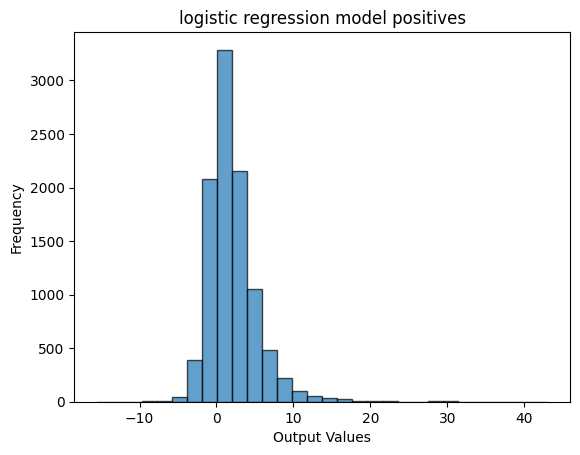

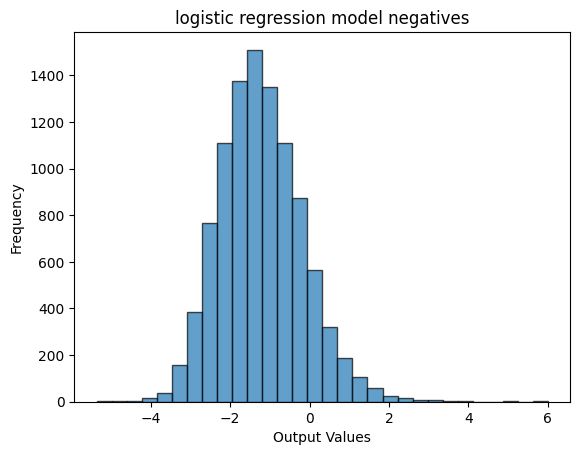

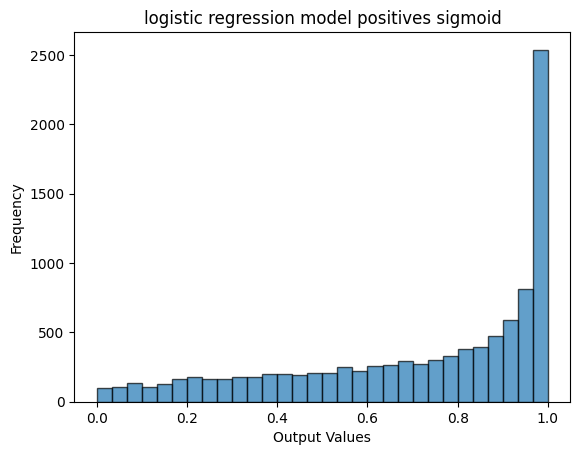

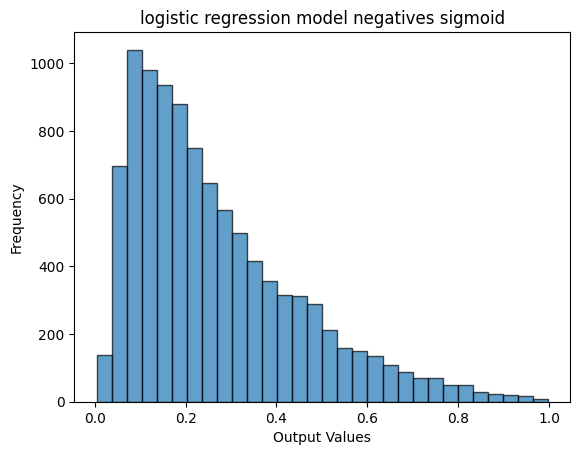

In [ ]:
plot_histogram(o[:o.shape[0]//2], "logistic regression model positives")
plot_histogram(o[o.shape[0]//2:], "logistic regression model negatives")
plot_histogram(torch.sigmoid(o[:o.shape[0]//2]), "logistic regression model positives sigmoid")
plot_histogram(torch.sigmoid(o[o.shape[0]//2:]), "logistic regression model negatives sigmoid")

In [ ]:
torch.save(embd, path.join(datasets_path, "logits_embedding.pth"))

In [ ]:
save_model(best_model, datasets_path, "logistic_model.pth")

In [ ]:
train_outfits, train_outfits_indices

(tensor([114266,  17510,  72727,  ..., 149946,  47046, 171879]),
 tensor([    0,     0,     0,  ..., 53305, 53305, 53305]))

In [ ]:
a ,b = torch.unique(train_outfits_indices, return_counts=True)

In [ ]:
a, b.max()

(tensor([    0,     1,     2,  ..., 53303, 53304, 53305]), tensor(18))

In [ ]:
t1 = torch.arange(256).reshape((4,8,8))
t1 = torch.arange(256).reshape((4,8,8))
t1.shape

torch.Size([4, 8, 8])

In [ ]:
def padding_outfits(outfits, outfits_indices):
  result_tensor = torch.full((outfits_indices.max()+1, torch.unique(outfits_indices, return_counts=True)[1].max().item()),(-1))
  position = torch.zeros(outfits_indices.max()+1, dtype=int)

  for i in range(outfits_indices.size(0)):
      idx = outfits_indices[i]
      pos = position[idx]
      result_tensor[idx, pos] = outfits[i]
      position[idx] += 1

  return result_tensor

In [ ]:
train_padded_tensor = padding_outfits(train_outfits, train_outfits_indices)
valid_padded_tensor = padding_outfits(valid_outfits, valid_outfits_indices)
test_padded_tensor = padding_outfits(test_outfits, test_outfits_indices)

In [ ]:
torch.save(train_padded_tensor, path.join(datasets_path, "fib_train_padded_outfits.pth"))
torch.save(valid_padded_tensor, path.join(datasets_path, "fib_valid_padded_outfits.pth"))
torch.save(test_padded_tensor, path.join(datasets_path, "fib_test_padded_outfits.pth"))

In [ ]:
result_tensor.shape, train_choices.shape

(torch.Size([53306, 18]), torch.Size([53306, 4]))